<a href="https://colab.research.google.com/github/mofuoku417/Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Price-Using-Machine-Learning-Techniques/blob/main/Main2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Objective
The goal of this study is to apply Holt-Winters, Support Vector Regression (SVR), and Multi-Layer Perceptron (MLP) techniques to predict monthly crude oil price. 

In [165]:
!pip install pandas_bokeh

###Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Load the Libraries

In [202]:
import plotly.express as px
import pandas_bokeh 
import plotly.graph_objects as go
import matplotlib.dates as mdates
from statsmodels.tsa.api import SimpleExpSmoothing
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from keras.models import Sequential
from keras.layers import Dense

###Define Functions to ADD time Features to the Models

In [3]:
def create_time_features(df, target=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    X = df.drop(['date'], axis=1)
    if target:
        y = df[target]
        X = X.drop([target], axis=1)
        return X, y

    return X

###Define Functions to Facilitate Metrics Evaluation

In [4]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the Mean Absolute Percentage Error
#def MAPE(y_true, y_pred): 
    #mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    #return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Calculate the Root Mean Squared Error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

# MAE:   Mean Absolute Error
# MDA:   Mean Direction Accuracy
# MAPE:  Mean Absolute Percentage Error
# RMSE:  Root Mean Squared Error
# MSE:   Mean Squared Error

###Load Data

In [5]:
df_cl = pd.read_csv("/content/gdrive/MyDrive/df_cl.csv")
date_rng = pd.date_range(start='2002-02-28', end='2021-03-31', freq='M')

In [6]:
df_cl.head()

Unnamed: 0       Month  cpo_pri  ...  sfo_pri  rps_pri  wti_spri
0           0  2002-02-01      323  ...    578.0   423.45     28.67
1           1  2002-03-01      345  ...    557.0   415.85     24.49
2           2  2002-04-01      362  ...    552.0   410.77     22.06
3           3  2002-05-01      376  ...    574.0   414.82     21.64
4           4  2002-06-01      383  ...    595.0   451.04     22.30

[5 rows x 9 columns]

In [7]:
df_cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  230 non-null    int64  
 1   Month       230 non-null    object 
 2   cpo_pri     230 non-null    int64  
 3   cno_pri     230 non-null    int64  
 4   sbo_pri     230 non-null    float64
 5   pno_pri     230 non-null    float64
 6   sfo_pri     230 non-null    float64
 7   rps_pri     230 non-null    float64
 8   wti_spri    230 non-null    float64
dtypes: float64(5), int64(3), object(1)
memory usage: 16.3+ KB


In [8]:
del df_cl['Unnamed: 0']

###Plot the Multivariate Time Series

In [9]:
df_wide = df_cl
df_long = pd.melt(df_wide, id_vars=['Month'], value_vars=['cpo_pri',	'cno_pri',	'sbo_pri','pno_pri','sfo_pri','rps_pri','wti_spri'])

# plotly 
fig = px.line(df_long, x='Month', y='value', color='variable')
fig.show()
plt.savefig('/content/MTS.png')
#fig.show(renderer="colab")

<Figure size 432x288 with 0 Axes>

In [10]:
df_cl['Month'] = df_cl['Month'].apply(pd.to_datetime)
df_cl['index'] = pd.DataFrame(date_rng, columns=['Month'])

In [11]:
df_cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Month     230 non-null    datetime64[ns]
 1   cpo_pri   230 non-null    int64         
 2   cno_pri   230 non-null    int64         
 3   sbo_pri   230 non-null    float64       
 4   pno_pri   230 non-null    float64       
 5   sfo_pri   230 non-null    float64       
 6   rps_pri   230 non-null    float64       
 7   wti_spri  230 non-null    float64       
 8   index     230 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(5), int64(2)
memory usage: 16.3 KB


In [12]:
#df_cl['Month'] = df_cl['Month'].apply(pd.to_datetime)
df_cl['index'] = pd.DataFrame(date_rng, columns=['Month'])

<Figure size 1152x576 with 0 Axes>

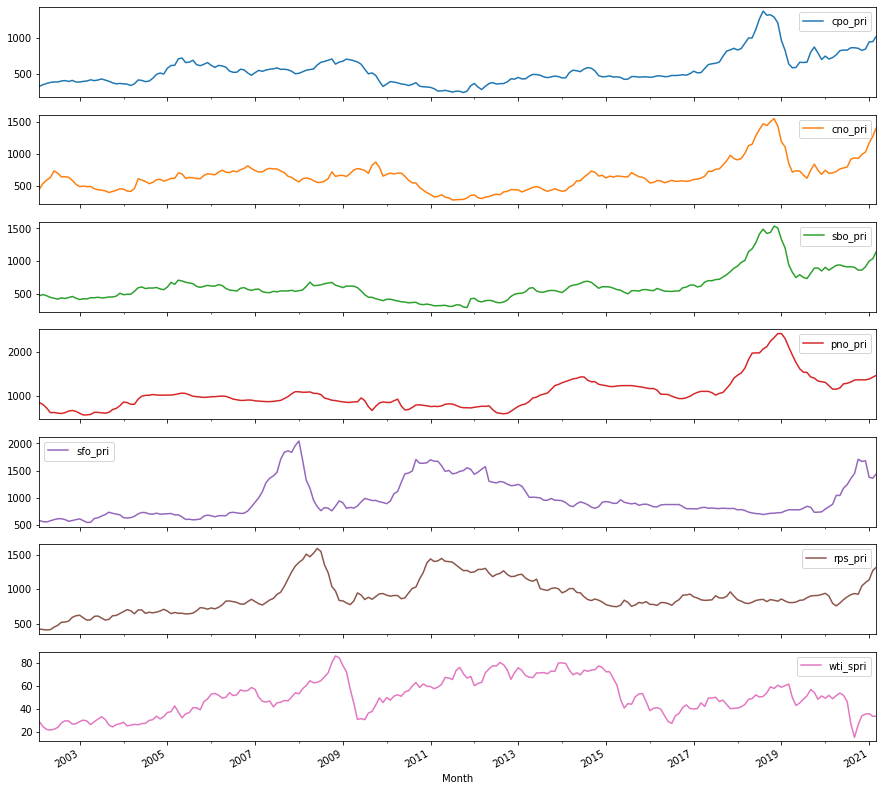

In [13]:
plt.figure(figsize=(16, 8)) 
df_cl.set_index('Month')[['cpo_pri', 'cno_pri','sbo_pri', 'pno_pri', 'sfo_pri', 'rps_pri', 'wti_spri']].plot(subplots=True, figsize=(15,15))
plt.savefig('/content/subplts.png')

In [14]:
df_cl['index'] = pd.DataFrame(date_rng, columns=['Month'])
del df_cl['Month']

In [15]:
df_cl.head()

cpo_pri  cno_pri  sbo_pri  pno_pri  sfo_pri  rps_pri  wti_spri      index
0      323      455    468.0    844.0    578.0   423.45     28.67 2002-02-28
1      345      546    485.0    799.0    557.0   415.85     24.49 2002-03-31
2      362      595    466.0    718.0    552.0   410.77     22.06 2002-04-30
3      376      636    442.0    614.0    574.0   414.82     21.64 2002-05-31
4      383      738    429.0    619.0    595.0   451.04     22.30 2002-06-30

In [16]:
df_cl.set_index('index',inplace=True)

In [17]:
split_date = '2017-06'
df_training = df_cl.loc[df_cl.index <= split_date]
df_test = df_cl.loc[df_cl.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")
df_training_len = 184

184 days of training data 
 46 days of testing data 


In [18]:
X = df_cl['cpo_pri']
test = X.iloc[-46:]
train = X.iloc[:-46]

##Naïve Forecast:

In [19]:
y_hat = df_test.copy()
nd = np.asarray(df_training.cpo_pri)
y_hat['naive'] = nd[len(nd)-1]

####Plot train, test and forecast

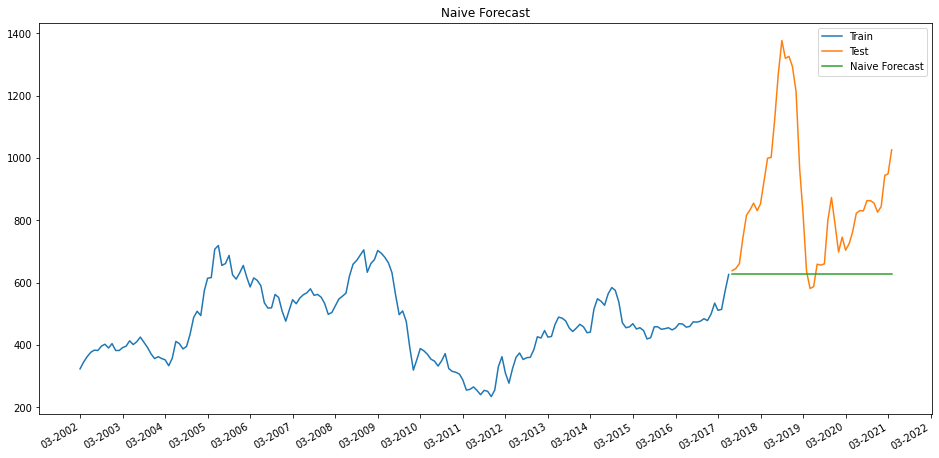

<Figure size 432x288 with 0 Axes>

In [20]:
plt.figure(figsize=(16,8))
plt.plot(df_training.index, df_training['cpo_pri'], label='Train')
plt.plot(df_test.index,df_test['cpo_pri'], label='Test')
plt.plot(y_hat.index, y_hat['naive'], label='Naive Forecast')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()
plt.savefig('/content/MNF.png')

In [199]:
df_test['cpo_pri']

0      638
1      645
2      661
3      743
4      816
5      833
6      855
7      831
8      852
9      926
10     999
11    1002
12    1122
13    1269
14    1377
15    1320
16    1326
17    1293
18    1213
19     964
20     826
21     636
22     581
23     587
24     659
25     656
26     660
27     800
28     873
29     789
30     698
31     746
32     704
33     725
34     763
35     822
36     831
37     830
38     863
39     863
40     855
41     826
42     844
43     944
44     949
45    1026
Name: cpo_pri, dtype: int64

In [200]:
df_test

index  cpo_pri  cno_pri  sbo_pri  pno_pri  sfo_pri  rps_pri  wti_spri
0  2017-06-30      638      731   697.33  1071.64   809.86   847.47     49.44
1  2017-07-31      645      763   715.04  1016.33   800.76   905.99     50.17
2  2017-08-31      661      769   719.03  1055.21   799.04   875.36     46.41
3  2017-09-30      743      828   753.70  1078.17   806.00   872.87     47.65
4  2017-10-31      816      894   788.70  1169.41   800.91   897.25     43.89
5  2017-11-30      833      979   835.55  1268.18   799.33   962.98     40.23
6  2017-12-31      855      929   887.12  1404.95   801.32   901.97     40.50
7  2018-01-31      831      910   921.79  1472.30   775.00   848.38     40.68
8  2018-02-28      852      930   977.48  1523.39   780.05   827.48     41.82
9  2018-03-31      926     1010  1007.69  1633.34   763.23   800.24     43.86
10 2018-04-30      999     1131  1141.52  1829.84   733.95   793.31     48.32
11 2018-05-31     1002     1153  1187.73  1978.91   718.04   811.49     48.95
12 2018-06-30     1122     1285  1280.20  1984.16   706.09   838.02     52.22
13 2018-07-31     1269     1382  1414.17  1984.16   703.00   848.61     50.36
14 2018-08-31     1377     1471  1488.74  2075.49   688.13   853.67     50.88
15 2018-09-30     1320     1443  1422.23  2126.46   700.00   821.47     54.03
16 2018-10-31     1326     1502  1437.87  2253.22   711.71   850.55     59.21
17 2018-11-30     1293     1551  1535.16  2332.70   713.00   840.39     57.82
18 2018-12-31     1213     1436  1506.98  2425.08   721.57   827.02     60.61
19 2019-01-31      964     1193  1329.64  2427.18   725.00   859.73     58.88
20 2019-02-28      826     1110  1201.02  2313.85   753.83   829.70     60.21
21 2019-03-31      636      856   942.53  2119.44   776.00   808.68     61.61
22 2019-04-30      581      719   825.64  1933.45   776.00   805.96     49.86
23 2019-05-31      587      740   745.55  1761.69   776.00   815.84     43.02
24 2019-06-30      659      734   789.89  1619.87   776.00   840.01     45.12
25 2019-07-31      656      673   747.64  1543.24   805.16   845.27     48.41
26 2019-08-31      660      625   730.71  1535.22   840.33   877.48     51.45
27 2019-09-30      800      747   809.08  1433.00   823.00   903.07     56.83
28 2019-10-31      873      843   889.62  1406.55   730.00   908.67     54.40
29 2019-11-30      789      747   892.92  1338.81   732.10   910.73     48.42
30 2019-12-31      698      685   846.30  1322.77   738.26   924.50     51.29
31 2020-01-31      746      747   903.15  1310.18   788.36   941.46     49.29
32 2020-02-29      704      701   858.18  1232.58   833.17   902.34     51.75
33 2020-03-31      725      706   897.00  1155.42   877.14   796.67     48.84
34 2020-04-30      763      729   932.38  1151.65  1041.73   758.96     51.61
35 2020-05-31      822      768   939.91  1181.87  1040.69   799.83     53.83
36 2020-06-30      831      784   920.55  1275.53  1176.12   850.98     51.82
37 2020-07-31      830      798   909.19  1287.50  1240.71   890.21     46.32
38 2020-08-31      863      921   911.07  1317.02  1353.21   921.55     27.02
39 2020-09-30      863      940   902.83  1361.62  1444.89   938.14     15.20
40 2020-10-31      855      932   859.49  1366.87  1708.44   927.71     26.20
41 2020-11-30      826      993   860.28  1366.87  1667.82  1047.78     34.03
42 2020-12-31      844     1031   910.82  1366.87  1680.32  1097.63     35.50
43 2021-01-31      944     1170   997.62  1383.90  1375.09  1138.24     35.81
44 2021-02-28      949     1275  1035.26  1426.71  1359.46  1272.13     33.59
45 2021-03-31     1026     1412  1146.75  1471.32  1444.54  1321.88     33.57

##Simple Exponential Smoothing (SES)

###Apply Grid Search to get Optimal Parameters of the Simple Exponential Smoothing Model

In [ ]:
resu = []
temp_df = pd.DataFrame()
for i in [0 , 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90,1]:
    print(f'Fitting for smoothing level= {i}')
    fit_v = SimpleExpSmoothing(np.asarray(train)).fit(i)
    fcst_pred_v= fit_v.forecast(46)
    rmse = np.sqrt(metrics.mean_squared_error(test, fcst_pred_v))
    df3 = {'smoothing parameter':i, 'RMSE': rmse}
    temp_df = temp_df.append(df3, ignore_index=True)
temp_df.sort_values(by=['RMSE']).head(3)

Fitting for smoothing level= 0
Fitting for smoothing level= 0.1
Fitting for smoothing level= 0.2
Fitting for smoothing level= 0.3
Fitting for smoothing level= 0.4
Fitting for smoothing level= 0.5
Fitting for smoothing level= 0.6
Fitting for smoothing level= 0.7
Fitting for smoothing level= 0.8
Fitting for smoothing level= 0.9
Fitting for smoothing level= 1


RMSE  smoothing parameter
10  318.553627                  1.0
9   323.166226                  0.9
8   328.729260                  0.8

The least RMSE was achieved with smoothing_level equal to 0.1. Next we utilize it to train the model.

In [21]:
fitSES = SimpleExpSmoothing(np.asarray(train)).fit(smoothing_level = 1,optimized= False)
SES_gs_pred = fitSES.forecast(46)

In [22]:
test = test.reset_index()
del test['index']

In [23]:
test.columns = ['Predictions']

In [24]:
SES_gs_pred

array([626., 626., 626., 626., 626., 626., 626., 626., 626., 626., 626.,
       626., 626., 626., 626., 626., 626., 626., 626., 626., 626., 626.,
       626., 626., 626., 626., 626., 626., 626., 626., 626., 626., 626.,
       626., 626., 626., 626., 626., 626., 626., 626., 626., 626., 626.,
       626., 626.])

In [25]:
SES_gs_pred = pd.DataFrame(SES_gs_pred, columns = ['Predictions'])

In [26]:
SES_gs_pred.to_csv('SES_gs_pred.csv')

In [ ]:
#with open ('content/SES_gs_pred_pickle', 'wb') as f:
  #pickle.dump(SES_gs_pred, f)

#Recall the saved model
#with open('/content/SES_gs_pred_pickle', 'rb') as f:
  #SES_gs_pred = pickle.load(f)

In [ ]:
#with open ('SES_gs_pred', '/content/SES_gs_pred') as f:
  #pickle.dump(SES_gs_pred, f)

#Recall the saved model
#with open('Holt_pickle', 'rb') as f:
  #Holt = pickle.load(f)

  #/content/subplts.png

###Compute SES Evaluation Metrics

In [27]:
MAE_ses = mean_absolute_error(test, SES_gs_pred)
print('MAE value of the SES Model is:', MAE_ses)

MDA_ses = mda(test, SES_gs_pred)
print("MDA value of the SES Model is:", *MDA_ses)

MAPE_ses = mean_absolute_percentage_error(test, SES_gs_pred)
print('MAPE value of the SES Model is:', MAPE_ses)

RMSE_ses = mean_squared_error(test, SES_gs_pred, squared=False)
print('RMSE value of the SES Model is:', RMSE_ses)

MSE_ses = mean_squared_error(test, SES_gs_pred)
print('MSE value of the SES Model is:', MSE_ses)

MAE value of the SES Model is: 248.1086956521739
MDA value of the SES Model is: 0.9565217391304348
MAPE value of the SES Model is: 25.11552432741552
RMSE value of the SES Model is: 318.5536266368321
MSE value of the SES Model is: 101476.41304347826


###Plot train, test and forecast

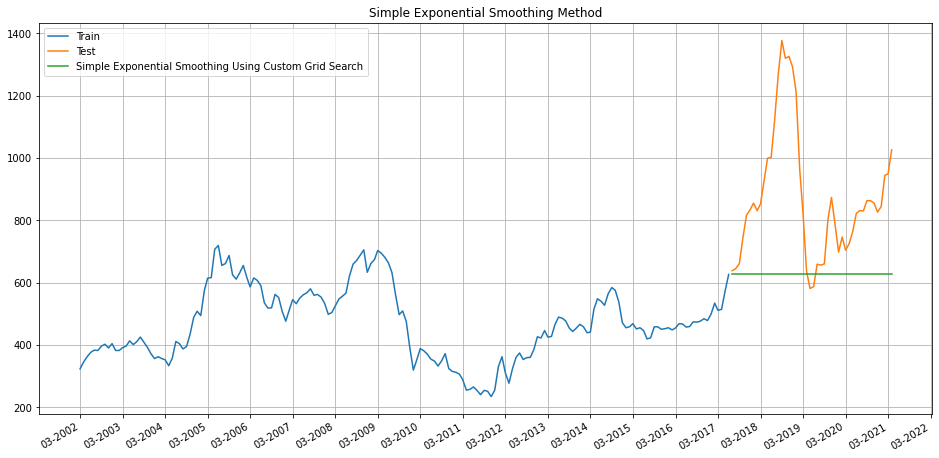

<Figure size 432x288 with 0 Axes>

In [28]:
plt.figure(figsize=(16,8))
plt.grid()
plt.plot(df_training.index, df_training.cpo_pri, label = 'Train')
plt.plot(df_test.index, df_test.cpo_pri,  label = 'Test')
plt.plot(df_test.index, SES_gs_pred,label = 'Simple Exponential Smoothing Using Custom Grid Search')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.legend(loc = 'best')
plt.title('Simple Exponential Smoothing Method')
plt.show()
plt.savefig('/content/SES.png')

###SES Prediction Plot Zoomed-In

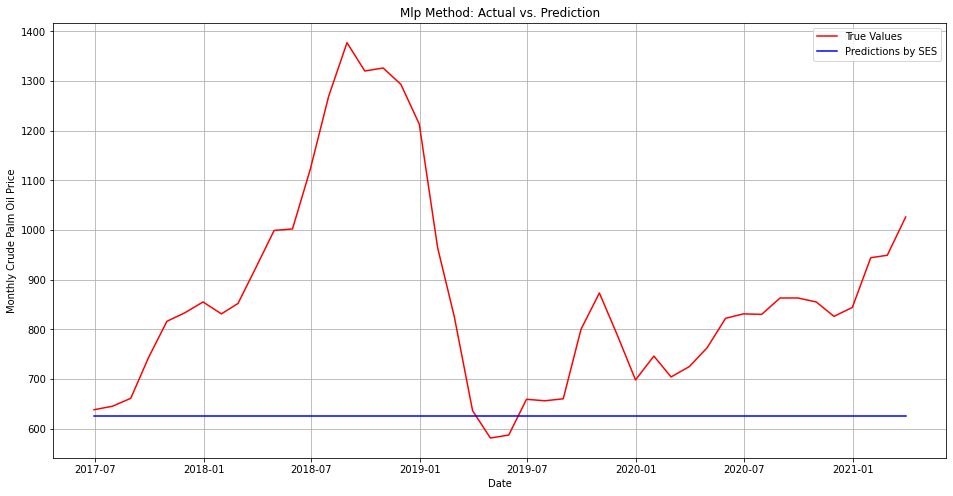

<Figure size 432x288 with 0 Axes>

In [29]:
plt.figure(figsize=(16,8))
plt.grid()
plt.plot(df_test.index, df_test.cpo_pri, color = 'red',  label = 'Test')
plt.plot(df_test.index,  SES_gs_pred, color = 'blue',label = 'SES Prediction')
plt.legend(['True Values', 'Predictions by SES', 'SES Prediction'],loc='best')
plt.title('Mlp Method: Actual vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')
plt.show()
plt.savefig('/content/SES_ZI.png')

##Double Exponential Smoothing (DES)

###Apply Grid Search to get Optimal Parameters of the Double Exponential Smoothing Model

In [ ]:
#DES Grid Search Parameters
param_grid = {'smoothing_level': [0.10, 0.20,.30,.40,.50,.60,.70,.80,.90], 'smoothing_slope':[0.10, 0.20,.30,.40,.50,.60,.70,.80,.90],'damping_slope': [0.10, 0.20,.30,.40,.50,.60,.70,.80,.90],'damped' : [True, False]}
pg = list(ParameterGrid(param_grid))

In [ ]:
df_results_moni = pd.DataFrame(columns=['smoothing_level', 'smoothing_slope', 'damping_slope','damped','RMSE','r2'])
start = timer()
for a,b in enumerate(pg):
    smoothing_level = b.get('smoothing_level')
    smoothing_slope = b.get('smoothing_slope')
    damping_slope = b.get('damping_slope')
    damped = b.get('damped')
    print(smoothing_level, smoothing_slope, damping_slope,damped)
    fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope, damping_slope = damping_slope ,optimized=False)
    z = fit1.forecast(46)
    print(z)
    df_pred = pd.DataFrame(z, columns=['Forecasted_result'])
    RMSE = np.sqrt(metrics.mean_squared_error(test, df_pred.Forecasted_result))
    r2 = metrics.r2_score(test, df_pred.Forecasted_result)
    print( f' RMSE is {np.sqrt(metrics.mean_squared_error(test, df_pred.Forecasted_result))}')
    df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
end = timer()
print(f' Total time taken to complete grid search in seconds: {(end - start)}')

0.1 0.1 0.1 True
2017-06-30    506.238296
2017-07-31    506.252537
2017-08-31    506.253961
2017-09-30    506.254104
2017-10-31    506.254118
2017-11-30    506.254120
2017-12-31    506.254120
2018-01-31    506.254120
2018-02-28    506.254120
2018-03-31    506.254120
2018-04-30    506.254120
2018-05-31    506.254120
2018-06-30    506.254120
2018-07-31    506.254120
2018-08-31    506.254120
2018-09-30    506.254120
2018-10-31    506.254120
2018-11-30    506.254120
2018-12-31    506.254120
2019-01-31    506.254120
2019-02-28    506.254120
2019-03-31    506.254120
2019-04-30    506.254120
2019-05-31    506.254120
2019-06-30    506.254120
2019-07-31    506.254120
2019-08-31    506.254120
2019-09-30    506.254120
2019-10-31    506.254120
2019-11-30    506.254120
2019-12-31    506.254120
2020-01-31    506.254120
2020-02-29    506.254120
2020-03-31    506.254120
2020-04-30    506.254120
2020-05-31    506.254120
2020-06-30    506.254120
2020-07-31    506.254120
2020-08-31    506.254120
2020-09-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f


2017-06-30    508.791124
2017-07-31    508.903551
2017-08-31    508.914794
2017-09-30    508.915919
2017-10-31    508.916031
2017-11-30    508.916042
2017-12-31    508.916043
2018-01-31    508.916043
2018-02-28    508.916043
2018-03-31    508.916043
2018-04-30    508.916043
2018-05-31    508.916043
2018-06-30    508.916043
2018-07-31    508.916043
2018-08-31    508.916043
2018-09-30    508.916043
2018-10-31    508.916043
2018-11-30    508.916043
2018-12-31    508.916043
2019-01-31    508.916043
2019-02-28    508.916043
2019-03-31    508.916043
2019-04-30    508.916043
2019-05-31    508.916043
2019-06-30    508.916043
2019-07-31    508.916043
2019-08-31    508.916043
2019-09-30    508.916043
2019-10-31    508.916043
2019-11-30    508.916043
2019-12-31    508.916043
2020-01-31    508.916043
2020-02-29    508.916043
2020-03-31    508.916043
2020-04-30    508.916043
2020-05-31    508.916043
2020-06-30    508.916043
2020-07-31    508.916043
2020-08-31    508.916043
2020-09-30    508.916043

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    537.903674
2017-07-31    538.047062
2017-08-31    538.061401
2017-09-30    538.062835
2017-10-31    538.062978
2017-11-30    538.062992
2017-12-31    538.062994
2018-01-31    538.062994
2018-02-28    538.062994
2018-03-31    538.062994
2018-04-30    538.062994
2018-05-31    538.062994
2018-06-30    538.062994
2018-07-31    538.062994
2018-08-31    538.062994
2018-09-30    538.062994
2018-10-31    538.062994
2018-11-30    538.062994
2018-12-31    538.062994
2019-01-31    538.062994
2019-02-28    538.062994
2019-03-31    538.062994
2019-04-30    538.062994
2019-05-31    538.062994
2019-06-30    538.062994
2019-07-31    538.062994
2019-08-31    538.062994
2019-09-30    538.062994
2019-10-31    538.062994
2019-11-30    538.062994
2019-12-31    538.062994
2020-01-31    538.062994
2020-02-29    538.062994
2020-03-31    538.062994
2020-04-30    538.062994
2020-05-31    538.062994
2020-06-30    538.062994
2020-07-31    538.062994
2020-08-31    538.062994
2020-09-30    538.062994


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

 RMSE is 373.83661829076703
0.3 0.4 0.1 True
2017-06-30    557.793794
2017-07-31    557.920952
2017-08-31    557.933668
2017-09-30    557.934940
2017-10-31    557.935067
2017-11-30    557.935079
2017-12-31    557.935081
2018-01-31    557.935081
2018-02-28    557.935081
2018-03-31    557.935081
2018-04-30    557.935081
2018-05-31    557.935081
2018-06-30    557.935081
2018-07-31    557.935081
2018-08-31    557.935081
2018-09-30    557.935081
2018-10-31    557.935081
2018-11-30    557.935081
2018-12-31    557.935081
2019-01-31    557.935081
2019-02-28    557.935081
2019-03-31    557.935081
2019-04-30    557.935081
2019-05-31    557.935081
2019-06-30    557.935081
2019-07-31    557.935081
2019-08-31    557.935081
2019-09-30    557.935081
2019-10-31    557.935081
2019-11-30    557.935081
2019-12-31    557.935081
2020-01-31    557.935081
2020-02-29    557.935081
2020-03-31    557.935081
2020-04-30    557.935081
2020-05-31    557.935081
2020-06-30    557.935081
2020-07-31    557.935081
2020-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    571.902704
2017-07-31    571.941528
2017-08-31    571.945410
2017-09-30    571.945798
2017-10-31    571.945837
2017-11-30    571.945841
2017-12-31    571.945841
2018-01-31    571.945841
2018-02-28    571.945841
2018-03-31    571.945841
2018-04-30    571.945841
2018-05-31    571.945841
2018-06-30    571.945841
2018-07-31    571.945841
2018-08-31    571.945841
2018-09-30    571.945841
2018-10-31    571.945841
2018-11-30    571.945841
2018-12-31    571.945841
2019-01-31    571.945841
2019-02-28    571.945841
2019-03-31    571.945841
2019-04-30    571.945841
2019-05-31    571.945841
2019-06-30    571.945841
2019-07-31    571.945841
2019-08-31    571.945841
2019-09-30    571.945841
2019-10-31    571.945841
2019-11-30    571.945841
2019-12-31    571.945841
2020-01-31    571.945841
2020-02-29    571.945841
2020-03-31    571.945841
2020-04-30    571.945841
2020-05-31    571.945841
2020-06-30    571.945841
2020-07-31    571.945841
2020-08-31    571.945841
2020-09-30    571.945841


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    575.924662
2017-07-31    576.227520
2017-08-31    576.257806
2017-09-30    576.260834
2017-10-31    576.261137
2017-11-30    576.261167
2017-12-31    576.261170
2018-01-31    576.261171
2018-02-28    576.261171
2018-03-31    576.261171
2018-04-30    576.261171
2018-05-31    576.261171
2018-06-30    576.261171
2018-07-31    576.261171
2018-08-31    576.261171
2018-09-30    576.261171
2018-10-31    576.261171
2018-11-30    576.261171
2018-12-31    576.261171
2019-01-31    576.261171
2019-02-28    576.261171
2019-03-31    576.261171
2019-04-30    576.261171
2019-05-31    576.261171
2019-06-30    576.261171
2019-07-31    576.261171
2019-08-31    576.261171
2019-09-30    576.261171
2019-10-31    576.261171
2019-11-30    576.261171
2019-12-31    576.261171
2020-01-31    576.261171
2020-02-29    576.261171
2020-03-31    576.261171
2020-04-30    576.261171
2020-05-31    576.261171
2020-06-30    576.261171
2020-07-31    576.261171
2020-08-31    576.261171
2020-09-30    576.261171


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.5 0.6 0.1 True
2017-06-30    587.794646
2017-07-31    588.057368
2017-08-31    588.083641
2017-09-30    588.086268
2017-10-31    588.086530
2017-11-30    588.086557
2017-12-31    588.086559
2018-01-31    588.086560
2018-02-28    588.086560
2018-03-31    588.086560
2018-04-30    588.086560
2018-05-31    588.086560
2018-06-30    588.086560
2018-07-31    588.086560
2018-08-31    588.086560
2018-09-30    588.086560
2018-10-31    588.086560
2018-11-30    588.086560
2018-12-31    588.086560
2019-01-31    588.086560
2019-02-28    588.086560
2019-03-31    588.086560
2019-04-30    588.086560
2019-05-31    588.086560
2019-06-30    588.086560
2019-07-31    588.086560
2019-08-31    588.086560
2019-09-30    588.086560
2019-10-31    588.086560
2019-11-30    588.086560
2019-12-31    588.086560
2020-01-31    588.086560
2020-02-29    588.086560
2020-03-31    588.086560
2020-04-30    588.086560
2020-05-31    588.086560
2020-06-30    588.086560
2020-07-31    588.086560
2020-08-31    588.086560
2020-09-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

 0.3 0.1 True
2017-06-30    596.993128
2017-07-31    597.140769
2017-08-31    597.155534
2017-09-30    597.157010
2017-10-31    597.157158
2017-11-30    597.157172
2017-12-31    597.157174
2018-01-31    597.157174
2018-02-28    597.157174
2018-03-31    597.157174
2018-04-30    597.157174
2018-05-31    597.157174
2018-06-30    597.157174
2018-07-31    597.157174
2018-08-31    597.157174
2018-09-30    597.157174
2018-10-31    597.157174
2018-11-30    597.157174
2018-12-31    597.157174
2019-01-31    597.157174
2019-02-28    597.157174
2019-03-31    597.157174
2019-04-30    597.157174
2019-05-31    597.157174
2019-06-30    597.157174
2019-07-31    597.157174
2019-08-31    597.157174
2019-09-30    597.157174
2019-10-31    597.157174
2019-11-30    597.157174
2019-12-31    597.157174
2020-01-31    597.157174
2020-02-29    597.157174
2020-03-31    597.157174
2020-04-30    597.157174
2020-05-31    597.157174
2020-06-30    597.157174
2020-07-31    597.157174
2020-08-31    597.157174
2020-09-30 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    605.245298
2017-07-31    605.299028
2017-08-31    605.304401
2017-09-30    605.304938
2017-10-31    605.304992
2017-11-30    605.304997
2017-12-31    605.304998
2018-01-31    605.304998
2018-02-28    605.304998
2018-03-31    605.304998
2018-04-30    605.304998
2018-05-31    605.304998
2018-06-30    605.304998
2018-07-31    605.304998
2018-08-31    605.304998
2018-09-30    605.304998
2018-10-31    605.304998
2018-11-30    605.304998
2018-12-31    605.304998
2019-01-31    605.304998
2019-02-28    605.304998
2019-03-31    605.304998
2019-04-30    605.304998
2019-05-31    605.304998
2019-06-30    605.304998
2019-07-31    605.304998
2019-08-31    605.304998
2019-09-30    605.304998
2019-10-31    605.304998
2019-11-30    605.304998
2019-12-31    605.304998
2020-01-31    605.304998
2020-02-29    605.304998
2020-03-31    605.304998
2020-04-30    605.304998
2020-05-31    605.304998
2020-06-30    605.304998
2020-07-31    605.304998
2020-08-31    605.304998
2020-09-30    605.304998


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.1 True
2017-06-30    609.696762
2017-07-31    610.110723
2017-08-31    610.152119
2017-09-30    610.156259
2017-10-31    610.156673
2017-11-30    610.156714
2017-12-31    610.156718
2018-01-31    610.156719
2018-02-28    610.156719
2018-03-31    610.156719
2018-04-30    610.156719
2018-05-31    610.156719
2018-06-30    610.156719
2018-07-31    610.156719
2018-08-31    610.156719
2018-09-30    610.156719
2018-10-31    610.156719
2018-11-30    610.156719
2018-12-31    610.156719
2019-01-31    610.156719
2019-02-28    610.156719
2019-03-31    610.156719
2019-04-30    610.156719
2019-05-31    610.156719
2019-06-30    610.156719
2019-07-31    610.156719
2019-08-31    610.156719
2019-09-30    610.156719
2019-10-31    610.156719
2019-11-30    610.156719
2019-12-31    610.156719
2020-01-31    610.156719
2020-02-29    610.156719
2020-03-31    610.156719
2020-04-30    610.156719
2020-05-31    610.156719
2020-06-30    610.156719
2020-07-31    610.156719
2020-08-31    610.156719
2020-09-30    61

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    616.104434
2017-07-31    616.380800
2017-08-31    616.408437
2017-09-30    616.411201
2017-10-31    616.411477
2017-11-30    616.411505
2017-12-31    616.411507
2018-01-31    616.411508
2018-02-28    616.411508
2018-03-31    616.411508
2018-04-30    616.411508
2018-05-31    616.411508
2018-06-30    616.411508
2018-07-31    616.411508
2018-08-31    616.411508
2018-09-30    616.411508
2018-10-31    616.411508
2018-11-30    616.411508
2018-12-31    616.411508
2019-01-31    616.411508
2019-02-28    616.411508
2019-03-31    616.411508
2019-04-30    616.411508
2019-05-31    616.411508
2019-06-30    616.411508
2019-07-31    616.411508
2019-08-31    616.411508
2019-09-30    616.411508
2019-10-31    616.411508
2019-11-30    616.411508
2019-12-31    616.411508
2020-01-31    616.411508
2020-02-29    616.411508
2020-03-31    616.411508
2020-04-30    616.411508
2020-05-31    616.411508
2020-06-30    616.411508
2020-07-31    616.411508
2020-08-31    616.411508
2020-09-30    616.411508


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.9 0.3 0.1 True
2017-06-30    621.905016
2017-07-31    622.077971
2017-08-31    622.095267
2017-09-30    622.096997
2017-10-31    622.097169
2017-11-30    622.097187
2017-12-31    622.097188
2018-01-31    622.097189
2018-02-28    622.097189
2018-03-31    622.097189
2018-04-30    622.097189
2018-05-31    622.097189
2018-06-30    622.097189
2018-07-31    622.097189
2018-08-31    622.097189
2018-09-30    622.097189
2018-10-31    622.097189
2018-11-30    622.097189
2018-12-31    622.097189
2019-01-31    622.097189
2019-02-28    622.097189
2019-03-31    622.097189
2019-04-30    622.097189
2019-05-31    622.097189
2019-06-30    622.097189
2019-07-31    622.097189
2019-08-31    622.097189
2019-09-30    622.097189
2019-10-31    622.097189
2019-11-30    622.097189
2019-12-31    622.097189
2020-01-31    622.097189
2020-02-29    622.097189
2020-03-31    622.097189
2020-04-30    622.097189
2020-05-31    622.097189
2020-06-30    622.097189
2020-07-31    622.097189
2020-08-31    622.097189
2020-09-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    625.424751
2017-07-31    625.918251
2017-08-31    625.967601
2017-09-30    625.972536
2017-10-31    625.973030
2017-11-30    625.973079
2017-12-31    625.973084
2018-01-31    625.973085
2018-02-28    625.973085
2018-03-31    625.973085
2018-04-30    625.973085
2018-05-31    625.973085
2018-06-30    625.973085
2018-07-31    625.973085
2018-08-31    625.973085
2018-09-30    625.973085
2018-10-31    625.973085
2018-11-30    625.973085
2018-12-31    625.973085
2019-01-31    625.973085
2019-02-28    625.973085
2019-03-31    625.973085
2019-04-30    625.973085
2019-05-31    625.973085
2019-06-30    625.973085
2019-07-31    625.973085
2019-08-31    625.973085
2019-09-30    625.973085
2019-10-31    625.973085
2019-11-30    625.973085
2019-12-31    625.973085
2020-01-31    625.973085
2020-02-29    625.973085
2020-03-31    625.973085
2020-04-30    625.973085
2020-05-31    625.973085
2020-06-30    625.973085
2020-07-31    625.973085
2020-08-31    625.973085
2020-09-30    625.973085


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    511.298225
2017-07-31    511.714038
2017-08-31    511.797200
2017-09-30    511.813833
2017-10-31    511.817159
2017-11-30    511.817825
2017-12-31    511.817958
2018-01-31    511.817984
2018-02-28    511.817990
2018-03-31    511.817991
2018-04-30    511.817991
2018-05-31    511.817991
2018-06-30    511.817991
2018-07-31    511.817991
2018-08-31    511.817991
2018-09-30    511.817991
2018-10-31    511.817991
2018-11-30    511.817991
2018-12-31    511.817991
2019-01-31    511.817991
2019-02-28    511.817991
2019-03-31    511.817991
2019-04-30    511.817991
2019-05-31    511.817991
2019-06-30    511.817991
2019-07-31    511.817991
2019-08-31    511.817991
2019-09-30    511.817991
2019-10-31    511.817991
2019-11-30    511.817991
2019-12-31    511.817991
2020-01-31    511.817991
2020-02-29    511.817991
2020-03-31    511.817991
2020-04-30    511.817991
2020-05-31    511.817991
2020-06-30    511.817991
2020-07-31    511.817991
2020-08-31    511.817991
2020-09-30    511.817991


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    540.229696
2017-07-31    540.733060
2017-08-31    540.833733
2017-09-30    540.853868
2017-10-31    540.857895
2017-11-30    540.858700
2017-12-31    540.858861
2018-01-31    540.858893
2018-02-28    540.858900
2018-03-31    540.858901
2018-04-30    540.858901
2018-05-31    540.858901
2018-06-30    540.858901
2018-07-31    540.858901
2018-08-31    540.858901
2018-09-30    540.858901
2018-10-31    540.858901
2018-11-30    540.858901
2018-12-31    540.858901
2019-01-31    540.858901
2019-02-28    540.858901
2019-03-31    540.858901
2019-04-30    540.858901
2019-05-31    540.858901
2019-06-30    540.858901
2019-07-31    540.858901
2019-08-31    540.858901
2019-09-30    540.858901
2019-10-31    540.858901
2019-11-30    540.858901
2019-12-31    540.858901
2020-01-31    540.858901
2020-02-29    540.858901
2020-03-31    540.858901
2020-04-30    540.858901
2020-05-31    540.858901
2020-06-30    540.858901
2020-07-31    540.858901
2020-08-31    540.858901
2020-09-30    540.858901


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.3 0.3 0.2 True
2017-06-30    559.105756
2017-07-31    559.509348
2017-08-31    559.590067
2017-09-30    559.606211
2017-10-31    559.609439
2017-11-30    559.610085
2017-12-31    559.610214
2018-01-31    559.610240
2018-02-28    559.610245
2018-03-31    559.610246
2018-04-30    559.610246
2018-05-31    559.610246
2018-06-30    559.610246
2018-07-31    559.610246
2018-08-31    559.610246
2018-09-30    559.610246
2018-10-31    559.610246
2018-11-30    559.610246
2018-12-31    559.610246
2019-01-31    559.610246
2019-02-28    559.610246
2019-03-31    559.610246
2019-04-30    559.610246
2019-05-31    559.610246
2019-06-30    559.610246
2019-07-31    559.610246
2019-08-31    559.610246
2019-09-30    559.610246
2019-10-31    559.610246
2019-11-30    559.610246
2019-12-31    559.610246
2020-01-31    559.610246
2020-02-29    559.610246
2020-03-31    559.610246
2020-04-30    559.610246
2020-05-31    559.610246
2020-06-30    559.610246
2020-07-31    559.610246
2020-08-31    559.610246
2020-09-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    565.627932
2017-07-31    566.790201
2017-08-31    567.022655
2017-09-30    567.069145
2017-10-31    567.078444
2017-11-30    567.080303
2017-12-31    567.080675
2018-01-31    567.080750
2018-02-28    567.080764
2018-03-31    567.080767
2018-04-30    567.080768
2018-05-31    567.080768
2018-06-30    567.080768
2018-07-31    567.080768
2018-08-31    567.080768
2018-09-30    567.080768
2018-10-31    567.080768
2018-11-30    567.080768
2018-12-31    567.080768
2019-01-31    567.080768
2019-02-28    567.080768
2019-03-31    567.080768
2019-04-30    567.080768
2019-05-31    567.080768
2019-06-30    567.080768
2019-07-31    567.080768
2019-08-31    567.080768
2019-09-30    567.080768
2019-10-31    567.080768
2019-11-30    567.080768
2019-12-31    567.080768
2020-01-31    567.080768
2020-02-29    567.080768
2020-03-31    567.080768
2020-04-30    567.080768
2020-05-31    567.080768
2020-06-30    567.080768
2020-07-31    567.080768
2020-08-31    567.080768
2020-09-30    567.080768


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    578.523657
2017-07-31    579.477296
2017-08-31    579.668024
2017-09-30    579.706170
2017-10-31    579.713799
2017-11-30    579.715325
2017-12-31    579.715630
2018-01-31    579.715691
2018-02-28    579.715703
2018-03-31    579.715705
2018-04-30    579.715706
2018-05-31    579.715706
2018-06-30    579.715706
2018-07-31    579.715706
2018-08-31    579.715706
2018-09-30    579.715706
2018-10-31    579.715706
2018-11-30    579.715706
2018-12-31    579.715706
2019-01-31    579.715706
2019-02-28    579.715706
2019-03-31    579.715706
2019-04-30    579.715706
2019-05-31    579.715706
2019-06-30    579.715706
2019-07-31    579.715706
2019-08-31    579.715706
2019-09-30    579.715706
2019-10-31    579.715706
2019-11-30    579.715706
2019-12-31    579.715706
2020-01-31    579.715706
2020-02-29    579.715706
2020-03-31    579.715706
2020-04-30    579.715706
2020-05-31    579.715706
2020-06-30    579.715706
2020-07-31    579.715706
2020-08-31    579.715706
2020-09-30    579.715706


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.5 0.4 0.2 True
2017-06-30    589.251392
2017-07-31    589.993290
2017-08-31    590.141670
2017-09-30    590.171346
2017-10-31    590.177281
2017-11-30    590.178468
2017-12-31    590.178706
2018-01-31    590.178753
2018-02-28    590.178763
2018-03-31    590.178765
2018-04-30    590.178765
2018-05-31    590.178765
2018-06-30    590.178765
2018-07-31    590.178765
2018-08-31    590.178765
2018-09-30    590.178765
2018-10-31    590.178765
2018-11-30    590.178765
2018-12-31    590.178765
2019-01-31    590.178765
2019-02-28    590.178765
2019-03-31    590.178765
2019-04-30    590.178765
2019-05-31    590.178765
2019-06-30    590.178765
2019-07-31    590.178765
2019-08-31    590.178765
2019-09-30    590.178765
2019-10-31    590.178765
2019-11-30    590.178765
2019-12-31    590.178765
2020-01-31    590.178765
2020-02-29    590.178765
2020-03-31    590.178765
2020-04-30    590.178765
2020-05-31    590.178765
2020-06-30    590.178765
2020-07-31    590.178765
2020-08-31    590.178765
2020-09-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    599.085855
2017-07-31    599.709943
2017-08-31    599.834760
2017-09-30    599.859723
2017-10-31    599.864716
2017-11-30    599.865715
2017-12-31    599.865914
2018-01-31    599.865954
2018-02-28    599.865962
2018-03-31    599.865964
2018-04-30    599.865964
2018-05-31    599.865964
2018-06-30    599.865964
2018-07-31    599.865964
2018-08-31    599.865964
2018-09-30    599.865964
2018-10-31    599.865964
2018-11-30    599.865964
2018-12-31    599.865964
2019-01-31    599.865964
2019-02-28    599.865964
2019-03-31    599.865964
2019-04-30    599.865964
2019-05-31    599.865964
2019-06-30    599.865964
2019-07-31    599.865964
2019-08-31    599.865964
2019-09-30    599.865964
2019-10-31    599.865964
2019-11-30    599.865964
2019-12-31    599.865964
2020-01-31    599.865964
2020-02-29    599.865964
2020-03-31    599.865964
2020-04-30    599.865964
2020-05-31    599.865964
2020-06-30    599.865964
2020-07-31    599.865964
2020-08-31    599.865964
2020-09-30    599.865964


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    606.541055
2017-07-31    608.319580
2017-08-31    608.675284
2017-09-30    608.746425
2017-10-31    608.760654
2017-11-30    608.763499
2017-12-31    608.764068
2018-01-31    608.764182
2018-02-28    608.764205
2018-03-31    608.764210
2018-04-30    608.764210
2018-05-31    608.764211
2018-06-30    608.764211
2018-07-31    608.764211
2018-08-31    608.764211
2018-09-30    608.764211
2018-10-31    608.764211
2018-11-30    608.764211
2018-12-31    608.764211
2019-01-31    608.764211
2019-02-28    608.764211
2019-03-31    608.764211
2019-04-30    608.764211
2019-05-31    608.764211
2019-06-30    608.764211
2019-07-31    608.764211
2019-08-31    608.764211
2019-09-30    608.764211
2019-10-31    608.764211
2019-11-30    608.764211
2019-12-31    608.764211
2020-01-31    608.764211
2020-02-29    608.764211
2020-03-31    608.764211
2020-04-30    608.764211
2020-05-31    608.764211
2020-06-30    608.764211
2020-07-31    608.764211
2020-08-31    608.764211
2020-09-30    608.764211


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    612.592110
2017-07-31    613.903139
2017-08-31    614.165345
2017-09-30    614.217786
2017-10-31    614.228274
2017-11-30    614.230372
2017-12-31    614.230791
2018-01-31    614.230875
2018-02-28    614.230892
2018-03-31    614.230895
2018-04-30    614.230896
2018-05-31    614.230896
2018-06-30    614.230896
2018-07-31    614.230896
2018-08-31    614.230896
2018-09-30    614.230896
2018-10-31    614.230896
2018-11-30    614.230896
2018-12-31    614.230896
2019-01-31    614.230896
2019-02-28    614.230896
2019-03-31    614.230896
2019-04-30    614.230896
2019-05-31    614.230896
2019-06-30    614.230896
2019-07-31    614.230896
2019-08-31    614.230896
2019-09-30    614.230896
2019-10-31    614.230896
2019-11-30    614.230896
2019-12-31    614.230896
2020-01-31    614.230896
2020-02-29    614.230896
2020-03-31    614.230896
2020-04-30    614.230896
2020-05-31    614.230896
2020-06-30    614.230896
2020-07-31    614.230896
2020-08-31    614.230896
2020-09-30    614.230896


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    618.316526
2017-07-31    619.257033
2017-08-31    619.445134
2017-09-30    619.482755
2017-10-31    619.490279
2017-11-30    619.491784
2017-12-31    619.492085
2018-01-31    619.492145
2018-02-28    619.492157
2018-03-31    619.492159
2018-04-30    619.492160
2018-05-31    619.492160
2018-06-30    619.492160
2018-07-31    619.492160
2018-08-31    619.492160
2018-09-30    619.492160
2018-10-31    619.492160
2018-11-30    619.492160
2018-12-31    619.492160
2019-01-31    619.492160
2019-02-28    619.492160
2019-03-31    619.492160
2019-04-30    619.492160
2019-05-31    619.492160
2019-06-30    619.492160
2019-07-31    619.492160
2019-08-31    619.492160
2019-09-30    619.492160
2019-10-31    619.492160
2019-11-30    619.492160
2019-12-31    619.492160
2020-01-31    619.492160
2020-02-29    619.492160
2020-03-31    619.492160
2020-04-30    619.492160
2020-05-31    619.492160
2020-06-30    619.492160
2020-07-31    619.492160
2020-08-31    619.492160
2020-09-30    619.492160


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f


 RMSE is 321.8612985744954
0.9 0.2 0.2 True
2017-06-30    622.722360
2017-07-31    623.221472
2017-08-31    623.321294
2017-09-30    623.341258
2017-10-31    623.345251
2017-11-30    623.346050
2017-12-31    623.346210
2018-01-31    623.346242
2018-02-28    623.346248
2018-03-31    623.346249
2018-04-30    623.346249
2018-05-31    623.346250
2018-06-30    623.346250
2018-07-31    623.346250
2018-08-31    623.346250
2018-09-30    623.346250
2018-10-31    623.346250
2018-11-30    623.346250
2018-12-31    623.346250
2019-01-31    623.346250
2019-02-28    623.346250
2019-03-31    623.346250
2019-04-30    623.346250
2019-05-31    623.346250
2019-06-30    623.346250
2019-07-31    623.346250
2019-08-31    623.346250
2019-09-30    623.346250
2019-10-31    623.346250
2019-11-30    623.346250
2019-12-31    623.346250
2020-01-31    623.346250
2020-02-29    623.346250
2020-03-31    623.346250
2020-04-30    623.346250
2020-05-31    623.346250
2020-06-30    623.346250
2020-07-31    623.346250
2020-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    629.941876
2017-07-31    631.759164
2017-08-31    632.122622
2017-09-30    632.195314
2017-10-31    632.209852
2017-11-30    632.212760
2017-12-31    632.213341
2018-01-31    632.213458
2018-02-28    632.213481
2018-03-31    632.213485
2018-04-30    632.213486
2018-05-31    632.213487
2018-06-30    632.213487
2018-07-31    632.213487
2018-08-31    632.213487
2018-09-30    632.213487
2018-10-31    632.213487
2018-11-30    632.213487
2018-12-31    632.213487
2019-01-31    632.213487
2019-02-28    632.213487
2019-03-31    632.213487
2019-04-30    632.213487
2019-05-31    632.213487
2019-06-30    632.213487
2019-07-31    632.213487
2019-08-31    632.213487
2019-09-30    632.213487
2019-10-31    632.213487
2019-11-30    632.213487
2019-12-31    632.213487
2020-01-31    632.213487
2020-02-29    632.213487
2020-03-31    632.213487
2020-04-30    632.213487
2020-05-31    632.213487
2020-06-30    632.213487
2020-07-31    632.213487
2020-08-31    632.213487
2020-09-30    632.213487


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

 RMSE is 411.54462300537176
0.1 0.6 0.3 True
2017-06-30    513.365442
2017-07-31    514.217803
2017-08-31    514.473512
2017-09-30    514.550225
2017-10-31    514.573238
2017-11-30    514.580143
2017-12-31    514.582214
2018-01-31    514.582835
2018-02-28    514.583022
2018-03-31    514.583077
2018-04-30    514.583094
2018-05-31    514.583099
2018-06-30    514.583101
2018-07-31    514.583101
2018-08-31    514.583101
2018-09-30    514.583101
2018-10-31    514.583101
2018-11-30    514.583101
2018-12-31    514.583101
2019-01-31    514.583101
2019-02-28    514.583101
2019-03-31    514.583101
2019-04-30    514.583101
2019-05-31    514.583101
2019-06-30    514.583101
2019-07-31    514.583101
2019-08-31    514.583101
2019-09-30    514.583101
2019-10-31    514.583101
2019-11-30    514.583101
2019-12-31    514.583101
2020-01-31    514.583101
2020-02-29    514.583101
2020-03-31    514.583101
2020-04-30    514.583101
2020-05-31    514.583101
2020-06-30    514.583101
2020-07-31    514.583101
2020-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    540.110954
2017-07-31    540.839111
2017-08-31    541.057559
2017-09-30    541.123093
2017-10-31    541.142753
2017-11-30    541.148651
2017-12-31    541.150420
2018-01-31    541.150951
2018-02-28    541.151111
2018-03-31    541.151158
2018-04-30    541.151173
2018-05-31    541.151177
2018-06-30    541.151178
2018-07-31    541.151179
2018-08-31    541.151179
2018-09-30    541.151179
2018-10-31    541.151179
2018-11-30    541.151179
2018-12-31    541.151179
2019-01-31    541.151179
2019-02-28    541.151179
2019-03-31    541.151179
2019-04-30    541.151179
2019-05-31    541.151179
2019-06-30    541.151179
2019-07-31    541.151179
2019-08-31    541.151179
2019-09-30    541.151179
2019-10-31    541.151179
2019-11-30    541.151179
2019-12-31    541.151179
2020-01-31    541.151179
2020-02-29    541.151179
2020-03-31    541.151179
2020-04-30    541.151179
2020-05-31    541.151179
2020-06-30    541.151179
2020-07-31    541.151179
2020-08-31    541.151179
2020-09-30    541.151179


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

 RMSE is 378.0619242594748
0.3 0.1 0.3 True
2017-06-30    557.498542
2017-07-31    557.825237
2017-08-31    557.923246
2017-09-30    557.952648
2017-10-31    557.961469
2017-11-30    557.964115
2017-12-31    557.964909
2018-01-31    557.965147
2018-02-28    557.965219
2018-03-31    557.965240
2018-04-30    557.965247
2018-05-31    557.965249
2018-06-30    557.965249
2018-07-31    557.965249
2018-08-31    557.965250
2018-09-30    557.965250
2018-10-31    557.965250
2018-11-30    557.965250
2018-12-31    557.965250
2019-01-31    557.965250
2019-02-28    557.965250
2019-03-31    557.965250
2019-04-30    557.965250
2019-05-31    557.965250
2019-06-30    557.965250
2019-07-31    557.965250
2019-08-31    557.965250
2019-09-30    557.965250
2019-10-31    557.965250
2019-11-30    557.965250
2019-12-31    557.965250
2020-01-31    557.965250
2020-02-29    557.965250
2020-03-31    557.965250
2020-04-30    557.965250
2020-05-31    557.965250
2020-06-30    557.965250
2020-07-31    557.965250
2020-0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    566.302194
2017-07-31    568.151957
2017-08-31    568.706885
2017-09-30    568.873364
2017-10-31    568.923308
2017-11-30    568.938291
2017-12-31    568.942786
2018-01-31    568.944134
2018-02-28    568.944539
2018-03-31    568.944660
2018-04-30    568.944697
2018-05-31    568.944707
2018-06-30    568.944711
2018-07-31    568.944712
2018-08-31    568.944712
2018-09-30    568.944712
2018-10-31    568.944712
2018-11-30    568.944712
2018-12-31    568.944712
2019-01-31    568.944712
2019-02-28    568.944712
2019-03-31    568.944712
2019-04-30    568.944712
2019-05-31    568.944712
2019-06-30    568.944712
2019-07-31    568.944712
2019-08-31    568.944712
2019-09-30    568.944712
2019-10-31    568.944712
2019-11-30    568.944712
2019-12-31    568.944712
2020-01-31    568.944712
2020-02-29    568.944712
2020-03-31    568.944712
2020-04-30    568.944712
2020-05-31    568.944712
2020-06-30    568.944712
2020-07-31    568.944712
2020-08-31    568.944712
2020-09-30    568.944712


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.4 0.4 0.3 True
2017-06-30    578.976875
2017-07-31    580.496491
2017-08-31    580.952376
2017-09-30    581.089141
2017-10-31    581.130171
2017-11-30    581.142480
2017-12-31    581.146173
2018-01-31    581.147280
2018-02-28    581.147613
2018-03-31    581.147712
2018-04-30    581.147742
2018-05-31    581.147751
2018-06-30    581.147754
2018-07-31    581.147755
2018-08-31    581.147755
2018-09-30    581.147755
2018-10-31    581.147755
2018-11-30    581.147755
2018-12-31    581.147755
2019-01-31    581.147755
2019-02-28    581.147755
2019-03-31    581.147755
2019-04-30    581.147755
2019-05-31    581.147755
2019-06-30    581.147755
2019-07-31    581.147755
2019-08-31    581.147755
2019-09-30    581.147755
2019-10-31    581.147755
2019-11-30    581.147755
2019-12-31    581.147755
2020-01-31    581.147755
2020-02-29    581.147755
2020-03-31    581.147755
2020-04-30    581.147755
2020-05-31    581.147755
2020-06-30    581.147755
2020-07-31    581.147755
2020-08-31    581.147755
2020-09-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    588.244406
2017-07-31    589.140285
2017-08-31    589.409049
2017-09-30    589.489678
2017-10-31    589.513867
2017-11-30    589.521123
2017-12-31    589.523300
2018-01-31    589.523953
2018-02-28    589.524149
2018-03-31    589.524208
2018-04-30    589.524226
2018-05-31    589.524231
2018-06-30    589.524233
2018-07-31    589.524233
2018-08-31    589.524233
2018-09-30    589.524233
2018-10-31    589.524233
2018-11-30    589.524233
2018-12-31    589.524233
2019-01-31    589.524233
2019-02-28    589.524233
2019-03-31    589.524233
2019-04-30    589.524233
2019-05-31    589.524233
2019-06-30    589.524233
2019-07-31    589.524233
2019-08-31    589.524233
2019-09-30    589.524233
2019-10-31    589.524233
2019-11-30    589.524233
2019-12-31    589.524233
2020-01-31    589.524233
2020-02-29    589.524233
2020-03-31    589.524233
2020-04-30    589.524233
2020-05-31    589.524233
2020-06-30    589.524233
2020-07-31    589.524233
2020-08-31    589.524233
2020-09-30    589.524233


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    597.229555
2017-07-31    597.735920
2017-08-31    597.887830
2017-09-30    597.933403
2017-10-31    597.947074
2017-11-30    597.951176
2017-12-31    597.952406
2018-01-31    597.952776
2018-02-28    597.952886
2018-03-31    597.952920
2018-04-30    597.952930
2018-05-31    597.952933
2018-06-30    597.952933
2018-07-31    597.952934
2018-08-31    597.952934
2018-09-30    597.952934
2018-10-31    597.952934
2018-11-30    597.952934
2018-12-31    597.952934
2019-01-31    597.952934
2019-02-28    597.952934
2019-03-31    597.952934
2019-04-30    597.952934
2019-05-31    597.952934
2019-06-30    597.952934
2019-07-31    597.952934
2019-08-31    597.952934
2019-09-30    597.952934
2019-10-31    597.952934
2019-11-30    597.952934
2019-12-31    597.952934
2020-01-31    597.952934
2020-02-29    597.952934
2020-03-31    597.952934
2020-04-30    597.952934
2020-05-31    597.952934
2020-06-30    597.952934
2020-07-31    597.952934
2020-08-31    597.952934
2020-09-30    597.952934


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    610.836913
2017-07-31    614.542696
2017-08-31    615.654430
2017-09-30    615.987951
2017-10-31    616.088007
2017-11-30    616.118024
2017-12-31    616.127029
2018-01-31    616.129730
2018-02-28    616.130541
2018-03-31    616.130784
2018-04-30    616.130857
2018-05-31    616.130879
2018-06-30    616.130885
2018-07-31    616.130887
2018-08-31    616.130888
2018-09-30    616.130888
2018-10-31    616.130888
2018-11-30    616.130888
2018-12-31    616.130888
2019-01-31    616.130888
2019-02-28    616.130888
2019-03-31    616.130888
2019-04-30    616.130888
2019-05-31    616.130888
2019-06-30    616.130888
2019-07-31    616.130888
2019-08-31    616.130888
2019-09-30    616.130888
2019-10-31    616.130888
2019-11-30    616.130888
2019-12-31    616.130888
2020-01-31    616.130888
2020-02-29    616.130888
2020-03-31    616.130888
2020-04-30    616.130888
2020-05-31    616.130888
2020-06-30    616.130888
2020-07-31    616.130888
2020-08-31    616.130888
2020-09-30    616.130888


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    616.989894
2017-07-31    620.062278
2017-08-31    620.983993
2017-09-30    621.260508
2017-10-31    621.343462
2017-11-30    621.368348
2017-12-31    621.375814
2018-01-31    621.378054
2018-02-28    621.378726
2018-03-31    621.378928
2018-04-30    621.378988
2018-05-31    621.379006
2018-06-30    621.379012
2018-07-31    621.379013
2018-08-31    621.379014
2018-09-30    621.379014
2018-10-31    621.379014
2018-11-30    621.379014
2018-12-31    621.379014
2019-01-31    621.379014
2019-02-28    621.379014
2019-03-31    621.379014
2019-04-30    621.379014
2019-05-31    621.379014
2019-06-30    621.379014
2019-07-31    621.379014
2019-08-31    621.379014
2019-09-30    621.379014
2019-10-31    621.379014
2019-11-30    621.379014
2019-12-31    621.379014
2020-01-31    621.379014
2020-02-29    621.379014
2020-03-31    621.379014
2020-04-30    621.379014
2020-05-31    621.379014
2020-06-30    621.379014
2020-07-31    621.379014
2020-08-31    621.379014
2020-09-30    621.379014


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

 RMSE is 319.64675935576537
0.8 0.5 0.3 True
2017-06-30    623.369408
2017-07-31    626.105538
2017-08-31    626.926377
2017-09-30    627.172628
2017-10-31    627.246504
2017-11-30    627.268667
2017-12-31    627.275315
2018-01-31    627.277310
2018-02-28    627.277908
2018-03-31    627.278088
2018-04-30    627.278142
2018-05-31    627.278158
2018-06-30    627.278163
2018-07-31    627.278164
2018-08-31    627.278165
2018-09-30    627.278165
2018-10-31    627.278165
2018-11-30    627.278165
2018-12-31    627.278165
2019-01-31    627.278165
2019-02-28    627.278165
2019-03-31    627.278165
2019-04-30    627.278165
2019-05-31    627.278165
2019-06-30    627.278165
2019-07-31    627.278165
2019-08-31    627.278165
2019-09-30    627.278165
2019-10-31    627.278165
2019-11-30    627.278165
2019-12-31    627.278165
2020-01-31    627.278165
2020-02-29    627.278165
2020-03-31    627.278165
2020-04-30    627.278165
2020-05-31    627.278165
2020-06-30    627.278165
2020-07-31    627.278165
2020-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.9 0.3 0.3 True
2017-06-30    626.357155
2017-07-31    628.118656
2017-08-31    628.647107
2017-09-30    628.805642
2017-10-31    628.853203
2017-11-30    628.867471
2017-12-31    628.871751
2018-01-31    628.873035
2018-02-28    628.873421
2018-03-31    628.873536
2018-04-30    628.873571
2018-05-31    628.873581
2018-06-30    628.873584
2018-07-31    628.873585
2018-08-31    628.873586
2018-09-30    628.873586
2018-10-31    628.873586
2018-11-30    628.873586
2018-12-31    628.873586
2019-01-31    628.873586
2019-02-28    628.873586
2019-03-31    628.873586
2019-04-30    628.873586
2019-05-31    628.873586
2019-06-30    628.873586
2019-07-31    628.873586
2019-08-31    628.873586
2019-09-30    628.873586
2019-10-31    628.873586
2019-11-30    628.873586
2019-12-31    628.873586
2020-01-31    628.873586
2020-02-29    628.873586
2020-03-31    628.873586
2020-04-30    628.873586
2020-05-31    628.873586
2020-06-30    628.873586
2020-07-31    628.873586
2020-08-31    628.873586
2020-09-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    636.788246
2017-07-31    641.395068
2017-08-31    642.777114
2017-09-30    643.191728
2017-10-31    643.316112
2017-11-30    643.353428
2017-12-31    643.364622
2018-01-31    643.367981
2018-02-28    643.368988
2018-03-31    643.369290
2018-04-30    643.369381
2018-05-31    643.369408
2018-06-30    643.369416
2018-07-31    643.369419
2018-08-31    643.369420
2018-09-30    643.369420
2018-10-31    643.369420
2018-11-30    643.369420
2018-12-31    643.369420
2019-01-31    643.369420
2019-02-28    643.369420
2019-03-31    643.369420
2019-04-30    643.369420
2019-05-31    643.369420
2019-06-30    643.369420
2019-07-31    643.369420
2019-08-31    643.369420
2019-09-30    643.369420
2019-10-31    643.369420
2019-11-30    643.369420
2019-12-31    643.369420
2020-01-31    643.369420
2020-02-29    643.369420
2020-03-31    643.369420
2020-04-30    643.369420
2020-05-31    643.369420
2020-06-30    643.369420
2020-07-31    643.369420
2020-08-31    643.369420
2020-09-30    643.369420


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    518.328378
2017-07-31    520.186630
2017-08-31    520.929931
2017-09-30    521.227251
2017-10-31    521.346179
2017-11-30    521.393751
2017-12-31    521.412779
2018-01-31    521.420390
2018-02-28    521.423435
2018-03-31    521.424653
2018-04-30    521.425140
2018-05-31    521.425335
2018-06-30    521.425413
2018-07-31    521.425444
2018-08-31    521.425456
2018-09-30    521.425461
2018-10-31    521.425463
2018-11-30    521.425464
2018-12-31    521.425464
2019-01-31    521.425465
2019-02-28    521.425465
2019-03-31    521.425465
2019-04-30    521.425465
2019-05-31    521.425465
2019-06-30    521.425465
2019-07-31    521.425465
2019-08-31    521.425465
2019-09-30    521.425465
2019-10-31    521.425465
2019-11-30    521.425465
2019-12-31    521.425465
2020-01-31    521.425465
2020-02-29    521.425465
2020-03-31    521.425465
2020-04-30    521.425465
2020-05-31    521.425465
2020-06-30    521.425465
2020-07-31    521.425465
2020-08-31    521.425465
2020-09-30    521.425465


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.2 0.5 0.4 True
2017-06-30    546.919171
2017-07-31    549.135785
2017-08-31    550.022430
2017-09-30    550.377089
2017-10-31    550.518952
2017-11-30    550.575697
2017-12-31    550.598395
2018-01-31    550.607475
2018-02-28    550.611106
2018-03-31    550.612559
2018-04-30    550.613140
2018-05-31    550.613372
2018-06-30    550.613465
2018-07-31    550.613503
2018-08-31    550.613517
2018-09-30    550.613523
2018-10-31    550.613526
2018-11-30    550.613527
2018-12-31    550.613527
2019-01-31    550.613527
2019-02-28    550.613527
2019-03-31    550.613527
2019-04-30    550.613527
2019-05-31    550.613527
2019-06-30    550.613527
2019-07-31    550.613527
2019-08-31    550.613527
2019-09-30    550.613527
2019-10-31    550.613527
2019-11-30    550.613527
2019-12-31    550.613527
2020-01-31    550.613527
2020-02-29    550.613527
2020-03-31    550.613527
2020-04-30    550.613527
2020-05-31    550.613527
2020-06-30    550.613527
2020-07-31    550.613527
2020-08-31    550.613527
2020-09-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    561.004032
2017-07-31    562.220480
2017-08-31    562.707060
2017-09-30    562.901691
2017-10-31    562.979544
2017-11-30    563.010685
2017-12-31    563.023141
2018-01-31    563.028124
2018-02-28    563.030117
2018-03-31    563.030914
2018-04-30    563.031233
2018-05-31    563.031361
2018-06-30    563.031412
2018-07-31    563.031432
2018-08-31    563.031440
2018-09-30    563.031444
2018-10-31    563.031445
2018-11-30    563.031445
2018-12-31    563.031446
2019-01-31    563.031446
2019-02-28    563.031446
2019-03-31    563.031446
2019-04-30    563.031446
2019-05-31    563.031446
2019-06-30    563.031446
2019-07-31    563.031446
2019-08-31    563.031446
2019-09-30    563.031446
2019-10-31    563.031446
2019-11-30    563.031446
2019-12-31    563.031446
2020-01-31    563.031446
2020-02-29    563.031446
2020-03-31    563.031446
2020-04-30    563.031446
2020-05-31    563.031446
2020-06-30    563.031446
2020-07-31    563.031446
2020-08-31    563.031446
2020-09-30    563.031446


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.3 0.9 0.4 True
2017-06-30    576.619716
2017-07-31    581.526973
2017-08-31    583.489876
2017-09-30    584.275037
2017-10-31    584.589101
2017-11-30    584.714727
2017-12-31    584.764977
2018-01-31    584.785077
2018-02-28    584.793117
2018-03-31    584.796333
2018-04-30    584.797620
2018-05-31    584.798134
2018-06-30    584.798340
2018-07-31    584.798423
2018-08-31    584.798456
2018-09-30    584.798469
2018-10-31    584.798474
2018-11-30    584.798476
2018-12-31    584.798477
2019-01-31    584.798477
2019-02-28    584.798477
2019-03-31    584.798477
2019-04-30    584.798477
2019-05-31    584.798477
2019-06-30    584.798477
2019-07-31    584.798477
2019-08-31    584.798477
2019-09-30    584.798477
2019-10-31    584.798477
2019-11-30    584.798477
2019-12-31    584.798477
2020-01-31    584.798477
2020-02-29    584.798477
2020-03-31    584.798477
2020-04-30    584.798477
2020-05-31    584.798477
2020-06-30    584.798477
2020-07-31    584.798477
2020-08-31    584.798477
2020-09-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    589.913712
2017-07-31    591.595103
2017-08-31    592.267660
2017-09-30    592.536682
2017-10-31    592.644291
2017-11-30    592.687335
2017-12-31    592.704552
2018-01-31    592.711439
2018-02-28    592.714194
2018-03-31    592.715296
2018-04-30    592.715737
2018-05-31    592.715913
2018-06-30    592.715984
2018-07-31    592.716012
2018-08-31    592.716023
2018-09-30    592.716028
2018-10-31    592.716029
2018-11-30    592.716030
2018-12-31    592.716030
2019-01-31    592.716030
2019-02-28    592.716031
2019-03-31    592.716031
2019-04-30    592.716031
2019-05-31    592.716031
2019-06-30    592.716031
2019-07-31    592.716031
2019-08-31    592.716031
2019-09-30    592.716031
2019-10-31    592.716031
2019-11-30    592.716031
2019-12-31    592.716031
2020-01-31    592.716031
2020-02-29    592.716031
2020-03-31    592.716031
2020-04-30    592.716031
2020-05-31    592.716031
2020-06-30    592.716031
2020-07-31    592.716031
2020-08-31    592.716031
2020-09-30    592.716031


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    606.972350
2017-07-31    613.762985
2017-08-31    616.479239
2017-09-30    617.565740
2017-10-31    618.000341
2017-11-30    618.174181
2017-12-31    618.243717
2018-01-31    618.271532
2018-02-28    618.282657
2018-03-31    618.287108
2018-04-30    618.288888
2018-05-31    618.289600
2018-06-30    618.289885
2018-07-31    618.289999
2018-08-31    618.290044
2018-09-30    618.290062
2018-10-31    618.290070
2018-11-30    618.290073
2018-12-31    618.290074
2019-01-31    618.290074
2019-02-28    618.290074
2019-03-31    618.290075
2019-04-30    618.290075
2019-05-31    618.290075
2019-06-30    618.290075
2019-07-31    618.290075
2019-08-31    618.290075
2019-09-30    618.290075
2019-10-31    618.290075
2019-11-30    618.290075
2019-12-31    618.290075
2020-01-31    618.290075
2020-02-29    618.290075
2020-03-31    618.290075
2020-04-30    618.290075
2020-05-31    618.290075
2020-06-30    618.290075
2020-07-31    618.290075
2020-08-31    618.290075
2020-09-30    618.290075


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    614.140290
2017-07-31    620.171892
2017-08-31    622.584533
2017-09-30    623.549589
2017-10-31    623.935611
2017-11-30    624.090020
2017-12-31    624.151784
2018-01-31    624.176489
2018-02-28    624.186372
2018-03-31    624.190324
2018-04-30    624.191906
2018-05-31    624.192538
2018-06-30    624.192791
2018-07-31    624.192892
2018-08-31    624.192933
2018-09-30    624.192949
2018-10-31    624.192955
2018-11-30    624.192958
2018-12-31    624.192959
2019-01-31    624.192959
2019-02-28    624.192960
2019-03-31    624.192960
2019-04-30    624.192960
2019-05-31    624.192960
2019-06-30    624.192960
2019-07-31    624.192960
2019-08-31    624.192960
2019-09-30    624.192960
2019-10-31    624.192960
2019-11-30    624.192960
2019-12-31    624.192960
2020-01-31    624.192960
2020-02-29    624.192960
2020-03-31    624.192960
2020-04-30    624.192960
2020-05-31    624.192960
2020-06-30    624.192960
2020-07-31    624.192960
2020-08-31    624.192960
2020-09-30    624.192960


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    616.354792
2017-07-31    620.281354
2017-08-31    621.851978
2017-09-30    622.480228
2017-10-31    622.731528
2017-11-30    622.832048
2017-12-31    622.872256
2018-01-31    622.888339
2018-02-28    622.894772
2018-03-31    622.897346
2018-04-30    622.898375
2018-05-31    622.898787
2018-06-30    622.898951
2018-07-31    622.899017
2018-08-31    622.899044
2018-09-30    622.899054
2018-10-31    622.899058
2018-11-30    622.899060
2018-12-31    622.899061
2019-01-31    622.899061
2019-02-28    622.899061
2019-03-31    622.899061
2019-04-30    622.899061
2019-05-31    622.899061
2019-06-30    622.899061
2019-07-31    622.899061
2019-08-31    622.899061
2019-09-30    622.899061
2019-10-31    622.899061
2019-11-30    622.899061
2019-12-31    622.899061
2020-01-31    622.899061
2020-02-29    622.899061
2020-03-31    622.899061
2020-04-30    622.899061
2020-05-31    622.899061
2020-06-30    622.899061
2020-07-31    622.899061
2020-08-31    622.899061
2020-09-30    622.899061


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    616.036842
2017-07-31    617.149576
2017-08-31    617.594669
2017-09-30    617.772707
2017-10-31    617.843922
2017-11-30    617.872408
2017-12-31    617.883802
2018-01-31    617.888360
2018-02-28    617.890183
2018-03-31    617.890912
2018-04-30    617.891204
2018-05-31    617.891320
2018-06-30    617.891367
2018-07-31    617.891386
2018-08-31    617.891393
2018-09-30    617.891396
2018-10-31    617.891397
2018-11-30    617.891398
2018-12-31    617.891398
2019-01-31    617.891398
2019-02-28    617.891398
2019-03-31    617.891398
2019-04-30    617.891398
2019-05-31    617.891398
2019-06-30    617.891398
2019-07-31    617.891398
2019-08-31    617.891398
2019-09-30    617.891398
2019-10-31    617.891398
2019-11-30    617.891398
2019-12-31    617.891398
2020-01-31    617.891398
2020-02-29    617.891398
2020-03-31    617.891398
2020-04-30    617.891398
2020-05-31    617.891398
2020-06-30    617.891398
2020-07-31    617.891398
2020-08-31    617.891398
2020-09-30    617.891398


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.8 0.9 0.4 True
2017-06-30    636.980328
2017-07-31    645.311438
2017-08-31    648.643883
2017-09-30    649.976860
2017-10-31    650.510051
2017-11-30    650.723328
2017-12-31    650.808638
2018-01-31    650.842763
2018-02-28    650.856412
2018-03-31    650.861872
2018-04-30    650.864056
2018-05-31    650.864930
2018-06-30    650.865279
2018-07-31    650.865419
2018-08-31    650.865475
2018-09-30    650.865497
2018-10-31    650.865506
2018-11-30    650.865510
2018-12-31    650.865511
2019-01-31    650.865512
2019-02-28    650.865512
2019-03-31    650.865512
2019-04-30    650.865512
2019-05-31    650.865512
2019-06-30    650.865512
2019-07-31    650.865512
2019-08-31    650.865512
2019-09-30    650.865512
2019-10-31    650.865512
2019-11-30    650.865512
2019-12-31    650.865512
2020-01-31    650.865512
2020-02-29    650.865512
2020-03-31    650.865512
2020-04-30    650.865512
2020-05-31    650.865512
2020-06-30    650.865512
2020-07-31    650.865512
2020-08-31    650.865512
2020-09-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.9 0.6 0.4 True
2017-06-30    636.496659
2017-07-31    642.590060
2017-08-31    645.027421
2017-09-30    646.002365
2017-10-31    646.392343
2017-11-30    646.548334
2017-12-31    646.610730
2018-01-31    646.635689
2018-02-28    646.645672
2018-03-31    646.649666
2018-04-30    646.651263
2018-05-31    646.651902
2018-06-30    646.652157
2018-07-31    646.652260
2018-08-31    646.652301
2018-09-30    646.652317
2018-10-31    646.652323
2018-11-30    646.652326
2018-12-31    646.652327
2019-01-31    646.652328
2019-02-28    646.652328
2019-03-31    646.652328
2019-04-30    646.652328
2019-05-31    646.652328
2019-06-30    646.652328
2019-07-31    646.652328
2019-08-31    646.652328
2019-09-30    646.652328
2019-10-31    646.652328
2019-11-30    646.652328
2019-12-31    646.652328
2020-01-31    646.652328
2020-02-29    646.652328
2020-03-31    646.652328
2020-04-30    646.652328
2020-05-31    646.652328
2020-06-30    646.652328
2020-07-31    646.652328
2020-08-31    646.652328
2020-09-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    513.501728
2017-07-31    514.904911
2017-08-31    515.606503
2017-09-30    515.957299
2017-10-31    516.132697
2017-11-30    516.220396
2017-12-31    516.264245
2018-01-31    516.286170
2018-02-28    516.297133
2018-03-31    516.302614
2018-04-30    516.305354
2018-05-31    516.306725
2018-06-30    516.307410
2018-07-31    516.307752
2018-08-31    516.307924
2018-09-30    516.308009
2018-10-31    516.308052
2018-11-30    516.308074
2018-12-31    516.308084
2019-01-31    516.308090
2019-02-28    516.308092
2019-03-31    516.308094
2019-04-30    516.308094
2019-05-31    516.308095
2019-06-30    516.308095
2019-07-31    516.308095
2019-08-31    516.308095
2019-09-30    516.308095
2019-10-31    516.308095
2019-11-30    516.308095
2019-12-31    516.308095
2020-01-31    516.308095
2020-02-29    516.308095
2020-03-31    516.308095
2020-04-30    516.308095
2020-05-31    516.308095
2020-06-30    516.308095
2020-07-31    516.308095
2020-08-31    516.308095
2020-09-30    516.308095


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    538.477388
2017-07-31    539.277632
2017-08-31    539.677754
2017-09-30    539.877815
2017-10-31    539.977845
2017-11-30    540.027860
2017-12-31    540.052868
2018-01-31    540.065372
2018-02-28    540.071624
2018-03-31    540.074750
2018-04-30    540.076313
2018-05-31    540.077094
2018-06-30    540.077485
2018-07-31    540.077680
2018-08-31    540.077778
2018-09-30    540.077827
2018-10-31    540.077851
2018-11-30    540.077863
2018-12-31    540.077870
2019-01-31    540.077873
2019-02-28    540.077874
2019-03-31    540.077875
2019-04-30    540.077875
2019-05-31    540.077876
2019-06-30    540.077876
2019-07-31    540.077876
2019-08-31    540.077876
2019-09-30    540.077876
2019-10-31    540.077876
2019-11-30    540.077876
2019-12-31    540.077876
2020-01-31    540.077876
2020-02-29    540.077876
2020-03-31    540.077876
2020-04-30    540.077876
2020-05-31    540.077876
2020-06-30    540.077876
2020-07-31    540.077876
2020-08-31    540.077876
2020-09-30    540.077876


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f


0.2 0.8 0.5 True
2017-06-30    558.611710
2017-07-31    564.102871
2017-08-31    566.848452
2017-09-30    568.221242
2017-10-31    568.907637
2017-11-30    569.250835
2017-12-31    569.422433
2018-01-31    569.508233
2018-02-28    569.551133
2018-03-31    569.572582
2018-04-30    569.583307
2018-05-31    569.588670
2018-06-30    569.591351
2018-07-31    569.592692
2018-08-31    569.593362
2018-09-30    569.593697
2018-10-31    569.593865
2018-11-30    569.593948
2018-12-31    569.593990
2019-01-31    569.594011
2019-02-28    569.594022
2019-03-31    569.594027
2019-04-30    569.594030
2019-05-31    569.594031
2019-06-30    569.594032
2019-07-31    569.594032
2019-08-31    569.594032
2019-09-30    569.594032
2019-10-31    569.594032
2019-11-30    569.594032
2019-12-31    569.594032
2020-01-31    569.594032
2020-02-29    569.594032
2020-03-31    569.594032
2020-04-30    569.594032
2020-05-31    569.594032
2020-06-30    569.594032
2020-07-31    569.594032
2020-08-31    569.594032
2020-09

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    574.990534
2017-07-31    580.521649
2017-08-31    583.287206
2017-09-30    584.669985
2017-10-31    585.361374
2017-11-30    585.707069
2017-12-31    585.879917
2018-01-31    585.966340
2018-02-28    586.009552
2018-03-31    586.031158
2018-04-30    586.041961
2018-05-31    586.047362
2018-06-30    586.050063
2018-07-31    586.051413
2018-08-31    586.052089
2018-09-30    586.052426
2018-10-31    586.052595
2018-11-30    586.052679
2018-12-31    586.052722
2019-01-31    586.052743
2019-02-28    586.052753
2019-03-31    586.052759
2019-04-30    586.052761
2019-05-31    586.052763
2019-06-30    586.052763
2019-07-31    586.052764
2019-08-31    586.052764
2019-09-30    586.052764
2019-10-31    586.052764
2019-11-30    586.052764
2019-12-31    586.052764
2020-01-31    586.052764
2020-02-29    586.052764
2020-03-31    586.052764
2020-04-30    586.052764
2020-05-31    586.052764
2020-06-30    586.052764
2020-07-31    586.052764
2020-08-31    586.052764
2020-09-30    586.052764


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.4 0.4 0.5 True
2017-06-30    585.344948
2017-07-31    589.956264
2017-08-31    592.261922
2017-09-30    593.414751
2017-10-31    593.991165
2017-11-30    594.279372
2017-12-31    594.423476
2018-01-31    594.495528
2018-02-28    594.531554
2018-03-31    594.549567
2018-04-30    594.558573
2018-05-31    594.563076
2018-06-30    594.565328
2018-07-31    594.566454
2018-08-31    594.567017
2018-09-30    594.567298
2018-10-31    594.567439
2018-11-30    594.567509
2018-12-31    594.567544
2019-01-31    594.567562
2019-02-28    594.567571
2019-03-31    594.567575
2019-04-30    594.567577
2019-05-31    594.567579
2019-06-30    594.567579
2019-07-31    594.567579
2019-08-31    594.567580
2019-09-30    594.567580
2019-10-31    594.567580
2019-11-30    594.567580
2019-12-31    594.567580
2020-01-31    594.567580
2020-02-29    594.567580
2020-03-31    594.567580
2020-04-30    594.567580
2020-05-31    594.567580
2020-06-30    594.567580
2020-07-31    594.567580
2020-08-31    594.567580
2020-09-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    599.038756
2017-07-31    608.466668
2017-08-31    613.180625
2017-09-30    615.537603
2017-10-31    616.716092
2017-11-30    617.305336
2017-12-31    617.599959
2018-01-31    617.747270
2018-02-28    617.820925
2018-03-31    617.857753
2018-04-30    617.876167
2018-05-31    617.885374
2018-06-30    617.889977
2018-07-31    617.892279
2018-08-31    617.893430
2018-09-30    617.894005
2018-10-31    617.894293
2018-11-30    617.894437
2018-12-31    617.894509
2019-01-31    617.894545
2019-02-28    617.894563
2019-03-31    617.894572
2019-04-30    617.894576
2019-05-31    617.894579
2019-06-30    617.894580
2019-07-31    617.894580
2019-08-31    617.894581
2019-09-30    617.894581
2019-10-31    617.894581
2019-11-30    617.894581
2019-12-31    617.894581
2020-01-31    617.894581
2020-02-29    617.894581
2020-03-31    617.894581
2020-04-30    617.894581
2020-05-31    617.894581
2020-06-30    617.894581
2020-07-31    617.894581
2020-08-31    617.894581
2020-09-30    617.894581


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    604.694400
2017-07-31    612.315023
2017-08-31    616.125334
2017-09-30    618.030490
2017-10-31    618.983067
2017-11-30    619.459356
2017-12-31    619.697501
2018-01-31    619.816573
2018-02-28    619.876109
2018-03-31    619.905877
2018-04-30    619.920761
2018-05-31    619.928203
2018-06-30    619.931924
2018-07-31    619.933785
2018-08-31    619.934715
2018-09-30    619.935180
2018-10-31    619.935413
2018-11-30    619.935529
2018-12-31    619.935587
2019-01-31    619.935616
2019-02-28    619.935631
2019-03-31    619.935638
2019-04-30    619.935642
2019-05-31    619.935643
2019-06-30    619.935644
2019-07-31    619.935645
2019-08-31    619.935645
2019-09-30    619.935645
2019-10-31    619.935645
2019-11-30    619.935645
2019-12-31    619.935645
2020-01-31    619.935645
2020-02-29    619.935645
2020-03-31    619.935645
2020-04-30    619.935645
2020-05-31    619.935645
2020-06-30    619.935645
2020-07-31    619.935645
2020-08-31    619.935645
2020-09-30    619.935645


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

 RMSE is 326.6683906456134
0.6 0.4 0.5 True
2017-06-30    609.959999
2017-07-31    615.860460
2017-08-31    618.810691
2017-09-30    620.285806
2017-10-31    621.023364
2017-11-30    621.392143
2017-12-31    621.576532
2018-01-31    621.668727
2018-02-28    621.714824
2018-03-31    621.737873
2018-04-30    621.749398
2018-05-31    621.755160
2018-06-30    621.758041
2018-07-31    621.759481
2018-08-31    621.760202
2018-09-30    621.760562
2018-10-31    621.760742
2018-11-30    621.760832
2018-12-31    621.760877
2019-01-31    621.760899
2019-02-28    621.760911
2019-03-31    621.760916
2019-04-30    621.760919
2019-05-31    621.760920
2019-06-30    621.760921
2019-07-31    621.760921
2019-08-31    621.760922
2019-09-30    621.760922
2019-10-31    621.760922
2019-11-30    621.760922
2019-12-31    621.760922
2020-01-31    621.760922
2020-02-29    621.760922
2020-03-31    621.760922
2020-04-30    621.760922
2020-05-31    621.760922
2020-06-30    621.760922
2020-07-31    621.760922
2020-0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    608.729031
2017-07-31    610.463692
2017-08-31    611.331022
2017-09-30    611.764687
2017-10-31    611.981520
2017-11-30    612.089936
2017-12-31    612.144144
2018-01-31    612.171249
2018-02-28    612.184801
2018-03-31    612.191577
2018-04-30    612.194965
2018-05-31    612.196659
2018-06-30    612.197506
2018-07-31    612.197929
2018-08-31    612.198141
2018-09-30    612.198247
2018-10-31    612.198300
2018-11-30    612.198326
2018-12-31    612.198339
2019-01-31    612.198346
2019-02-28    612.198349
2019-03-31    612.198351
2019-04-30    612.198352
2019-05-31    612.198352
2019-06-30    612.198352
2019-07-31    612.198353
2019-08-31    612.198353
2019-09-30    612.198353
2019-10-31    612.198353
2019-11-30    612.198353
2019-12-31    612.198353
2020-01-31    612.198353
2020-02-29    612.198353
2020-03-31    612.198353
2020-04-30    612.198353
2020-05-31    612.198353
2020-06-30    612.198353
2020-07-31    612.198353
2020-08-31    612.198353
2020-09-30    612.198353


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.7 0.8 0.5 True
2017-06-30    632.689350
2017-07-31    644.413802
2017-08-31    650.276028
2017-09-30    653.207141
2017-10-31    654.672698
2017-11-30    655.405476
2017-12-31    655.771865
2018-01-31    655.955060
2018-02-28    656.046657
2018-03-31    656.092455
2018-04-30    656.115355
2018-05-31    656.126804
2018-06-30    656.132529
2018-07-31    656.135392
2018-08-31    656.136823
2018-09-30    656.137539
2018-10-31    656.137896
2018-11-30    656.138075
2018-12-31    656.138165
2019-01-31    656.138209
2019-02-28    656.138232
2019-03-31    656.138243
2019-04-30    656.138249
2019-05-31    656.138251
2019-06-30    656.138253
2019-07-31    656.138253
2019-08-31    656.138254
2019-09-30    656.138254
2019-10-31    656.138254
2019-11-30    656.138254
2019-12-31    656.138254
2020-01-31    656.138254
2020-02-29    656.138254
2020-03-31    656.138254
2020-04-30    656.138254
2020-05-31    656.138254
2020-06-30    656.138254
2020-07-31    656.138254
2020-08-31    656.138254
2020-09-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    628.309409
2017-07-31    635.109833
2017-08-31    638.510045
2017-09-30    640.210151
2017-10-31    641.060203
2017-11-30    641.485230
2017-12-31    641.697743
2018-01-31    641.804000
2018-02-28    641.857128
2018-03-31    641.883692
2018-04-30    641.896974
2018-05-31    641.903615
2018-06-30    641.906936
2018-07-31    641.908596
2018-08-31    641.909426
2018-09-30    641.909841
2018-10-31    641.910049
2018-11-30    641.910153
2018-12-31    641.910205
2019-01-31    641.910231
2019-02-28    641.910243
2019-03-31    641.910250
2019-04-30    641.910253
2019-05-31    641.910255
2019-06-30    641.910256
2019-07-31    641.910256
2019-08-31    641.910256
2019-09-30    641.910256
2019-10-31    641.910256
2019-11-30    641.910256
2019-12-31    641.910256
2020-01-31    641.910256
2020-02-29    641.910256
2020-03-31    641.910256
2020-04-30    641.910256
2020-05-31    641.910256
2020-06-30    641.910256
2020-07-31    641.910256
2020-08-31    641.910256
2020-09-30    641.910256


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

 RMSE is 316.98247698061357
0.9 0.2 0.5 True
2017-06-30    628.072513
2017-07-31    631.837194
2017-08-31    633.719535
2017-09-30    634.660705
2017-10-31    635.131290
2017-11-30    635.366582
2017-12-31    635.484229
2018-01-31    635.543052
2018-02-28    635.572463
2018-03-31    635.587169
2018-04-30    635.594522
2018-05-31    635.598199
2018-06-30    635.600037
2018-07-31    635.600956
2018-08-31    635.601415
2018-09-30    635.601645
2018-10-31    635.601760
2018-11-30    635.601818
2018-12-31    635.601846
2019-01-31    635.601861
2019-02-28    635.601868
2019-03-31    635.601871
2019-04-30    635.601873
2019-05-31    635.601874
2019-06-30    635.601875
2019-07-31    635.601875
2019-08-31    635.601875
2019-09-30    635.601875
2019-10-31    635.601875
2019-11-30    635.601875
2019-12-31    635.601875
2020-01-31    635.601875
2020-02-29    635.601875
2020-03-31    635.601875
2020-04-30    635.601875
2020-05-31    635.601875
2020-06-30    635.601875
2020-07-31    635.601875
2020-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

 RMSE is 288.7754922266062
0.9 0.8 0.5 True
2017-06-30    646.605873
2017-07-31    658.859227
2017-08-31    664.985905
2017-09-30    668.049243
2017-10-31    669.580912
2017-11-30    670.346747
2017-12-31    670.729664
2018-01-31    670.921123
2018-02-28    671.016852
2018-03-31    671.064717
2018-04-30    671.088649
2018-05-31    671.100616
2018-06-30    671.106599
2018-07-31    671.109590
2018-08-31    671.111086
2018-09-30    671.111834
2018-10-31    671.112208
2018-11-30    671.112395
2018-12-31    671.112488
2019-01-31    671.112535
2019-02-28    671.112558
2019-03-31    671.112570
2019-04-30    671.112576
2019-05-31    671.112579
2019-06-30    671.112580
2019-07-31    671.112581
2019-08-31    671.112581
2019-09-30    671.112581
2019-10-31    671.112582
2019-11-30    671.112582
2019-12-31    671.112582
2020-01-31    671.112582
2020-02-29    671.112582
2020-03-31    671.112582
2020-04-30    671.112582
2020-05-31    671.112582
2020-06-30    671.112582
2020-07-31    671.112582
2020-0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

 RMSE is 400.13813129064556
0.1 0.5 0.6 True
2017-06-30    522.449716
2017-07-31    525.984993
2017-08-31    528.106160
2017-09-30    529.378860
2017-10-31    530.142480
2017-11-30    530.600652
2017-12-31    530.875555
2018-01-31    531.040497
2018-02-28    531.139462
2018-03-31    531.198841
2018-04-30    531.234468
2018-05-31    531.255845
2018-06-30    531.268671
2018-07-31    531.276366
2018-08-31    531.280984
2018-09-30    531.283754
2018-10-31    531.285416
2018-11-30    531.286414
2018-12-31    531.287012
2019-01-31    531.287371
2019-02-28    531.287587
2019-03-31    531.287716
2019-04-30    531.287793
2019-05-31    531.287840
2019-06-30    531.287868
2019-07-31    531.287885
2019-08-31    531.287895
2019-09-30    531.287901
2019-10-31    531.287904
2019-11-30    531.287906
2019-12-31    531.287908
2020-01-31    531.287908
2020-02-29    531.287909
2020-03-31    531.287909
2020-04-30    531.287909
2020-05-31    531.287910
2020-06-30    531.287910
2020-07-31    531.287910
2020-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    548.334821
2017-07-31    551.867120
2017-08-31    553.986500
2017-09-30    555.258128
2017-10-31    556.021105
2017-11-30    556.478891
2017-12-31    556.753562
2018-01-31    556.918365
2018-02-28    557.017247
2018-03-31    557.076576
2018-04-30    557.112174
2018-05-31    557.133532
2018-06-30    557.146347
2018-07-31    557.154036
2018-08-31    557.158650
2018-09-30    557.161418
2018-10-31    557.163079
2018-11-30    557.164075
2018-12-31    557.164673
2019-01-31    557.165032
2019-02-28    557.165247
2019-03-31    557.165376
2019-04-30    557.165454
2019-05-31    557.165500
2019-06-30    557.165528
2019-07-31    557.165545
2019-08-31    557.165555
2019-09-30    557.165561
2019-10-31    557.165564
2019-11-30    557.165567
2019-12-31    557.165568
2020-01-31    557.165569
2020-02-29    557.165569
2020-03-31    557.165569
2020-04-30    557.165570
2020-05-31    557.165570
2020-06-30    557.165570
2020-07-31    557.165570
2020-08-31    557.165570
2020-09-30    557.165570


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

 RMSE is 338.70170474805644
0.3 0.7 0.6 True
2017-06-30    583.018489
2017-07-31    592.407724
2017-08-31    598.041265
2017-09-30    601.421389
2017-10-31    603.449464
2017-11-30    604.666309
2017-12-31    605.396416
2018-01-31    605.834480
2018-02-28    606.097318
2018-03-31    606.255022
2018-04-30    606.349643
2018-05-31    606.406416
2018-06-30    606.440480
2018-07-31    606.460919
2018-08-31    606.473182
2018-09-30    606.480539
2018-10-31    606.484954
2018-11-30    606.487603
2018-12-31    606.489192
2019-01-31    606.490146
2019-02-28    606.490718
2019-03-31    606.491061
2019-04-30    606.491267
2019-05-31    606.491391
2019-06-30    606.491465
2019-07-31    606.491509
2019-08-31    606.491536
2019-09-30    606.491552
2019-10-31    606.491562
2019-11-30    606.491567
2019-12-31    606.491571
2020-01-31    606.491573
2020-02-29    606.491574
2020-03-31    606.491575
2020-04-30    606.491575
2020-05-31    606.491576
2020-06-30    606.491576
2020-07-31    606.491576
2020-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.4 0.5 0.6 True
2017-06-30    592.662075
2017-07-31    601.096345
2017-08-31    606.156907
2017-09-30    609.193244
2017-10-31    611.015046
2017-11-30    612.108128
2017-12-31    612.763976
2018-01-31    613.157486
2018-02-28    613.393591
2018-03-31    613.535255
2018-04-30    613.620253
2018-05-31    613.671251
2018-06-30    613.701851
2018-07-31    613.720210
2018-08-31    613.731226
2018-09-30    613.737835
2018-10-31    613.741801
2018-11-30    613.744181
2018-12-31    613.745608
2019-01-31    613.746465
2019-02-28    613.746979
2019-03-31    613.747287
2019-04-30    613.747472
2019-05-31    613.747583
2019-06-30    613.747650
2019-07-31    613.747690
2019-08-31    613.747714
2019-09-30    613.747728
2019-10-31    613.747737
2019-11-30    613.747742
2019-12-31    613.747745
2020-01-31    613.747747
2020-02-29    613.747748
2020-03-31    613.747749
2020-04-30    613.747749
2020-05-31    613.747749
2020-06-30    613.747749
2020-07-31    613.747750
2020-08-31    613.747750
2020-09-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.5 0.2 0.6 True
2017-06-30    593.977730
2017-07-31    598.227730
2017-08-31    600.777730
2017-09-30    602.307730
2017-10-31    603.225730
2017-11-30    603.776530
2017-12-31    604.107010
2018-01-31    604.305298
2018-02-28    604.424271
2018-03-31    604.495654
2018-04-30    604.538485
2018-05-31    604.564183
2018-06-30    604.579602
2018-07-31    604.588853
2018-08-31    604.594404
2018-09-30    604.597734
2018-10-31    604.599732
2018-11-30    604.600931
2018-12-31    604.601651
2019-01-31    604.602082
2019-02-28    604.602341
2019-03-31    604.602497
2019-04-30    604.602590
2019-05-31    604.602646
2019-06-30    604.602680
2019-07-31    604.602700
2019-08-31    604.602712
2019-09-30    604.602719
2019-10-31    604.602723
2019-11-30    604.602726
2019-12-31    604.602728
2020-01-31    604.602728
2020-02-29    604.602729
2020-03-31    604.602729
2020-04-30    604.602730
2020-05-31    604.602730
2020-06-30    604.602730
2020-07-31    604.602730
2020-08-31    604.602730
2020-09-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.5 0.8 0.6 True
2017-06-30    616.139296
2017-07-31    630.582555
2017-08-31    639.248511
2017-09-30    644.448084
2017-10-31    647.567828
2017-11-30    649.439674
2017-12-31    650.562782
2018-01-31    651.236647
2018-02-28    651.640965
2018-03-31    651.883557
2018-04-30    652.029111
2018-05-31    652.116444
2018-06-30    652.168844
2018-07-31    652.200284
2018-08-31    652.219148
2018-09-30    652.230466
2018-10-31    652.237257
2018-11-30    652.241332
2018-12-31    652.243776
2019-01-31    652.245243
2019-02-28    652.246123
2019-03-31    652.246652
2019-04-30    652.246968
2019-05-31    652.247158
2019-06-30    652.247273
2019-07-31    652.247341
2019-08-31    652.247382
2019-09-30    652.247407
2019-10-31    652.247421
2019-11-30    652.247430
2019-12-31    652.247436
2020-01-31    652.247439
2020-02-29    652.247441
2020-03-31    652.247442
2020-04-30    652.247443
2020-05-31    652.247443
2020-06-30    652.247443
2020-07-31    652.247443
2020-08-31    652.247443
2020-09-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.6 0.5 0.6 True
2017-06-30    617.599747
2017-07-31    628.375635
2017-08-31    634.841168
2017-09-30    638.720487
2017-10-31    641.048079
2017-11-30    642.444634
2017-12-31    643.282567
2018-01-31    643.785327
2018-02-28    644.086983
2018-03-31    644.267976
2018-04-30    644.376573
2018-05-31    644.441730
2018-06-30    644.480825
2018-07-31    644.504282
2018-08-31    644.518356
2018-09-30    644.526800
2018-10-31    644.531867
2018-11-30    644.534907
2018-12-31    644.536731
2019-01-31    644.537825
2019-02-28    644.538482
2019-03-31    644.538876
2019-04-30    644.539112
2019-05-31    644.539254
2019-06-30    644.539339
2019-07-31    644.539390
2019-08-31    644.539421
2019-09-30    644.539439
2019-10-31    644.539450
2019-11-30    644.539457
2019-12-31    644.539461
2020-01-31    644.539463
2020-02-29    644.539465
2020-03-31    644.539465
2020-04-30    644.539466
2020-05-31    644.539466
2020-06-30    644.539467
2020-07-31    644.539467
2020-08-31    644.539467
2020-09-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.7 0.2 0.6 True
2017-06-30    614.805534
2017-07-31    619.951683
2017-08-31    623.039373
2017-09-30    624.891987
2017-10-31    626.003555
2017-11-30    626.670496
2017-12-31    627.070660
2018-01-31    627.310759
2018-02-28    627.454818
2018-03-31    627.541254
2018-04-30    627.593115
2018-05-31    627.624232
2018-06-30    627.642902
2018-07-31    627.654104
2018-08-31    627.660825
2018-09-30    627.664858
2018-10-31    627.667278
2018-11-30    627.668729
2018-12-31    627.669601
2019-01-31    627.670123
2019-02-28    627.670437
2019-03-31    627.670625
2019-04-30    627.670738
2019-05-31    627.670806
2019-06-30    627.670846
2019-07-31    627.670871
2019-08-31    627.670885
2019-09-30    627.670894
2019-10-31    627.670899
2019-11-30    627.670902
2019-12-31    627.670904
2020-01-31    627.670905
2020-02-29    627.670906
2020-03-31    627.670907
2020-04-30    627.670907
2020-05-31    627.670907
2020-06-30    627.670907
2020-07-31    627.670907
2020-08-31    627.670907
2020-09-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    638.992289
2017-07-31    656.330698
2017-08-31    666.733743
2017-09-30    672.975571
2017-10-31    676.720667
2017-11-30    678.967725
2017-12-31    680.315959
2018-01-31    681.124900
2018-02-28    681.610265
2018-03-31    681.901483
2018-04-30    682.076215
2018-05-31    682.181053
2018-06-30    682.243957
2018-07-31    682.281699
2018-08-31    682.304344
2018-09-30    682.317931
2018-10-31    682.326083
2018-11-30    682.330974
2018-12-31    682.333909
2019-01-31    682.335670
2019-02-28    682.336727
2019-03-31    682.337361
2019-04-30    682.337741
2019-05-31    682.337969
2019-06-30    682.338106
2019-07-31    682.338188
2019-08-31    682.338237
2019-09-30    682.338267
2019-10-31    682.338285
2019-11-30    682.338295
2019-12-31    682.338302
2020-01-31    682.338306
2020-02-29    682.338308
2020-03-31    682.338309
2020-04-30    682.338310
2020-05-31    682.338311
2020-06-30    682.338311
2020-07-31    682.338311
2020-08-31    682.338311
2020-09-30    682.338311


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

 RMSE is 295.0340912075387
0.8 0.5 0.6 True
2017-06-30    636.241026
2017-07-31    648.626571
2017-08-31    656.057899
2017-09-30    660.516695
2017-10-31    663.191973
2017-11-30    664.797140
2017-12-31    665.760240
2018-01-31    666.338100
2018-02-28    666.684816
2018-03-31    666.892845
2018-04-30    667.017663
2018-05-31    667.092554
2018-06-30    667.137488
2018-07-31    667.164449
2018-08-31    667.180625
2018-09-30    667.190331
2018-10-31    667.196155
2018-11-30    667.199649
2018-12-31    667.201745
2019-01-31    667.203003
2019-02-28    667.203758
2019-03-31    667.204211
2019-04-30    667.204482
2019-05-31    667.204645
2019-06-30    667.204743
2019-07-31    667.204802
2019-08-31    667.204837
2019-09-30    667.204858
2019-10-31    667.204871
2019-11-30    667.204878
2019-12-31    667.204883
2020-01-31    667.204886
2020-02-29    667.204887
2020-03-31    667.204888
2020-04-30    667.204889
2020-05-31    667.204889
2020-06-30    667.204889
2020-07-31    667.204890
2020-0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.9 0.2 0.6 True
2017-06-30    630.261201
2017-07-31    636.021076
2017-08-31    639.477001
2017-09-30    641.550556
2017-10-31    642.794689
2017-11-30    643.541169
2017-12-31    643.989056
2018-01-31    644.257789
2018-02-28    644.419029
2018-03-31    644.515773
2018-04-30    644.573819
2018-05-31    644.608647
2018-06-30    644.629543
2018-07-31    644.642081
2018-08-31    644.649604
2018-09-30    644.654118
2018-10-31    644.656826
2018-11-30    644.658451
2018-12-31    644.659426
2019-01-31    644.660011
2019-02-28    644.660362
2019-03-31    644.660572
2019-04-30    644.660699
2019-05-31    644.660775
2019-06-30    644.660820
2019-07-31    644.660847
2019-08-31    644.660864
2019-09-30    644.660874
2019-10-31    644.660879
2019-11-30    644.660883
2019-12-31    644.660885
2020-01-31    644.660886
2020-02-29    644.660887
2020-03-31    644.660888
2020-04-30    644.660888
2020-05-31    644.660888
2020-06-30    644.660888
2020-07-31    644.660888
2020-08-31    644.660888
2020-09-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    649.687525
2017-07-31    666.188418
2017-08-31    676.088954
2017-09-30    682.029275
2017-10-31    685.593468
2017-11-30    687.731984
2017-12-31    689.015093
2018-01-31    689.784959
2018-02-28    690.246878
2018-03-31    690.524030
2018-04-30    690.690321
2018-05-31    690.790095
2018-06-30    690.849960
2018-07-31    690.885879
2018-08-31    690.907430
2018-09-30    690.920361
2018-10-31    690.928120
2018-11-30    690.932775
2018-12-31    690.935568
2019-01-31    690.937244
2019-02-28    690.938249
2019-03-31    690.938852
2019-04-30    690.939214
2019-05-31    690.939432
2019-06-30    690.939562
2019-07-31    690.939640
2019-08-31    690.939687
2019-09-30    690.939715
2019-10-31    690.939732
2019-11-30    690.939742
2019-12-31    690.939748
2020-01-31    690.939752
2020-02-29    690.939754
2020-03-31    690.939755
2020-04-30    690.939756
2020-05-31    690.939757
2020-06-30    690.939757
2020-07-31    690.939757
2020-08-31    690.939757
2020-09-30    690.939757


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    523.868250
2017-07-31    528.217760
2017-08-31    531.262417
2017-09-30    533.393677
2017-10-31    534.885559
2017-11-30    535.929877
2017-12-31    536.660899
2018-01-31    537.172615
2018-02-28    537.530815
2018-03-31    537.781556
2018-04-30    537.957074
2018-05-31    538.079937
2018-06-30    538.165941
2018-07-31    538.226144
2018-08-31    538.268286
2018-09-30    538.297786
2018-10-31    538.318435
2018-11-30    538.332890
2018-12-31    538.343008
2019-01-31    538.350091
2019-02-28    538.355049
2019-03-31    538.358519
2019-04-30    538.360949
2019-05-31    538.362649
2019-06-30    538.363840
2019-07-31    538.364673
2019-08-31    538.365256
2019-09-30    538.365665
2019-10-31    538.365951
2019-11-30    538.366151
2019-12-31    538.366291
2020-01-31    538.366389
2020-02-29    538.366457
2020-03-31    538.366505
2020-04-30    538.366539
2020-05-31    538.366563
2020-06-30    538.366579
2020-07-31    538.366591
2020-08-31    538.366599
2020-09-30    538.366604


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.2 0.4 0.7 True
2017-06-30    556.896611
2017-07-31    563.555033
2017-08-31    568.215928
2017-09-30    571.478555
2017-10-31    573.762394
2017-11-30    575.361081
2017-12-31    576.480162
2018-01-31    577.263518
2018-02-28    577.811868
2018-03-31    578.195713
2018-04-30    578.464404
2018-05-31    578.652488
2018-06-30    578.784147
2018-07-31    578.876308
2018-08-31    578.940821
2018-09-30    578.985980
2018-10-31    579.017591
2018-11-30    579.039719
2018-12-31    579.055208
2019-01-31    579.066051
2019-02-28    579.073641
2019-03-31    579.078954
2019-04-30    579.082673
2019-05-31    579.085276
2019-06-30    579.087099
2019-07-31    579.088374
2019-08-31    579.089267
2019-09-30    579.089892
2019-10-31    579.090330
2019-11-30    579.090636
2019-12-31    579.090850
2020-01-31    579.091000
2020-02-29    579.091106
2020-03-31    579.091179
2020-04-30    579.091231
2020-05-31    579.091267
2020-06-30    579.091292
2020-07-31    579.091309
2020-08-31    579.091322
2020-09-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    574.456655
2017-07-31    587.088000
2017-08-31    595.929941
2017-09-30    602.119300
2017-10-31    606.451852
2017-11-30    609.484638
2017-12-31    611.607588
2018-01-31    613.093653
2018-02-28    614.133899
2018-03-31    614.862070
2018-04-30    615.371791
2018-05-31    615.728595
2018-06-30    615.978358
2018-07-31    616.153192
2018-08-31    616.275576
2018-09-30    616.361245
2018-10-31    616.421213
2018-11-30    616.463190
2018-12-31    616.492575
2019-01-31    616.513144
2019-02-28    616.527542
2019-03-31    616.537621
2019-04-30    616.544676
2019-05-31    616.549615
2019-06-30    616.553072
2019-07-31    616.555492
2019-08-31    616.557186
2019-09-30    616.558371
2019-10-31    616.559201
2019-11-30    616.559783
2019-12-31    616.560189
2020-01-31    616.560474
2020-02-29    616.560673
2020-03-31    616.560813
2020-04-30    616.560910
2020-05-31    616.560979
2020-06-30    616.561027
2020-07-31    616.561060
2020-08-31    616.561084
2020-09-30    616.561100


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    585.509201
2017-07-31    597.193514
2017-08-31    605.372533
2017-09-30    611.097846
2017-10-31    615.105566
2017-11-30    617.910969
2017-12-31    619.874752
2018-01-31    621.249399
2018-02-28    622.211653
2018-03-31    622.885230
2018-04-30    623.356734
2018-05-31    623.686787
2018-06-30    623.917824
2018-07-31    624.079550
2018-08-31    624.192758
2018-09-30    624.272004
2018-10-31    624.327476
2018-11-30    624.366306
2018-12-31    624.393488
2019-01-31    624.412515
2019-02-28    624.425833
2019-03-31    624.435157
2019-04-30    624.441683
2019-05-31    624.446251
2019-06-30    624.449449
2019-07-31    624.451688
2019-08-31    624.453255
2019-09-30    624.454351
2019-10-31    624.455119
2019-11-30    624.455657
2019-12-31    624.456033
2020-01-31    624.456296
2020-02-29    624.456481
2020-03-31    624.456610
2020-04-30    624.456700
2020-05-31    624.456763
2020-06-30    624.456807
2020-07-31    624.456838
2020-08-31    624.456860
2020-09-30    624.456875


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.4 0.4 0.7 True
2017-06-30    593.335551
2017-07-31    603.271298
2017-08-31    610.226321
2017-09-30    615.094837
2017-10-31    618.502798
2017-11-30    620.888371
2017-12-31    622.558272
2018-01-31    623.727203
2018-02-28    624.545455
2018-03-31    625.118231
2018-04-30    625.519174
2018-05-31    625.799834
2018-06-30    625.996296
2018-07-31    626.133820
2018-08-31    626.230086
2018-09-30    626.297473
2018-10-31    626.344644
2018-11-30    626.377663
2018-12-31    626.400776
2019-01-31    626.416956
2019-02-28    626.428282
2019-03-31    626.436210
2019-04-30    626.441759
2019-05-31    626.445644
2019-06-30    626.448363
2019-07-31    626.450267
2019-08-31    626.451599
2019-09-30    626.452532
2019-10-31    626.453185
2019-11-30    626.453642
2019-12-31    626.453962
2020-01-31    626.454186
2020-02-29    626.454342
2020-03-31    626.454452
2020-04-30    626.454529
2020-05-31    626.454583
2020-06-30    626.454620
2020-07-31    626.454647
2020-08-31    626.454665
2020-09-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.5 0.1 0.7 True
2017-06-30    590.802123
2017-07-31    594.080097
2017-08-31    596.374679
2017-09-30    597.980886
2017-10-31    599.105231
2017-11-30    599.892273
2017-12-31    600.443202
2018-01-31    600.828852
2018-02-28    601.098808
2018-03-31    601.287776
2018-04-30    601.420054
2018-05-31    601.512649
2018-06-30    601.577465
2018-07-31    601.622837
2018-08-31    601.654597
2018-09-30    601.676829
2018-10-31    601.692391
2018-11-30    601.703285
2018-12-31    601.710910
2019-01-31    601.716248
2019-02-28    601.719985
2019-03-31    601.722600
2019-04-30    601.724431
2019-05-31    601.725713
2019-06-30    601.726610
2019-07-31    601.727238
2019-08-31    601.727677
2019-09-30    601.727985
2019-10-31    601.728201
2019-11-30    601.728351
2019-12-31    601.728457
2020-01-31    601.728531
2020-02-29    601.728583
2020-03-31    601.728619
2020-04-30    601.728644
2020-05-31    601.728662
2020-06-30    601.728674
2020-07-31    601.728683
2020-08-31    601.728689
2020-09-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.5 0.7 0.7 True
2017-06-30    618.412114
2017-07-31    636.395324
2017-08-31    648.983572
2017-09-30    657.795345
2017-10-31    663.963586
2017-11-30    668.281355
2017-12-31    671.303793
2018-01-31    673.419500
2018-02-28    674.900495
2018-03-31    675.937191
2018-04-30    676.662879
2018-05-31    677.170860
2018-06-30    677.526447
2018-07-31    677.775358
2018-08-31    677.949595
2018-09-30    678.071561
2018-10-31    678.156938
2018-11-30    678.216701
2018-12-31    678.258536
2019-01-31    678.287820
2019-02-28    678.308319
2019-03-31    678.322668
2019-04-30    678.332712
2019-05-31    678.339743
2019-06-30    678.344665
2019-07-31    678.348110
2019-08-31    678.350522
2019-09-30    678.352210
2019-10-31    678.353392
2019-11-30    678.354219
2019-12-31    678.354798
2020-01-31    678.355204
2020-02-29    678.355487
2020-03-31    678.355686
2020-04-30    678.355825
2020-05-31    678.355922
2020-06-30    678.355990
2020-07-31    678.356038
2020-08-31    678.356071
2020-09-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

 RMSE is 304.30190824039704
0.6 0.4 0.7 True
2017-06-30    617.732639
2017-07-31    630.318582
2017-08-31    639.128743
2017-09-30    645.295855
2017-10-31    649.612833
2017-11-30    652.634718
2017-12-31    654.750038
2018-01-31    656.230761
2018-02-28    657.267268
2018-03-31    657.992822
2018-04-30    658.500711
2018-05-31    658.856232
2018-06-30    659.105097
2018-07-31    659.279303
2018-08-31    659.401247
2018-09-30    659.486608
2018-10-31    659.546360
2018-11-30    659.588187
2018-12-31    659.617466
2019-01-31    659.637961
2019-02-28    659.652308
2019-03-31    659.662350
2019-04-30    659.669380
2019-05-31    659.674301
2019-06-30    659.677746
2019-07-31    659.680157
2019-08-31    659.681845
2019-09-30    659.683026
2019-10-31    659.683853
2019-11-30    659.684432
2019-12-31    659.684837
2020-01-31    659.685121
2020-02-29    659.685320
2020-03-31    659.685459
2020-04-30    659.685556
2020-05-31    659.685624
2020-06-30    659.685672
2020-07-31    659.685705
2020-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.7 0.1 0.7 True
2017-06-30    611.335092
2017-07-31    615.275069
2017-08-31    618.033052
2017-09-30    619.963640
2017-10-31    621.315052
2017-11-30    622.261041
2017-12-31    622.923232
2018-01-31    623.386767
2018-02-28    623.711241
2018-03-31    623.938373
2018-04-30    624.097365
2018-05-31    624.208659
2018-06-30    624.286566
2018-07-31    624.341100
2018-08-31    624.379274
2018-09-30    624.405996
2018-10-31    624.424701
2018-11-30    624.437795
2018-12-31    624.446960
2019-01-31    624.453376
2019-02-28    624.457867
2019-03-31    624.461011
2019-04-30    624.463212
2019-05-31    624.464752
2019-06-30    624.465831
2019-07-31    624.466585
2019-08-31    624.467114
2019-09-30    624.467484
2019-10-31    624.467743
2019-11-30    624.467924
2019-12-31    624.468051
2020-01-31    624.468140
2020-02-29    624.468202
2020-03-31    624.468245
2020-04-30    624.468276
2020-05-31    624.468297
2020-06-30    624.468312
2020-07-31    624.468322
2020-08-31    624.468330
2020-09-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    636.993205
2017-07-31    656.190848
2017-08-31    669.629199
2017-09-30    679.036044
2017-10-31    685.620836
2017-11-30    690.230190
2017-12-31    693.456738
2018-01-31    695.715322
2018-02-28    697.296330
2018-03-31    698.403036
2018-04-30    699.177730
2018-05-31    699.720016
2018-06-30    700.099616
2018-07-31    700.365336
2018-08-31    700.551340
2018-09-30    700.681543
2018-10-31    700.772685
2018-11-30    700.836485
2018-12-31    700.881144
2019-01-31    700.912406
2019-02-28    700.934289
2019-03-31    700.949607
2019-04-30    700.960330
2019-05-31    700.967836
2019-06-30    700.973090
2019-07-31    700.976768
2019-08-31    700.979343
2019-09-30    700.981145
2019-10-31    700.982406
2019-11-30    700.983289
2019-12-31    700.983907
2020-01-31    700.984340
2020-02-29    700.984643
2020-03-31    700.984855
2020-04-30    700.985004
2020-05-31    700.985107
2020-06-30    700.985180
2020-07-31    700.985231
2020-08-31    700.985267
2020-09-30    700.985292


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

 RMSE is 287.25181060058804
0.8 0.4 0.7 True
2017-06-30    636.297561
2017-07-31    650.854645
2017-08-31    661.044604
2017-09-30    668.177575
2017-10-31    673.170655
2017-11-30    676.665811
2017-12-31    679.112420
2018-01-31    680.825047
2018-02-28    682.023885
2018-03-31    682.863072
2018-04-30    683.450503
2018-05-31    683.861704
2018-06-30    684.149545
2018-07-31    684.351034
2018-08-31    684.492076
2018-09-30    684.590806
2018-10-31    684.659917
2018-11-30    684.708294
2018-12-31    684.742158
2019-01-31    684.765863
2019-02-28    684.782457
2019-03-31    684.794072
2019-04-30    684.802203
2019-05-31    684.807894
2019-06-30    684.811879
2019-07-31    684.814667
2019-08-31    684.816620
2019-09-30    684.817986
2019-10-31    684.818943
2019-11-30    684.819612
2019-12-31    684.820081
2020-01-31    684.820409
2020-02-29    684.820639
2020-03-31    684.820800
2020-04-30    684.820912
2020-05-31    684.820991
2020-06-30    684.821046
2020-07-31    684.821085
2020-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.9 0.7 0.7 True
2017-06-30    655.551126
2017-07-31    678.660961
2017-08-31    694.837846
2017-09-30    706.161665
2017-10-31    714.088339
2017-11-30    719.637010
2017-12-31    723.521080
2018-01-31    726.239929
2018-02-28    728.143123
2018-03-31    729.475359
2018-04-30    730.407925
2018-05-31    731.060720
2018-06-30    731.517677
2018-07-31    731.837547
2018-08-31    732.061456
2018-09-30    732.218192
2018-10-31    732.327908
2018-11-30    732.404708
2018-12-31    732.458469
2019-01-31    732.496101
2019-02-28    732.522444
2019-03-31    732.540884
2019-04-30    732.553792
2019-05-31    732.562827
2019-06-30    732.569152
2019-07-31    732.573580
2019-08-31    732.576679
2019-09-30    732.578848
2019-10-31    732.580367
2019-11-30    732.581430
2019-12-31    732.582174
2020-01-31    732.582695
2020-02-29    732.583059
2020-03-31    732.583315
2020-04-30    732.583493
2020-05-31    732.583618
2020-06-30    732.583706
2020-07-31    732.583767
2020-08-31    732.583810
2020-09-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.1 0.4 0.8 True
2017-06-30    530.652200
2017-07-31    537.057279
2017-08-31    542.181343
2017-09-30    546.280593
2017-10-31    549.559994
2017-11-30    552.183515
2017-12-31    554.282331
2018-01-31    555.961384
2018-02-28    557.304627
2018-03-31    558.379221
2018-04-30    559.238896
2018-05-31    559.926636
2018-06-30    560.476828
2018-07-31    560.916982
2018-08-31    561.269105
2018-09-30    561.550803
2018-10-31    561.776162
2018-11-30    561.956449
2018-12-31    562.100678
2019-01-31    562.216062
2019-02-28    562.308369
2019-03-31    562.382214
2019-04-30    562.441291
2019-05-31    562.488552
2019-06-30    562.526361
2019-07-31    562.556608
2019-08-31    562.580806
2019-09-30    562.600164
2019-10-31    562.615651
2019-11-30    562.628040
2019-12-31    562.637951
2020-01-31    562.645880
2020-02-29    562.652224
2020-03-31    562.657298
2020-04-30    562.661358
2020-05-31    562.664606
2020-06-30    562.667204
2020-07-31    562.669282
2020-08-31    562.670945
2020-09-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.2 0.1 0.8 True
2017-06-30    543.757738
2017-07-31    546.652204
2017-08-31    548.967777
2017-09-30    550.820236
2017-10-31    552.302203
2017-11-30    553.487776
2017-12-31    554.436235
2018-01-31    555.195002
2018-02-28    555.802016
2018-03-31    556.287627
2018-04-30    556.676115
2018-05-31    556.986906
2018-06-30    557.235539
2018-07-31    557.434445
2018-08-31    557.593570
2018-09-30    557.720870
2018-10-31    557.822710
2018-11-30    557.904182
2018-12-31    557.969360
2019-01-31    558.021502
2019-02-28    558.063216
2019-03-31    558.096586
2019-04-30    558.123283
2019-05-31    558.144641
2019-06-30    558.161726
2019-07-31    558.175395
2019-08-31    558.186330
2019-09-30    558.195078
2019-10-31    558.202077
2019-11-30    558.207675
2019-12-31    558.212154
2020-01-31    558.215737
2020-02-29    558.218604
2020-03-31    558.220897
2020-04-30    558.222732
2020-05-31    558.224199
2020-06-30    558.225374
2020-07-31    558.226313
2020-08-31    558.227064
2020-09-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    575.656756
2017-07-31    590.046207
2017-08-31    601.557767
2017-09-30    610.767015
2017-10-31    618.134414
2017-11-30    624.028333
2017-12-31    628.743468
2018-01-31    632.515576
2018-02-28    635.533263
2018-03-31    637.947412
2018-04-30    639.878732
2018-05-31    641.423787
2018-06-30    642.659831
2018-07-31    643.648667
2018-08-31    644.439735
2018-09-30    645.072590
2018-10-31    645.578874
2018-11-30    645.983901
2018-12-31    646.307923
2019-01-31    646.567140
2019-02-28    646.774514
2019-03-31    646.940413
2019-04-30    647.073132
2019-05-31    647.179307
2019-06-30    647.264248
2019-07-31    647.332200
2019-08-31    647.386562
2019-09-30    647.430051
2019-10-31    647.464843
2019-11-30    647.492676
2019-12-31    647.514943
2020-01-31    647.532756
2020-02-29    647.547007
2020-03-31    647.558407
2020-04-30    647.567527
2020-05-31    647.574824
2020-06-30    647.580661
2020-07-31    647.585330
2020-08-31    647.589066
2020-09-30    647.592055


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.3 0.6 0.8 True
2017-06-30    591.788984
2017-07-31    607.700133
2017-08-31    620.429052
2017-09-30    630.612187
2017-10-31    638.758695
2017-11-30    645.275902
2017-12-31    650.489667
2018-01-31    654.660679
2018-02-28    657.997489
2018-03-31    660.666937
2018-04-30    662.802495
2018-05-31    664.510941
2018-06-30    665.877699
2018-07-31    666.971104
2018-08-31    667.845829
2018-09-30    668.545609
2018-10-31    669.105433
2018-11-30    669.553292
2018-12-31    669.911579
2019-01-31    670.198209
2019-02-28    670.427512
2019-03-31    670.610955
2019-04-30    670.757710
2019-05-31    670.875113
2019-06-30    670.969036
2019-07-31    671.044175
2019-08-31    671.104285
2019-09-30    671.152374
2019-10-31    671.190845
2019-11-30    671.221621
2019-12-31    671.246242
2020-01-31    671.265940
2020-02-29    671.281697
2020-03-31    671.294303
2020-04-30    671.304388
2020-05-31    671.312456
2020-06-30    671.318910
2020-07-31    671.324074
2020-08-31    671.328205
2020-09-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    593.133280
2017-07-31    604.050861
2017-08-31    612.784926
2017-09-30    619.772177
2017-10-31    625.361979
2017-11-30    629.833820
2017-12-31    633.411292
2018-01-31    636.273271
2018-02-28    638.562853
2018-03-31    640.394519
2018-04-30    641.859852
2018-05-31    643.032119
2018-06-30    643.969932
2018-07-31    644.720182
2018-08-31    645.320382
2018-09-30    645.800543
2018-10-31    646.184671
2018-11-30    646.491974
2018-12-31    646.737816
2019-01-31    646.934489
2019-02-28    647.091828
2019-03-31    647.217699
2019-04-30    647.318396
2019-05-31    647.398954
2019-06-30    647.463400
2019-07-31    647.514957
2019-08-31    647.556202
2019-09-30    647.589198
2019-10-31    647.615595
2019-11-30    647.636713
2019-12-31    647.653607
2020-01-31    647.667123
2020-02-29    647.677935
2020-03-31    647.686585
2020-04-30    647.693504
2020-05-31    647.699040
2020-06-30    647.703469
2020-07-31    647.707012
2020-08-31    647.709846
2020-09-30    647.712114


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.5 0.1 0.8 True
2017-06-30    592.770145
2017-07-31    597.534423
2017-08-31    601.345845
2017-09-30    604.394983
2017-10-31    606.834294
2017-11-30    608.785742
2017-12-31    610.346901
2018-01-31    611.595827
2018-02-28    612.594969
2018-03-31    613.394282
2018-04-30    614.033733
2018-05-31    614.545293
2018-06-30    614.954542
2018-07-31    615.281940
2018-08-31    615.543859
2018-09-30    615.753394
2018-10-31    615.921023
2018-11-30    616.055125
2018-12-31    616.162407
2019-01-31    616.248233
2019-02-28    616.316893
2019-03-31    616.371822
2019-04-30    616.415764
2019-05-31    616.450918
2019-06-30    616.479042
2019-07-31    616.501540
2019-08-31    616.519539
2019-09-30    616.533939
2019-10-31    616.545458
2019-11-30    616.554673
2019-12-31    616.562046
2020-01-31    616.567944
2020-02-29    616.572662
2020-03-31    616.576437
2020-04-30    616.579456
2020-05-31    616.581872
2020-06-30    616.583805
2020-07-31    616.585351
2020-08-31    616.586588
2020-09-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    620.074847
2017-07-31    641.380476
2017-08-31    658.424980
2017-09-30    672.060583
2017-10-31    682.969065
2017-11-30    691.695851
2017-12-31    698.677280
2018-01-31    704.262423
2018-02-28    708.730537
2018-03-31    712.305029
2018-04-30    715.164622
2018-05-31    717.452297
2018-06-30    719.282436
2018-07-31    720.746548
2018-08-31    721.917838
2018-09-30    722.854869
2018-10-31    723.604494
2018-11-30    724.204194
2018-12-31    724.683955
2019-01-31    725.067763
2019-02-28    725.374809
2019-03-31    725.620446
2019-04-30    725.816956
2019-05-31    725.974164
2019-06-30    726.099930
2019-07-31    726.200543
2019-08-31    726.281033
2019-09-30    726.345426
2019-10-31    726.396940
2019-11-30    726.438151
2019-12-31    726.471120
2020-01-31    726.497495
2020-02-29    726.518595
2020-03-31    726.535475
2020-04-30    726.548979
2020-05-31    726.559782
2020-06-30    726.568425
2020-07-31    726.575339
2020-08-31    726.580870
2020-09-30    726.585295


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    622.253029
2017-07-31    639.452014
2017-08-31    653.211201
2017-09-30    664.218551
2017-10-31    673.024431
2017-11-30    680.069135
2017-12-31    685.704898
2018-01-31    690.213509
2018-02-28    693.820397
2018-03-31    696.705908
2018-04-30    699.014316
2018-05-31    700.861043
2018-06-30    702.338425
2018-07-31    703.520330
2018-08-31    704.465854
2018-09-30    705.222273
2018-10-31    705.827409
2018-11-30    706.311517
2018-12-31    706.698804
2019-01-31    707.008633
2019-02-28    707.256497
2019-03-31    707.454787
2019-04-30    707.613420
2019-05-31    707.740326
2019-06-30    707.841851
2019-07-31    707.923071
2019-08-31    707.988047
2019-09-30    708.040028
2019-10-31    708.081612
2019-11-30    708.114880
2019-12-31    708.141494
2020-01-31    708.162785
2020-02-29    708.179818
2020-03-31    708.193445
2020-04-30    708.204346
2020-05-31    708.213067
2020-06-30    708.220044
2020-07-31    708.225625
2020-08-31    708.230090
2020-09-30    708.233662


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    613.137764
2017-07-31    618.805634
2017-08-31    623.339930
2017-09-30    626.967367
2017-10-31    629.869316
2017-11-30    632.190876
2017-12-31    634.048124
2018-01-31    635.533922
2018-02-28    636.722560
2018-03-31    637.673471
2018-04-30    638.434200
2018-05-31    639.042783
2018-06-30    639.529649
2018-07-31    639.919142
2018-08-31    640.230736
2018-09-30    640.480012
2018-10-31    640.679432
2018-11-30    640.838969
2018-12-31    640.966598
2019-01-31    641.068701
2019-02-28    641.150384
2019-03-31    641.215730
2019-04-30    641.268007
2019-05-31    641.309828
2019-06-30    641.343285
2019-07-31    641.370051
2019-08-31    641.391464
2019-09-30    641.408594
2019-10-31    641.422298
2019-11-30    641.433261
2019-12-31    641.442032
2020-01-31    641.449048
2020-02-29    641.454661
2020-03-31    641.459152
2020-04-30    641.462744
2020-05-31    641.465618
2020-06-30    641.467918
2020-07-31    641.469757
2020-08-31    641.471228
2020-09-30    641.472406


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.7 0.8 0.8 True
2017-06-30    652.116880
2017-07-31    684.431964
2017-08-31    710.284031
2017-09-30    730.965685
2017-10-31    747.511008
2017-11-30    760.747266
2017-12-31    771.336273
2018-01-31    779.807478
2018-02-28    786.584443
2018-03-31    792.006014
2018-04-30    796.343271
2018-05-31    799.813077
2018-06-30    802.588922
2018-07-31    804.809597
2018-08-31    806.586138
2018-09-30    808.007370
2018-10-31    809.144356
2018-11-30    810.053945
2018-12-31    810.781616
2019-01-31    811.363753
2019-02-28    811.829462
2019-03-31    812.202030
2019-04-30    812.500084
2019-05-31    812.738527
2019-06-30    812.929282
2019-07-31    813.081885
2019-08-31    813.203968
2019-09-30    813.301635
2019-10-31    813.379768
2019-11-30    813.442274
2019-12-31    813.492279
2020-01-31    813.532283
2020-02-29    813.564287
2020-03-31    813.589889
2020-04-30    813.610372
2020-05-31    813.626757
2020-06-30    813.639866
2020-07-31    813.650353
2020-08-31    813.658742
2020-09-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.8 True
2017-06-30    646.208234
2017-07-31    669.928905
2017-08-31    688.905442
2017-09-30    704.086672
2017-10-31    716.231655
2017-11-30    725.947642
2017-12-31    733.720432
2018-01-31    739.938663
2018-02-28    744.913249
2018-03-31    748.892917
2018-04-30    752.076651
2018-05-31    754.623639
2018-06-30    756.661229
2018-07-31    758.291301
2018-08-31    759.595359
2018-09-30    760.638605
2018-10-31    761.473202
2018-11-30    762.140880
2018-12-31    762.675022
2019-01-31    763.102335
2019-02-28    763.444186
2019-03-31    763.717667
2019-04-30    763.936451
2019-05-31    764.111479
2019-06-30    764.251501
2019-07-31    764.363519
2019-08-31    764.453133
2019-09-30    764.524824
2019-10-31    764.582177
2019-11-30    764.628060
2019-12-31    764.664766
2020-01-31    764.694131
2020-02-29    764.717622
2020-03-31    764.736416
2020-04-30    764.751451
2020-05-31    764.763478
2020-06-30    764.773101
2020-07-31    764.780799
2020-08-31    764.786957
2020-09-30    76

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.9 0.2 0.8 True
2017-06-30    635.617883
2017-07-31    647.343402
2017-08-31    656.723817
2017-09-30    664.228148
2017-10-31    670.231614
2017-11-30    675.034386
2017-12-31    678.876604
2018-01-31    681.950378
2018-02-28    684.409398
2018-03-31    686.376614
2018-04-30    687.950386
2018-05-31    689.209404
2018-06-30    690.216618
2018-07-31    691.022390
2018-08-31    691.667007
2018-09-30    692.182701
2018-10-31    692.595256
2018-11-30    692.925300
2018-12-31    693.189335
2019-01-31    693.400563
2019-02-28    693.569546
2019-03-31    693.704732
2019-04-30    693.812881
2019-05-31    693.899400
2019-06-30    693.968615
2019-07-31    694.023987
2019-08-31    694.068285
2019-09-30    694.103723
2019-10-31    694.132074
2019-11-30    694.154754
2019-12-31    694.172898
2020-01-31    694.187414
2020-02-29    694.199026
2020-03-31    694.208316
2020-04-30    694.215748
2020-05-31    694.221694
2020-06-30    694.226450
2020-07-31    694.230255
2020-08-31    694.233299
2020-09-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

 RMSE is 210.40595975304296
0.9 0.8 0.8 True
2017-06-30    665.348875
2017-07-31    698.978870
2017-08-31    725.882866
2017-09-30    747.406062
2017-10-31    764.624620
2017-11-30    778.399465
2017-12-31    789.419342
2018-01-31    798.235243
2018-02-28    805.287964
2018-03-31    810.930141
2018-04-30    815.443883
2018-05-31    819.054876
2018-06-30    821.943670
2018-07-31    824.254706
2018-08-31    826.103535
2018-09-30    827.582597
2018-10-31    828.765848
2018-11-30    829.712448
2018-12-31    830.469728
2019-01-31    831.075552
2019-02-28    831.560211
2019-03-31    831.947939
2019-04-30    832.258121
2019-05-31    832.506266
2019-06-30    832.704783
2019-07-31    832.863596
2019-08-31    832.990647
2019-09-30    833.092287
2019-10-31    833.173599
2019-11-30    833.238649
2019-12-31    833.290689
2020-01-31    833.332321
2020-02-29    833.365627
2020-03-31    833.392271
2020-04-30    833.413587
2020-05-31    833.430639
2020-06-30    833.444281
2020-07-31    833.455194
2020-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    543.146450
2017-07-31    552.656704
2017-08-31    561.215933
2017-09-30    568.919239
2017-10-31    575.852215
2017-11-30    582.091893
2017-12-31    587.707603
2018-01-31    592.761742
2018-02-28    597.310467
2018-03-31    601.404320
2018-04-30    605.088787
2018-05-31    608.404808
2018-06-30    611.389226
2018-07-31    614.075203
2018-08-31    616.492582
2018-09-30    618.668223
2018-10-31    620.626300
2018-11-30    622.388570
2018-12-31    623.974612
2019-01-31    625.402050
2019-02-28    626.686745
2019-03-31    627.842970
2019-04-30    628.883572
2019-05-31    629.820114
2019-06-30    630.663002
2019-07-31    631.421601
2019-08-31    632.104341
2019-09-30    632.718806
2019-10-31    633.271825
2019-11-30    633.769542
2019-12-31    634.217487
2020-01-31    634.620638
2020-02-29    634.983473
2020-03-31    635.310025
2020-04-30    635.603922
2020-05-31    635.868429
2020-06-30    636.106486
2020-07-31    636.320737
2020-08-31    636.513562
2020-09-30    636.687105


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.2 0.2 0.9 True
2017-06-30    557.632832
2017-07-31    565.504207
2017-08-31    572.588445
2017-09-30    578.964259
2017-10-31    584.702492
2017-11-30    589.866901
2017-12-31    594.514869
2018-01-31    598.698041
2018-02-28    602.462895
2018-03-31    605.851264
2018-04-30    608.900796
2018-05-31    611.645375
2018-06-30    614.115496
2018-07-31    616.338605
2018-08-31    618.339403
2018-09-30    620.140121
2018-10-31    621.760767
2018-11-30    623.219349
2018-12-31    624.532073
2019-01-31    625.713524
2019-02-28    626.776830
2019-03-31    627.733806
2019-04-30    628.595083
2019-05-31    629.370234
2019-06-30    630.067869
2019-07-31    630.695740
2019-08-31    631.260825
2019-09-30    631.769401
2019-10-31    632.227119
2019-11-30    632.639066
2019-12-31    633.009818
2020-01-31    633.343494
2020-02-29    633.643803
2020-03-31    633.914082
2020-04-30    634.157332
2020-05-31    634.376257
2020-06-30    634.573290
2020-07-31    634.750619
2020-08-31    634.910216
2020-09-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

 RMSE is 244.31064099637746
0.2 0.8 0.9 True
2017-06-30    588.833318
2017-07-31    609.842470
2017-08-31    628.750706
2017-09-30    645.768119
2017-10-31    661.083790
2017-11-30    674.867894
2017-12-31    687.273588
2018-01-31    698.438713
2018-02-28    708.487325
2018-03-31    717.531076
2018-04-30    725.670451
2018-05-31    732.995889
2018-06-30    739.588784
2018-07-31    745.522389
2018-08-31    750.862633
2018-09-30    755.668853
2018-10-31    759.994451
2018-11-30    763.887489
2018-12-31    767.391224
2019-01-31    770.544585
2019-02-28    773.382609
2019-03-31    775.936832
2019-04-30    778.235632
2019-05-31    780.304552
2019-06-30    782.166580
2019-07-31    783.842405
2019-08-31    785.350648
2019-09-30    786.708067
2019-10-31    787.929743
2019-11-30    789.029252
2019-12-31    790.018810
2020-01-31    790.909413
2020-02-29    791.710955
2020-03-31    792.432342
2020-04-30    793.081591
2020-05-31    793.665916
2020-06-30    794.191807
2020-07-31    794.665110
2020-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.3 0.5 0.9 True
2017-06-30    594.820287
2017-07-31    613.591333
2017-08-31    630.485274
2017-09-30    645.689821
2017-10-31    659.373913
2017-11-30    671.689596
2017-12-31    682.773711
2018-01-31    692.749414
2018-02-28    701.727547
2018-03-31    709.807867
2018-04-30    717.080154
2018-05-31    723.625213
2018-06-30    729.515766
2018-07-31    734.817264
2018-08-31    739.588612
2018-09-30    743.882825
2018-10-31    747.747617
2018-11-30    751.225929
2018-12-31    754.356411
2019-01-31    757.173844
2019-02-28    759.709534
2019-03-31    761.991655
2019-04-30    764.045564
2019-05-31    765.894082
2019-06-30    767.557748
2019-07-31    769.055047
2019-08-31    770.402617
2019-09-30    771.615430
2019-10-31    772.706961
2019-11-30    773.689339
2019-12-31    774.573480
2020-01-31    775.369206
2020-02-29    776.085360
2020-03-31    776.729898
2020-04-30    777.309983
2020-05-31    777.832059
2020-06-30    778.301927
2020-07-31    778.724809
2020-08-31    779.105402
2020-09-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

 RMSE is 279.8397029801301
0.4 0.3 0.9 True
2017-06-30    598.532147
2017-07-31    613.567474
2017-08-31    627.099269
2017-09-30    639.277885
2017-10-31    650.238639
2017-11-30    660.103317
2017-12-31    668.981528
2018-01-31    676.971918
2018-02-28    684.163268
2018-03-31    690.635484
2018-04-30    696.460478
2018-05-31    701.702973
2018-06-30    706.421218
2018-07-31    710.667638
2018-08-31    714.489417
2018-09-30    717.929018
2018-10-31    721.024658
2018-11-30    723.810735
2018-12-31    726.318204
2019-01-31    728.574926
2019-02-28    730.605976
2019-03-31    732.433921
2019-04-30    734.079071
2019-05-31    735.559706
2019-06-30    736.892278
2019-07-31    738.091593
2019-08-31    739.170976
2019-09-30    740.142421
2019-10-31    741.016721
2019-11-30    741.803591
2019-12-31    742.511775
2020-01-31    743.149140
2020-02-29    743.722768
2020-03-31    744.239034
2020-04-30    744.703673
2020-05-31    745.121848
2020-06-30    745.498205
2020-07-31    745.836927
2020-0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    620.588100
2017-07-31    650.352960
2017-08-31    677.141334
2017-09-30    701.250870
2017-10-31    722.949453
2017-11-30    742.478178
2017-12-31    760.054030
2018-01-31    775.872297
2018-02-28    790.108737
2018-03-31    802.921533
2018-04-30    814.453050
2018-05-31    824.831414
2018-06-30    834.171943
2018-07-31    842.578418
2018-08-31    850.144246
2018-09-30    856.953492
2018-10-31    863.081812
2018-11-30    868.597301
2018-12-31    873.561241
2019-01-31    878.028787
2019-02-28    882.049578
2019-03-31    885.668290
2019-04-30    888.925131
2019-05-31    891.856288
2019-06-30    894.494329
2019-07-31    896.868566
2019-08-31    899.005379
2019-09-30    900.928511
2019-10-31    902.659330
2019-11-30    904.217067
2019-12-31    905.619030
2020-01-31    906.880797
2020-02-29    908.016387
2020-03-31    909.038418
2020-04-30    909.958246
2020-05-31    910.786091
2020-06-30    911.531152
2020-07-31    912.201707
2020-08-31    912.805206
2020-09-30    913.348355


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    621.422701
2017-07-31    645.787493
2017-08-31    667.715806
2017-09-30    687.451287
2017-10-31    705.213220
2017-11-30    721.198960
2017-12-31    735.586126
2018-01-31    748.534575
2018-02-28    760.188179
2018-03-31    770.676423
2018-04-30    780.115843
2018-05-31    788.611320
2018-06-30    796.257250
2018-07-31    803.138587
2018-08-31    809.331790
2018-09-30    814.905673
2018-10-31    819.922167
2018-11-30    824.437013
2018-12-31    828.500373
2019-01-31    832.157398
2019-02-28    835.448720
2019-03-31    838.410910
2019-04-30    841.076881
2019-05-31    843.476254
2019-06-30    845.635691
2019-07-31    847.579183
2019-08-31    849.328327
2019-09-30    850.902556
2019-10-31    852.319362
2019-11-30    853.594488
2019-12-31    854.742101
2020-01-31    855.774953
2020-02-29    856.704519
2020-03-31    857.541129
2020-04-30    858.294078
2020-05-31    858.971732
2020-06-30    859.581621
2020-07-31    860.130521
2020-08-31    860.624530
2020-09-30    861.069139


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    614.613627
2017-07-31    628.071409
2017-08-31    640.183412
2017-09-30    651.084216
2017-10-31    660.894938
2017-11-30    669.724589
2017-12-31    677.671275
2018-01-31    684.823292
2018-02-28    691.260107
2018-03-31    697.053241
2018-04-30    702.267061
2018-05-31    706.959499
2018-06-30    711.182694
2018-07-31    714.983569
2018-08-31    718.404356
2018-09-30    721.483065
2018-10-31    724.253903
2018-11-30    726.747657
2018-12-31    728.992036
2019-01-31    731.011977
2019-02-28    732.829923
2019-03-31    734.466076
2019-04-30    735.938612
2019-05-31    737.263896
2019-06-30    738.456650
2019-07-31    739.530130
2019-08-31    740.496261
2019-09-30    741.365780
2019-10-31    742.148346
2019-11-30    742.852656
2019-12-31    743.486535
2020-01-31    744.057026
2020-02-29    744.570468
2020-03-31    745.032565
2020-04-30    745.448453
2020-05-31    745.822752
2020-06-30    746.159621
2020-07-31    746.462804
2020-08-31    746.735668
2020-09-30    746.981245


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     652.043528
2017-07-31     694.159013
2017-08-31     732.062949
2017-09-30     766.176491
2017-10-31     796.878680
2017-11-30     824.510649
2017-12-31     849.379422
2018-01-31     871.761317
2018-02-28     891.905023
2018-03-31     910.034358
2018-04-30     926.350759
2018-05-31     941.035521
2018-06-30     954.251806
2018-07-31     966.146463
2018-08-31     976.851654
2018-09-30     986.486326
2018-10-31     995.157531
2018-11-30    1002.961615
2018-12-31    1009.985291
2019-01-31    1016.306600
2019-02-28    1021.995777
2019-03-31    1027.116037
2019-04-30    1031.724270
2019-05-31    1035.871681
2019-06-30    1039.604350
2019-07-31    1042.963753
2019-08-31    1045.987215
2019-09-30    1048.708331
2019-10-31    1051.157335
2019-11-30    1053.361439
2019-12-31    1055.345132
2020-01-31    1057.130457
2020-02-29    1058.737248
2020-03-31    1060.183361
2020-04-30    1061.484862
2020-05-31    1062.656214
2020-06-30    1063.710430
2020-07-31    1064.659224
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.8 0.3 0.9 True
2017-06-30    639.375234
2017-07-31    660.565627
2017-08-31    679.636981
2017-09-30    696.801200
2017-10-31    712.248996
2017-11-30    726.152013
2017-12-31    738.664729
2018-01-31    749.926172
2018-02-28    760.061472
2018-03-31    769.183241
2018-04-30    777.392834
2018-05-31    784.781467
2018-06-30    791.431237
2018-07-31    797.416030
2018-08-31    802.802344
2018-09-30    807.650026
2018-10-31    812.012940
2018-11-30    815.939563
2018-12-31    819.473523
2019-01-31    822.654088
2019-02-28    825.516595
2019-03-31    828.092853
2019-04-30    830.411484
2019-05-31    832.498252
2019-06-30    834.376344
2019-07-31    836.066626
2019-08-31    837.587880
2019-09-30    838.957009
2019-10-31    840.189225
2019-11-30    841.298219
2019-12-31    842.296314
2020-01-31    843.194599
2020-02-29    844.003056
2020-03-31    844.730667
2020-04-30    845.385517
2020-05-31    845.974882
2020-06-30    846.505310
2020-07-31    846.982696
2020-08-31    847.412343
2020-09-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     672.103731
2017-07-31     719.083635
2017-08-31     761.365548
2017-09-30     799.419271
2017-10-31     833.667621
2017-11-30     864.491135
2017-12-31     892.232299
2018-01-31     917.199346
2018-02-28     939.669688
2018-03-31     959.892997
2018-04-30     978.093974
2018-05-31     994.474854
2018-06-30    1009.217645
2018-07-31    1022.486158
2018-08-31    1034.427819
2018-09-30    1045.175314
2018-10-31    1054.848060
2018-11-30    1063.553531
2018-12-31    1071.388455
2019-01-31    1078.439886
2019-02-28    1084.786175
2019-03-31    1090.497834
2019-04-30    1095.638328
2019-05-31    1100.264772
2019-06-30    1104.428572
2019-07-31    1108.175992
2019-08-31    1111.548670
2019-09-30    1114.584080
2019-10-31    1117.315949
2019-11-30    1119.774631
2019-12-31    1121.987445
2020-01-31    1123.978977
2020-02-29    1125.771357
2020-03-31    1127.384498
2020-04-30    1128.836325
2020-05-31    1130.142970
2020-06-30    1131.318950
2020-07-31    1132.377332
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     663.400510
2017-07-31     699.949535
2017-08-31     732.843658
2017-09-30     762.448369
2017-10-31     789.092609
2017-11-30     813.072424
2017-12-31     834.654259
2018-01-31     854.077909
2018-02-28     871.559195
2018-03-31     887.292352
2018-04-30     901.452193
2018-05-31     914.196051
2018-06-30     925.665522
2018-07-31     935.988046
2018-08-31     945.278318
2018-09-30     953.639563
2018-10-31     961.164683
2018-11-30     967.937292
2018-12-31     974.032639
2019-01-31     979.518452
2019-02-28     984.455683
2019-03-31     988.899191
2019-04-30     992.898349
2019-05-31     996.497590
2019-06-30     999.736908
2019-07-31    1002.652294
2019-08-31    1005.276141
2019-09-30    1007.637603
2019-10-31    1009.762920
2019-11-30    1011.675704
2019-12-31    1013.397210
2020-01-31    1014.946566
2020-02-29    1016.340986
2020-03-31    1017.595964
2020-04-30    1018.725444
2020-05-31    1019.741976
2020-06-30    1020.656855
2020-07-31    1021.480246
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.1 0.3 0.1 False
2017-06-30     554.366666
2017-07-31     569.109673
2017-08-31     583.852680
2017-09-30     598.595688
2017-10-31     613.338695
2017-11-30     628.081703
2017-12-31     642.824710
2018-01-31     657.567717
2018-02-28     672.310725
2018-03-31     687.053732
2018-04-30     701.796740
2018-05-31     716.539747
2018-06-30     731.282754
2018-07-31     746.025762
2018-08-31     760.768769
2018-09-30     775.511776
2018-10-31     790.254784
2018-11-30     804.997791
2018-12-31     819.740799
2019-01-31     834.483806
2019-02-28     849.226813
2019-03-31     863.969821
2019-04-30     878.712828
2019-05-31     893.455836
2019-06-30     908.198843
2019-07-31     922.941850
2019-08-31     937.684858
2019-09-30     952.427865
2019-10-31     967.170873
2019-11-30     981.913880
2019-12-31     996.656887
2020-01-31    1011.399895
2020-02-29    1026.142902
2020-03-31    1040.885910
2020-04-30    1055.628917
2020-05-31    1070.371924
2020-06-30    1085.114932
2020-07-31    1099.8

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     536.540832
2017-07-31     552.386962
2017-08-31     568.233092
2017-09-30     584.079222
2017-10-31     599.925352
2017-11-30     615.771483
2017-12-31     631.617613
2018-01-31     647.463743
2018-02-28     663.309873
2018-03-31     679.156003
2018-04-30     695.002133
2018-05-31     710.848263
2018-06-30     726.694394
2018-07-31     742.540524
2018-08-31     758.386654
2018-09-30     774.232784
2018-10-31     790.078914
2018-11-30     805.925044
2018-12-31     821.771175
2019-01-31     837.617305
2019-02-28     853.463435
2019-03-31     869.309565
2019-04-30     885.155695
2019-05-31     901.001825
2019-06-30     916.847956
2019-07-31     932.694086
2019-08-31     948.540216
2019-09-30     964.386346
2019-10-31     980.232476
2019-11-30     996.078606
2019-12-31    1011.924736
2020-01-31    1027.770867
2020-02-29    1043.616997
2020-03-31    1059.463127
2020-04-30    1075.309257
2020-05-31    1091.155387
2020-06-30    1107.001517
2020-07-31    1122.847648
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.2 0.7 0.1 False
2017-06-30     598.658196
2017-07-31     626.158742
2017-08-31     653.659289
2017-09-30     681.159835
2017-10-31     708.660381
2017-11-30     736.160928
2017-12-31     763.661474
2018-01-31     791.162021
2018-02-28     818.662567
2018-03-31     846.163113
2018-04-30     873.663660
2018-05-31     901.164206
2018-06-30     928.664753
2018-07-31     956.165299
2018-08-31     983.665845
2018-09-30    1011.166392
2018-10-31    1038.666938
2018-11-30    1066.167484
2018-12-31    1093.668031
2019-01-31    1121.168577
2019-02-28    1148.669124
2019-03-31    1176.169670
2019-04-30    1203.670216
2019-05-31    1231.170763
2019-06-30    1258.671309
2019-07-31    1286.171856
2019-08-31    1313.672402
2019-09-30    1341.172948
2019-10-31    1368.673495
2019-11-30    1396.174041
2019-12-31    1423.674588
2020-01-31    1451.175134
2020-02-29    1478.675680
2020-03-31    1506.176227
2020-04-30    1533.676773
2020-05-31    1561.177319
2020-06-30    1588.677866
2020-07-31    1616.1

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     597.612988
2017-07-31     619.517884
2017-08-31     641.422781
2017-09-30     663.327677
2017-10-31     685.232573
2017-11-30     707.137469
2017-12-31     729.042366
2018-01-31     750.947262
2018-02-28     772.852158
2018-03-31     794.757054
2018-04-30     816.661951
2018-05-31     838.566847
2018-06-30     860.471743
2018-07-31     882.376639
2018-08-31     904.281536
2018-09-30     926.186432
2018-10-31     948.091328
2018-11-30     969.996224
2018-12-31     991.901121
2019-01-31    1013.806017
2019-02-28    1035.710913
2019-03-31    1057.615810
2019-04-30    1079.520706
2019-05-31    1101.425602
2019-06-30    1123.330498
2019-07-31    1145.235395
2019-08-31    1167.140291
2019-09-30    1189.045187
2019-10-31    1210.950083
2019-11-30    1232.854980
2019-12-31    1254.759876
2020-01-31    1276.664772
2020-02-29    1298.569668
2020-03-31    1320.474565
2020-04-30    1342.379461
2020-05-31    1364.284357
2020-06-30    1386.189253
2020-07-31    1408.094150
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.4 0.2 0.1 False
2017-06-30     598.244415
2017-07-31     613.971703
2017-08-31     629.698990
2017-09-30     645.426278
2017-10-31     661.153565
2017-11-30     676.880853
2017-12-31     692.608140
2018-01-31     708.335427
2018-02-28     724.062715
2018-03-31     739.790002
2018-04-30     755.517290
2018-05-31     771.244577
2018-06-30     786.971865
2018-07-31     802.699152
2018-08-31     818.426440
2018-09-30     834.153727
2018-10-31     849.881015
2018-11-30     865.608302
2018-12-31     881.335590
2019-01-31     897.062877
2019-02-28     912.790164
2019-03-31     928.517452
2019-04-30     944.244739
2019-05-31     959.972027
2019-06-30     975.699314
2019-07-31     991.426602
2019-08-31    1007.153889
2019-09-30    1022.881177
2019-10-31    1038.608464
2019-11-30    1054.335752
2019-12-31    1070.063039
2020-01-31    1085.790327
2020-02-29    1101.517614
2020-03-31    1117.244901
2020-04-30    1132.972189
2020-05-31    1148.699476
2020-06-30    1164.426764
2020-07-31    1180.1

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     627.375885
2017-07-31     664.729799
2017-08-31     702.083713
2017-09-30     739.437627
2017-10-31     776.791541
2017-11-30     814.145455
2017-12-31     851.499369
2018-01-31     888.853283
2018-02-28     926.207197
2018-03-31     963.561111
2018-04-30    1000.915025
2018-05-31    1038.268939
2018-06-30    1075.622853
2018-07-31    1112.976767
2018-08-31    1150.330681
2018-09-30    1187.684595
2018-10-31    1225.038509
2018-11-30    1262.392423
2018-12-31    1299.746337
2019-01-31    1337.100251
2019-02-28    1374.454165
2019-03-31    1411.808079
2019-04-30    1449.161993
2019-05-31    1486.515907
2019-06-30    1523.869821
2019-07-31    1561.223735
2019-08-31    1598.577649
2019-09-30    1635.931563
2019-10-31    1673.285477
2019-11-30    1710.639391
2019-12-31    1747.993305
2020-01-31    1785.347219
2020-02-29    1822.701133
2020-03-31    1860.055047
2020-04-30    1897.408961
2020-05-31    1934.762875
2020-06-30    1972.116789
2020-07-31    2009.470703
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     627.914934
2017-07-31     659.378197
2017-08-31     690.841460
2017-09-30     722.304723
2017-10-31     753.767986
2017-11-30     785.231248
2017-12-31     816.694511
2018-01-31     848.157774
2018-02-28     879.621037
2018-03-31     911.084300
2018-04-30     942.547563
2018-05-31     974.010826
2018-06-30    1005.474089
2018-07-31    1036.937352
2018-08-31    1068.400615
2018-09-30    1099.863878
2018-10-31    1131.327141
2018-11-30    1162.790403
2018-12-31    1194.253666
2019-01-31    1225.716929
2019-02-28    1257.180192
2019-03-31    1288.643455
2019-04-30    1320.106718
2019-05-31    1351.569981
2019-06-30    1383.033244
2019-07-31    1414.496507
2019-08-31    1445.959770
2019-09-30    1477.423033
2019-10-31    1508.886296
2019-11-30    1540.349558
2019-12-31    1571.812821
2020-01-31    1603.276084
2020-02-29    1634.739347
2020-03-31    1666.202610
2020-04-30    1697.665873
2020-05-31    1729.129136
2020-06-30    1760.592399
2020-07-31    1792.055662
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.6 0.3 0.1 False
2017-06-30     627.251225
2017-07-31     651.961450
2017-08-31     676.671675
2017-09-30     701.381901
2017-10-31     726.092126
2017-11-30     750.802351
2017-12-31     775.512577
2018-01-31     800.222802
2018-02-28     824.933027
2018-03-31     849.643253
2018-04-30     874.353478
2018-05-31     899.063703
2018-06-30     923.773929
2018-07-31     948.484154
2018-08-31     973.194379
2018-09-30     997.904605
2018-10-31    1022.614830
2018-11-30    1047.325055
2018-12-31    1072.035281
2019-01-31    1096.745506
2019-02-28    1121.455731
2019-03-31    1146.165957
2019-04-30    1170.876182
2019-05-31    1195.586407
2019-06-30    1220.296632
2019-07-31    1245.006858
2019-08-31    1269.717083
2019-09-30    1294.427308
2019-10-31    1319.137534
2019-11-30    1343.847759
2019-12-31    1368.557984
2020-01-31    1393.268210
2020-02-29    1417.978435
2020-03-31    1442.688660
2020-04-30    1467.398886
2020-05-31    1492.109111
2020-06-30    1516.819336
2020-07-31    1541.5

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.7 0.1 0.1 False
2017-06-30     619.010160
2017-07-31     630.733554
2017-08-31     642.456947
2017-09-30     654.180341
2017-10-31     665.903735
2017-11-30     677.627129
2017-12-31     689.350522
2018-01-31     701.073916
2018-02-28     712.797310
2018-03-31     724.520703
2018-04-30     736.244097
2018-05-31     747.967491
2018-06-30     759.690885
2018-07-31     771.414278
2018-08-31     783.137672
2018-09-30     794.861066
2018-10-31     806.584459
2018-11-30     818.307853
2018-12-31     830.031247
2019-01-31     841.754641
2019-02-28     853.478034
2019-03-31     865.201428
2019-04-30     876.924822
2019-05-31     888.648215
2019-06-30     900.371609
2019-07-31     912.095003
2019-08-31     923.818397
2019-09-30     935.541790
2019-10-31     947.265184
2019-11-30     958.988578
2019-12-31     970.711971
2020-01-31     982.435365
2020-02-29     994.158759
2020-03-31    1005.882153
2020-04-30    1017.605546
2020-05-31    1029.328940
2020-06-30    1041.052334
2020-07-31    1052.7

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.7 0.8 0.1 False
2017-06-30     665.794122
2017-07-31     718.321330
2017-08-31     770.848538
2017-09-30     823.375745
2017-10-31     875.902953
2017-11-30     928.430161
2017-12-31     980.957369
2018-01-31    1033.484577
2018-02-28    1086.011785
2018-03-31    1138.538993
2018-04-30    1191.066200
2018-05-31    1243.593408
2018-06-30    1296.120616
2018-07-31    1348.647824
2018-08-31    1401.175032
2018-09-30    1453.702240
2018-10-31    1506.229448
2018-11-30    1558.756655
2018-12-31    1611.283863
2019-01-31    1663.811071
2019-02-28    1716.338279
2019-03-31    1768.865487
2019-04-30    1821.392695
2019-05-31    1873.919902
2019-06-30    1926.447110
2019-07-31    1978.974318
2019-08-31    2031.501526
2019-09-30    2084.028734
2019-10-31    2136.555942
2019-11-30    2189.083150
2019-12-31    2241.610357
2020-01-31    2294.137565
2020-02-29    2346.664773
2020-03-31    2399.191981
2020-04-30    2451.719189
2020-05-31    2504.246397
2020-06-30    2556.773605
2020-07-31    2609.3

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.8 0.5 0.1 False
2017-06-30     657.620125
2017-07-31     697.562154
2017-08-31     737.504182
2017-09-30     777.446211
2017-10-31     817.388240
2017-11-30     857.330268
2017-12-31     897.272297
2018-01-31     937.214326
2018-02-28     977.156354
2018-03-31    1017.098383
2018-04-30    1057.040412
2018-05-31    1096.982440
2018-06-30    1136.924469
2018-07-31    1176.866498
2018-08-31    1216.808526
2018-09-30    1256.750555
2018-10-31    1296.692584
2018-11-30    1336.634612
2018-12-31    1376.576641
2019-01-31    1416.518670
2019-02-28    1456.460699
2019-03-31    1496.402727
2019-04-30    1536.344756
2019-05-31    1576.286785
2019-06-30    1616.228813
2019-07-31    1656.170842
2019-08-31    1696.112871
2019-09-30    1736.054899
2019-10-31    1775.996928
2019-11-30    1815.938957
2019-12-31    1855.880985
2020-01-31    1895.823014
2020-02-29    1935.765043
2020-03-31    1975.707071
2020-04-30    2015.649100
2020-05-31    2055.591129
2020-06-30    2095.533157
2020-07-31    2135.4

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.9 0.2 0.1 False
2017-06-30     643.552333
2017-07-31     665.643489
2017-08-31     687.734646
2017-09-30     709.825803
2017-10-31     731.916960
2017-11-30     754.008116
2017-12-31     776.099273
2018-01-31     798.190430
2018-02-28     820.281587
2018-03-31     842.372743
2018-04-30     864.463900
2018-05-31     886.555057
2018-06-30     908.646213
2018-07-31     930.737370
2018-08-31     952.828527
2018-09-30     974.919684
2018-10-31     997.010840
2018-11-30    1019.101997
2018-12-31    1041.193154
2019-01-31    1063.284311
2019-02-28    1085.375467
2019-03-31    1107.466624
2019-04-30    1129.557781
2019-05-31    1151.648938
2019-06-30    1173.740094
2019-07-31    1195.831251
2019-08-31    1217.922408
2019-09-30    1240.013564
2019-10-31    1262.104721
2019-11-30    1284.195878
2019-12-31    1306.287035
2020-01-31    1328.378191
2020-02-29    1350.469348
2020-03-31    1372.560505
2020-04-30    1394.651662
2020-05-31    1416.742818
2020-06-30    1438.833975
2020-07-31    1460.9

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     674.638552
2017-07-31     725.698664
2017-08-31     776.758776
2017-09-30     827.818888
2017-10-31     878.879000
2017-11-30     929.939112
2017-12-31     980.999223
2018-01-31    1032.059335
2018-02-28    1083.119447
2018-03-31    1134.179559
2018-04-30    1185.239671
2018-05-31    1236.299783
2018-06-30    1287.359894
2018-07-31    1338.420006
2018-08-31    1389.480118
2018-09-30    1440.540230
2018-10-31    1491.600342
2018-11-30    1542.660454
2018-12-31    1593.720565
2019-01-31    1644.780677
2019-02-28    1695.840789
2019-03-31    1746.900901
2019-04-30    1797.961013
2019-05-31    1849.021125
2019-06-30    1900.081236
2019-07-31    1951.141348
2019-08-31    2002.201460
2019-09-30    2053.261572
2019-10-31    2104.321684
2019-11-30    2155.381796
2019-12-31    2206.441907
2020-01-31    2257.502019
2020-02-29    2308.562131
2020-03-31    2359.622243
2020-04-30    2410.682355
2020-05-31    2461.742467
2020-06-30    2512.802578
2020-07-31    2563.862690
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.1 0.5 0.2 False
2017-06-30     578.898580
2017-07-31     593.790649
2017-08-31     608.682718
2017-09-30     623.574787
2017-10-31     638.466855
2017-11-30     653.358924
2017-12-31     668.250993
2018-01-31     683.143062
2018-02-28     698.035130
2018-03-31     712.927199
2018-04-30     727.819268
2018-05-31     742.711336
2018-06-30     757.603405
2018-07-31     772.495474
2018-08-31     787.387543
2018-09-30     802.279611
2018-10-31     817.171680
2018-11-30     832.063749
2018-12-31     846.955818
2019-01-31     861.847886
2019-02-28     876.739955
2019-03-31     891.632024
2019-04-30     906.524093
2019-05-31     921.416161
2019-06-30     936.308230
2019-07-31     951.200299
2019-08-31     966.092368
2019-09-30     980.984436
2019-10-31     995.876505
2019-11-30    1010.768574
2019-12-31    1025.660642
2020-01-31    1040.552711
2020-02-29    1055.444780
2020-03-31    1070.336849
2020-04-30    1085.228917
2020-05-31    1100.120986
2020-06-30    1115.013055
2020-07-31    1129.9

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    549.313856
2017-07-31    556.006292
2017-08-31    562.698728
2017-09-30    569.391164
2017-10-31    576.083599
2017-11-30    582.776035
2017-12-31    589.468471
2018-01-31    596.160907
2018-02-28    602.853343
2018-03-31    609.545779
2018-04-30    616.238215
2018-05-31    622.930650
2018-06-30    629.623086
2018-07-31    636.315522
2018-08-31    643.007958
2018-09-30    649.700394
2018-10-31    656.392830
2018-11-30    663.085266
2018-12-31    669.777701
2019-01-31    676.470137
2019-02-28    683.162573
2019-03-31    689.855009
2019-04-30    696.547445
2019-05-31    703.239881
2019-06-30    709.932317
2019-07-31    716.624752
2019-08-31    723.317188
2019-09-30    730.009624
2019-10-31    736.702060
2019-11-30    743.394496
2019-12-31    750.086932
2020-01-31    756.779367
2020-02-29    763.471803
2020-03-31    770.164239
2020-04-30    776.856675
2020-05-31    783.549111
2020-06-30    790.241547
2020-07-31    796.933983
2020-08-31    803.626418
2020-09-30    810.318854


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     598.658196
2017-07-31     626.158742
2017-08-31     653.659289
2017-09-30     681.159835
2017-10-31     708.660381
2017-11-30     736.160928
2017-12-31     763.661474
2018-01-31     791.162021
2018-02-28     818.662567
2018-03-31     846.163113
2018-04-30     873.663660
2018-05-31     901.164206
2018-06-30     928.664753
2018-07-31     956.165299
2018-08-31     983.665845
2018-09-30    1011.166392
2018-10-31    1038.666938
2018-11-30    1066.167484
2018-12-31    1093.668031
2019-01-31    1121.168577
2019-02-28    1148.669124
2019-03-31    1176.169670
2019-04-30    1203.670216
2019-05-31    1231.170763
2019-06-30    1258.671309
2019-07-31    1286.171856
2019-08-31    1313.672402
2019-09-30    1341.172948
2019-10-31    1368.673495
2019-11-30    1396.174041
2019-12-31    1423.674588
2020-01-31    1451.175134
2020-02-29    1478.675680
2020-03-31    1506.176227
2020-04-30    1533.676773
2020-05-31    1561.177319
2020-06-30    1588.677866
2020-07-31    1616.178412
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     603.840582
2017-07-31     628.981182
2017-08-31     654.121781
2017-09-30     679.262380
2017-10-31     704.402980
2017-11-30     729.543579
2017-12-31     754.684179
2018-01-31     779.824778
2018-02-28     804.965378
2018-03-31     830.105977
2018-04-30     855.246577
2018-05-31     880.387176
2018-06-30     905.527775
2018-07-31     930.668375
2018-08-31     955.808974
2018-09-30     980.949574
2018-10-31    1006.090173
2018-11-30    1031.230773
2018-12-31    1056.371372
2019-01-31    1081.511972
2019-02-28    1106.652571
2019-03-31    1131.793170
2019-04-30    1156.933770
2019-05-31    1182.074369
2019-06-30    1207.214969
2019-07-31    1232.355568
2019-08-31    1257.496168
2019-09-30    1282.636767
2019-10-31    1307.777367
2019-11-30    1332.917966
2019-12-31    1358.058565
2020-01-31    1383.199165
2020-02-29    1408.339764
2020-03-31    1433.480364
2020-04-30    1458.620963
2020-05-31    1483.761563
2020-06-30    1508.902162
2020-07-31    1534.042762
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.4 0.3 0.2 False
2017-06-30     605.463407
2017-07-31     626.021831
2017-08-31     646.580256
2017-09-30     667.138680
2017-10-31     687.697105
2017-11-30     708.255529
2017-12-31     728.813954
2018-01-31     749.372378
2018-02-28     769.930803
2018-03-31     790.489227
2018-04-30     811.047652
2018-05-31     831.606076
2018-06-30     852.164501
2018-07-31     872.722925
2018-08-31     893.281350
2018-09-30     913.839774
2018-10-31     934.398199
2018-11-30     954.956623
2018-12-31     975.515048
2019-01-31     996.073472
2019-02-28    1016.631897
2019-03-31    1037.190321
2019-04-30    1057.748746
2019-05-31    1078.307170
2019-06-30    1098.865595
2019-07-31    1119.424019
2019-08-31    1139.982444
2019-09-30    1160.540868
2019-10-31    1181.099293
2019-11-30    1201.657717
2019-12-31    1222.216142
2020-01-31    1242.774566
2020-02-29    1263.332991
2020-03-31    1283.891415
2020-04-30    1304.449840
2020-05-31    1325.008264
2020-06-30    1345.566689
2020-07-31    1366.1

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.4 0.9 0.2 False
2017-06-30     630.529066
2017-07-31     670.774448
2017-08-31     711.019829
2017-09-30     751.265211
2017-10-31     791.510592
2017-11-30     831.755973
2017-12-31     872.001355
2018-01-31     912.246736
2018-02-28     952.492118
2018-03-31     992.737499
2018-04-30    1032.982880
2018-05-31    1073.228262
2018-06-30    1113.473643
2018-07-31    1153.719024
2018-08-31    1193.964406
2018-09-30    1234.209787
2018-10-31    1274.455169
2018-11-30    1314.700550
2018-12-31    1354.945931
2019-01-31    1395.191313
2019-02-28    1435.436694
2019-03-31    1475.682076
2019-04-30    1515.927457
2019-05-31    1556.172838
2019-06-30    1596.418220
2019-07-31    1636.663601
2019-08-31    1676.908983
2019-09-30    1717.154364
2019-10-31    1757.399745
2019-11-30    1797.645127
2019-12-31    1837.890508
2020-01-31    1878.135889
2020-02-29    1918.381271
2020-03-31    1958.626652
2020-04-30    1998.872034
2020-05-31    2039.117415
2020-06-30    2079.362796
2020-07-31    2119.6

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.5 0.6 0.2 False
2017-06-30     632.388692
2017-07-31     667.732525
2017-08-31     703.076357
2017-09-30     738.420190
2017-10-31     773.764022
2017-11-30     809.107855
2017-12-31     844.451688
2018-01-31     879.795520
2018-02-28     915.139353
2018-03-31     950.483185
2018-04-30     985.827018
2018-05-31    1021.170851
2018-06-30    1056.514683
2018-07-31    1091.858516
2018-08-31    1127.202349
2018-09-30    1162.546181
2018-10-31    1197.890014
2018-11-30    1233.233846
2018-12-31    1268.577679
2019-01-31    1303.921512
2019-02-28    1339.265344
2019-03-31    1374.609177
2019-04-30    1409.953009
2019-05-31    1445.296842
2019-06-30    1480.640675
2019-07-31    1515.984507
2019-08-31    1551.328340
2019-09-30    1586.672173
2019-10-31    1622.016005
2019-11-30    1657.359838
2019-12-31    1692.703670
2020-01-31    1728.047503
2020-02-29    1763.391336
2020-03-31    1798.735168
2020-04-30    1834.079001
2020-05-31    1869.422833
2020-06-30    1904.766666
2020-07-31    1940.1

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

 RMSE is 376.3887553072121
0.6 0.3 0.2 False
2017-06-30     627.251225
2017-07-31     651.961450
2017-08-31     676.671675
2017-09-30     701.381901
2017-10-31     726.092126
2017-11-30     750.802351
2017-12-31     775.512577
2018-01-31     800.222802
2018-02-28     824.933027
2018-03-31     849.643253
2018-04-30     874.353478
2018-05-31     899.063703
2018-06-30     923.773929
2018-07-31     948.484154
2018-08-31     973.194379
2018-09-30     997.904605
2018-10-31    1022.614830
2018-11-30    1047.325055
2018-12-31    1072.035281
2019-01-31    1096.745506
2019-02-28    1121.455731
2019-03-31    1146.165957
2019-04-30    1170.876182
2019-05-31    1195.586407
2019-06-30    1220.296632
2019-07-31    1245.006858
2019-08-31    1269.717083
2019-09-30    1294.427308
2019-10-31    1319.137534
2019-11-30    1343.847759
2019-12-31    1368.557984
2020-01-31    1393.268210
2020-02-29    1417.978435
2020-03-31    1442.688660
2020-04-30    1467.398886
2020-05-31    1492.109111
2020-06-30    1516.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     658.833106
2017-07-31     711.501313
2017-08-31     764.169519
2017-09-30     816.837726
2017-10-31     869.505932
2017-11-30     922.174139
2017-12-31     974.842345
2018-01-31    1027.510552
2018-02-28    1080.178758
2018-03-31    1132.846965
2018-04-30    1185.515171
2018-05-31    1238.183378
2018-06-30    1290.851584
2018-07-31    1343.519791
2018-08-31    1396.187997
2018-09-30    1448.856204
2018-10-31    1501.524410
2018-11-30    1554.192617
2018-12-31    1606.860823
2019-01-31    1659.529030
2019-02-28    1712.197236
2019-03-31    1764.865443
2019-04-30    1817.533649
2019-05-31    1870.201856
2019-06-30    1922.870062
2019-07-31    1975.538269
2019-08-31    2028.206475
2019-09-30    2080.874682
2019-10-31    2133.542888
2019-11-30    2186.211095
2019-12-31    2238.879301
2020-01-31    2291.547508
2020-02-29    2344.215714
2020-03-31    2396.883921
2020-04-30    2449.552127
2020-05-31    2502.220334
2020-06-30    2554.888540
2020-07-31    2607.556747
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     654.654433
2017-07-31     697.355603
2017-08-31     740.056773
2017-09-30     782.757943
2017-10-31     825.459112
2017-11-30     868.160282
2017-12-31     910.861452
2018-01-31     953.562622
2018-02-28     996.263791
2018-03-31    1038.964961
2018-04-30    1081.666131
2018-05-31    1124.367301
2018-06-30    1167.068470
2018-07-31    1209.769640
2018-08-31    1252.470810
2018-09-30    1295.171980
2018-10-31    1337.873149
2018-11-30    1380.574319
2018-12-31    1423.275489
2019-01-31    1465.976659
2019-02-28    1508.677828
2019-03-31    1551.378998
2019-04-30    1594.080168
2019-05-31    1636.781338
2019-06-30    1679.482507
2019-07-31    1722.183677
2019-08-31    1764.884847
2019-09-30    1807.586017
2019-10-31    1850.287186
2019-11-30    1892.988356
2019-12-31    1935.689526
2020-01-31    1978.390695
2020-02-29    2021.091865
2020-03-31    2063.793035
2020-04-30    2106.494205
2020-05-31    2149.195374
2020-06-30    2191.896544
2020-07-31    2234.597714
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     644.597029
2017-07-31     672.728646
2017-08-31     700.860264
2017-09-30     728.991882
2017-10-31     757.123499
2017-11-30     785.255117
2017-12-31     813.386735
2018-01-31     841.518352
2018-02-28     869.649970
2018-03-31     897.781588
2018-04-30     925.913205
2018-05-31     954.044823
2018-06-30     982.176441
2018-07-31    1010.308058
2018-08-31    1038.439676
2018-09-30    1066.571294
2018-10-31    1094.702911
2018-11-30    1122.834529
2018-12-31    1150.966147
2019-01-31    1179.097764
2019-02-28    1207.229382
2019-03-31    1235.361000
2019-04-30    1263.492617
2019-05-31    1291.624235
2019-06-30    1319.755853
2019-07-31    1347.887470
2019-08-31    1376.019088
2019-09-30    1404.150706
2019-10-31    1432.282323
2019-11-30    1460.413941
2019-12-31    1488.545559
2020-01-31    1516.677176
2020-02-29    1544.808794
2020-03-31    1572.940412
2020-04-30    1601.072029
2020-05-31    1629.203647
2020-06-30    1657.335264
2020-07-31    1685.466882
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     679.699006
2017-07-31     738.811805
2017-08-31     797.924603
2017-09-30     857.037402
2017-10-31     916.150200
2017-11-30     975.262999
2017-12-31    1034.375797
2018-01-31    1093.488595
2018-02-28    1152.601394
2018-03-31    1211.714192
2018-04-30    1270.826991
2018-05-31    1329.939789
2018-06-30    1389.052588
2018-07-31    1448.165386
2018-08-31    1507.278184
2018-09-30    1566.390983
2018-10-31    1625.503781
2018-11-30    1684.616580
2018-12-31    1743.729378
2019-01-31    1802.842177
2019-02-28    1861.954975
2019-03-31    1921.067773
2019-04-30    1980.180572
2019-05-31    2039.293370
2019-06-30    2098.406169
2019-07-31    2157.518967
2019-08-31    2216.631766
2019-09-30    2275.744564
2019-10-31    2334.857362
2019-11-30    2393.970161
2019-12-31    2453.082959
2020-01-31    2512.195758
2020-02-29    2571.308556
2020-03-31    2630.421355
2020-04-30    2689.534153
2020-05-31    2748.646951
2020-06-30    2807.759750
2020-07-31    2866.872548
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f


 RMSE is 1078.0389221475689
0.9 0.7 0.2 False
2017-06-30     674.638552
2017-07-31     725.698664
2017-08-31     776.758776
2017-09-30     827.818888
2017-10-31     878.879000
2017-11-30     929.939112
2017-12-31     980.999223
2018-01-31    1032.059335
2018-02-28    1083.119447
2018-03-31    1134.179559
2018-04-30    1185.239671
2018-05-31    1236.299783
2018-06-30    1287.359894
2018-07-31    1338.420006
2018-08-31    1389.480118
2018-09-30    1440.540230
2018-10-31    1491.600342
2018-11-30    1542.660454
2018-12-31    1593.720565
2019-01-31    1644.780677
2019-02-28    1695.840789
2019-03-31    1746.900901
2019-04-30    1797.961013
2019-05-31    1849.021125
2019-06-30    1900.081236
2019-07-31    1951.141348
2019-08-31    2002.201460
2019-09-30    2053.261572
2019-10-31    2104.321684
2019-11-30    2155.381796
2019-12-31    2206.441907
2020-01-31    2257.502019
2020-02-29    2308.562131
2020-03-31    2359.622243
2020-04-30    2410.682355
2020-05-31    2461.742467
2020-06-30    251

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     554.366666
2017-07-31     569.109673
2017-08-31     583.852680
2017-09-30     598.595688
2017-10-31     613.338695
2017-11-30     628.081703
2017-12-31     642.824710
2018-01-31     657.567717
2018-02-28     672.310725
2018-03-31     687.053732
2018-04-30     701.796740
2018-05-31     716.539747
2018-06-30     731.282754
2018-07-31     746.025762
2018-08-31     760.768769
2018-09-30     775.511776
2018-10-31     790.254784
2018-11-30     804.997791
2018-12-31     819.740799
2019-01-31     834.483806
2019-02-28     849.226813
2019-03-31     863.969821
2019-04-30     878.712828
2019-05-31     893.455836
2019-06-30     908.198843
2019-07-31     922.941850
2019-08-31     937.684858
2019-09-30     952.427865
2019-10-31     967.170873
2019-11-30     981.913880
2019-12-31     996.656887
2020-01-31    1011.399895
2020-02-29    1026.142902
2020-03-31    1040.885910
2020-04-30    1055.628917
2020-05-31    1070.371924
2020-06-30    1085.114932
2020-07-31    1099.857939
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     536.540832
2017-07-31     552.386962
2017-08-31     568.233092
2017-09-30     584.079222
2017-10-31     599.925352
2017-11-30     615.771483
2017-12-31     631.617613
2018-01-31     647.463743
2018-02-28     663.309873
2018-03-31     679.156003
2018-04-30     695.002133
2018-05-31     710.848263
2018-06-30     726.694394
2018-07-31     742.540524
2018-08-31     758.386654
2018-09-30     774.232784
2018-10-31     790.078914
2018-11-30     805.925044
2018-12-31     821.771175
2019-01-31     837.617305
2019-02-28     853.463435
2019-03-31     869.309565
2019-04-30     885.155695
2019-05-31     901.001825
2019-06-30     916.847956
2019-07-31     932.694086
2019-08-31     948.540216
2019-09-30     964.386346
2019-10-31     980.232476
2019-11-30     996.078606
2019-12-31    1011.924736
2020-01-31    1027.770867
2020-02-29    1043.616997
2020-03-31    1059.463127
2020-04-30    1075.309257
2020-05-31    1091.155387
2020-06-30    1107.001517
2020-07-31    1122.847648
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

 RMSE is 395.81151112814814
0.2 0.6 0.3 False
2017-06-30     589.003989
2017-07-31     613.950944
2017-08-31     638.897899
2017-09-30     663.844854
2017-10-31     688.791809
2017-11-30     713.738764
2017-12-31     738.685719
2018-01-31     763.632675
2018-02-28     788.579630
2018-03-31     813.526585
2018-04-30     838.473540
2018-05-31     863.420495
2018-06-30     888.367450
2018-07-31     913.314405
2018-08-31     938.261360
2018-09-30     963.208315
2018-10-31     988.155270
2018-11-30    1013.102225
2018-12-31    1038.049180
2019-01-31    1062.996135
2019-02-28    1087.943090
2019-03-31    1112.890045
2019-04-30    1137.837000
2019-05-31    1162.783955
2019-06-30    1187.730910
2019-07-31    1212.677865
2019-08-31    1237.624820
2019-09-30    1262.571775
2019-10-31    1287.518730
2019-11-30    1312.465685
2019-12-31    1337.412641
2020-01-31    1362.359596
2020-02-29    1387.306551
2020-03-31    1412.253506
2020-04-30    1437.200461
2020-05-31    1462.147416
2020-06-30    1487

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f


 RMSE is 289.0703784431242
0.3 0.3 0.3 False
2017-06-30     591.042341
2017-07-31     608.966403
2017-08-31     626.890465
2017-09-30     644.814527
2017-10-31     662.738589
2017-11-30     680.662650
2017-12-31     698.586712
2018-01-31     716.510774
2018-02-28     734.434836
2018-03-31     752.358898
2018-04-30     770.282960
2018-05-31     788.207022
2018-06-30     806.131083
2018-07-31     824.055145
2018-08-31     841.979207
2018-09-30     859.903269
2018-10-31     877.827331
2018-11-30     895.751393
2018-12-31     913.675455
2019-01-31     931.599516
2019-02-28     949.523578
2019-03-31     967.447640
2019-04-30     985.371702
2019-05-31    1003.295764
2019-06-30    1021.219826
2019-07-31    1039.143888
2019-08-31    1057.067950
2019-09-30    1074.992011
2019-10-31    1092.916073
2019-11-30    1110.840135
2019-12-31    1128.764197
2020-01-31    1146.688259
2020-02-29    1164.612321
2020-03-31    1182.536383
2020-04-30    1200.460444
2020-05-31    1218.384506
2020-06-30    1236

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     616.364978
2017-07-31     644.546270
2017-08-31     672.727561
2017-09-30     700.908853
2017-10-31     729.090144
2017-11-30     757.271436
2017-12-31     785.452727
2018-01-31     813.634019
2018-02-28     841.815310
2018-03-31     869.996602
2018-04-30     898.177893
2018-05-31     926.359184
2018-06-30     954.540476
2018-07-31     982.721767
2018-08-31    1010.903059
2018-09-30    1039.084350
2018-10-31    1067.265642
2018-11-30    1095.446933
2018-12-31    1123.628225
2019-01-31    1151.809516
2019-02-28    1179.990807
2019-03-31    1208.172099
2019-04-30    1236.353390
2019-05-31    1264.534682
2019-06-30    1292.715973
2019-07-31    1320.897265
2019-08-31    1349.078556
2019-09-30    1377.259848
2019-10-31    1405.441139
2019-11-30    1433.622430
2019-12-31    1461.803722
2020-01-31    1489.985013
2020-02-29    1518.166305
2020-03-31    1546.347596
2020-04-30    1574.528888
2020-05-31    1602.710179
2020-06-30    1630.891471
2020-07-31    1659.072762
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.5 0.3 0.3 False
2017-06-30     617.030690
2017-07-31     639.745675
2017-08-31     662.460660
2017-09-30     685.175645
2017-10-31     707.890629
2017-11-30     730.605614
2017-12-31     753.320599
2018-01-31     776.035583
2018-02-28     798.750568
2018-03-31     821.465553
2018-04-30     844.180538
2018-05-31     866.895522
2018-06-30     889.610507
2018-07-31     912.325492
2018-08-31     935.040477
2018-09-30     957.755461
2018-10-31     980.470446
2018-11-30    1003.185431
2018-12-31    1025.900415
2019-01-31    1048.615400
2019-02-28    1071.330385
2019-03-31    1094.045370
2019-04-30    1116.760354
2019-05-31    1139.475339
2019-06-30    1162.190324
2019-07-31    1184.905309
2019-08-31    1207.620293
2019-09-30    1230.335278
2019-10-31    1253.050263
2019-11-30    1275.765247
2019-12-31    1298.480232
2020-01-31    1321.195217
2020-02-29    1343.910202
2020-03-31    1366.625186
2020-04-30    1389.340171
2020-05-31    1412.055156
2020-06-30    1434.770141
2020-07-31    1457.4

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     640.629485
2017-07-31     683.469411
2017-08-31     726.309336
2017-09-30     769.149261
2017-10-31     811.989186
2017-11-30     854.829111
2017-12-31     897.669036
2018-01-31     940.508961
2018-02-28     983.348886
2018-03-31    1026.188811
2018-04-30    1069.028736
2018-05-31    1111.868661
2018-06-30    1154.708586
2018-07-31    1197.548511
2018-08-31    1240.388436
2018-09-30    1283.228361
2018-10-31    1326.068286
2018-11-30    1368.908211
2018-12-31    1411.748136
2019-01-31    1454.588061
2019-02-28    1497.427986
2019-03-31    1540.267911
2019-04-30    1583.107836
2019-05-31    1625.947762
2019-06-30    1668.787687
2019-07-31    1711.627612
2019-08-31    1754.467537
2019-09-30    1797.307462
2019-10-31    1840.147387
2019-11-30    1882.987312
2019-12-31    1925.827237
2020-01-31    1968.667162
2020-02-29    2011.507087
2020-03-31    2054.347012
2020-04-30    2097.186937
2020-05-31    2140.026862
2020-06-30    2182.866787
2020-07-31    2225.706712
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.6 0.6 0.3 False
2017-06-30     643.945806
2017-07-31     683.181047
2017-08-31     722.416287
2017-09-30     761.651527
2017-10-31     800.886767
2017-11-30     840.122008
2017-12-31     879.357248
2018-01-31     918.592488
2018-02-28     957.827728
2018-03-31     997.062969
2018-04-30    1036.298209
2018-05-31    1075.533449
2018-06-30    1114.768689
2018-07-31    1154.003930
2018-08-31    1193.239170
2018-09-30    1232.474410
2018-10-31    1271.709650
2018-11-30    1310.944891
2018-12-31    1350.180131
2019-01-31    1389.415371
2019-02-28    1428.650611
2019-03-31    1467.885852
2019-04-30    1507.121092
2019-05-31    1546.356332
2019-06-30    1585.591572
2019-07-31    1624.826813
2019-08-31    1664.062053
2019-09-30    1703.297293
2019-10-31    1742.532533
2019-11-30    1781.767774
2019-12-31    1821.003014
2020-01-31    1860.238254
2020-02-29    1899.473494
2020-03-31    1938.708735
2020-04-30    1977.943975
2020-05-31    2017.179215
2020-06-30    2056.414455
2020-07-31    2095.6

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

 RMSE is 406.9176757789012
0.7 0.3 0.3 False
2017-06-30     636.485402
2017-07-31     663.028681
2017-08-31     689.571959
2017-09-30     716.115238
2017-10-31     742.658517
2017-11-30     769.201796
2017-12-31     795.745074
2018-01-31     822.288353
2018-02-28     848.831632
2018-03-31     875.374910
2018-04-30     901.918189
2018-05-31     928.461468
2018-06-30     955.004747
2018-07-31     981.548025
2018-08-31    1008.091304
2018-09-30    1034.634583
2018-10-31    1061.177861
2018-11-30    1087.721140
2018-12-31    1114.264419
2019-01-31    1140.807697
2019-02-28    1167.350976
2019-03-31    1193.894255
2019-04-30    1220.437534
2019-05-31    1246.980812
2019-06-30    1273.524091
2019-07-31    1300.067370
2019-08-31    1326.610648
2019-09-30    1353.153927
2019-10-31    1379.697206
2019-11-30    1406.240484
2019-12-31    1432.783763
2020-01-31    1459.327042
2020-02-29    1485.870321
2020-03-31    1512.413599
2020-04-30    1538.956878
2020-05-31    1565.500157
2020-06-30    1592.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     665.794122
2017-07-31     718.321330
2017-08-31     770.848538
2017-09-30     823.375745
2017-10-31     875.902953
2017-11-30     928.430161
2017-12-31     980.957369
2018-01-31    1033.484577
2018-02-28    1086.011785
2018-03-31    1138.538993
2018-04-30    1191.066200
2018-05-31    1243.593408
2018-06-30    1296.120616
2018-07-31    1348.647824
2018-08-31    1401.175032
2018-09-30    1453.702240
2018-10-31    1506.229448
2018-11-30    1558.756655
2018-12-31    1611.283863
2019-01-31    1663.811071
2019-02-28    1716.338279
2019-03-31    1768.865487
2019-04-30    1821.392695
2019-05-31    1873.919902
2019-06-30    1926.447110
2019-07-31    1978.974318
2019-08-31    2031.501526
2019-09-30    2084.028734
2019-10-31    2136.555942
2019-11-30    2189.083150
2019-12-31    2241.610357
2020-01-31    2294.137565
2020-02-29    2346.664773
2020-03-31    2399.191981
2020-04-30    2451.719189
2020-05-31    2504.246397
2020-06-30    2556.773605
2020-07-31    2609.300812
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.8 0.6 0.3 False
2017-06-30     663.560974
2017-07-31     708.831874
2017-08-31     754.102773
2017-09-30     799.373672
2017-10-31     844.644572
2017-11-30     889.915471
2017-12-31     935.186371
2018-01-31     980.457270
2018-02-28    1025.728170
2018-03-31    1070.999069
2018-04-30    1116.269969
2018-05-31    1161.540868
2018-06-30    1206.811768
2018-07-31    1252.082667
2018-08-31    1297.353567
2018-09-30    1342.624466
2018-10-31    1387.895366
2018-11-30    1433.166265
2018-12-31    1478.437165
2019-01-31    1523.708064
2019-02-28    1568.978963
2019-03-31    1614.249863
2019-04-30    1659.520762
2019-05-31    1704.791662
2019-06-30    1750.062561
2019-07-31    1795.333461
2019-08-31    1840.604360
2019-09-30    1885.875260
2019-10-31    1931.146159
2019-11-30    1976.417059
2019-12-31    2021.687958
2020-01-31    2066.958858
2020-02-29    2112.229757
2020-03-31    2157.500657
2020-04-30    2202.771556
2020-05-31    2248.042456
2020-06-30    2293.313355
2020-07-31    2338.5

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     643.552333
2017-07-31     665.643489
2017-08-31     687.734646
2017-09-30     709.825803
2017-10-31     731.916960
2017-11-30     754.008116
2017-12-31     776.099273
2018-01-31     798.190430
2018-02-28     820.281587
2018-03-31     842.372743
2018-04-30     864.463900
2018-05-31     886.555057
2018-06-30     908.646213
2018-07-31     930.737370
2018-08-31     952.828527
2018-09-30     974.919684
2018-10-31     997.010840
2018-11-30    1019.101997
2018-12-31    1041.193154
2019-01-31    1063.284311
2019-02-28    1085.375467
2019-03-31    1107.466624
2019-04-30    1129.557781
2019-05-31    1151.648938
2019-06-30    1173.740094
2019-07-31    1195.831251
2019-08-31    1217.922408
2019-09-30    1240.013564
2019-10-31    1262.104721
2019-11-30    1284.195878
2019-12-31    1306.287035
2020-01-31    1328.378191
2020-02-29    1350.469348
2020-03-31    1372.560505
2020-04-30    1394.651662
2020-05-31    1416.742818
2020-06-30    1438.833975
2020-07-31    1460.925132
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f


0.9 0.8 0.3 False
2017-06-30     678.938516
2017-07-31     733.780318
2017-08-31     788.622120
2017-09-30     843.463922
2017-10-31     898.305724
2017-11-30     953.147526
2017-12-31    1007.989328
2018-01-31    1062.831130
2018-02-28    1117.672932
2018-03-31    1172.514734
2018-04-30    1227.356536
2018-05-31    1282.198338
2018-06-30    1337.040140
2018-07-31    1391.881942
2018-08-31    1446.723744
2018-09-30    1501.565546
2018-10-31    1556.407348
2018-11-30    1611.249150
2018-12-31    1666.090952
2019-01-31    1720.932754
2019-02-28    1775.774556
2019-03-31    1830.616358
2019-04-30    1885.458160
2019-05-31    1940.299963
2019-06-30    1995.141765
2019-07-31    2049.983567
2019-08-31    2104.825369
2019-09-30    2159.667171
2019-10-31    2214.508973
2019-11-30    2269.350775
2019-12-31    2324.192577
2020-01-31    2379.034379
2020-02-29    2433.876181
2020-03-31    2488.717983
2020-04-30    2543.559785
2020-05-31    2598.401587
2020-06-30    2653.243389
2020-07-31    2708.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     578.898580
2017-07-31     593.790649
2017-08-31     608.682718
2017-09-30     623.574787
2017-10-31     638.466855
2017-11-30     653.358924
2017-12-31     668.250993
2018-01-31     683.143062
2018-02-28     698.035130
2018-03-31     712.927199
2018-04-30     727.819268
2018-05-31     742.711336
2018-06-30     757.603405
2018-07-31     772.495474
2018-08-31     787.387543
2018-09-30     802.279611
2018-10-31     817.171680
2018-11-30     832.063749
2018-12-31     846.955818
2019-01-31     861.847886
2019-02-28     876.739955
2019-03-31     891.632024
2019-04-30     906.524093
2019-05-31     921.416161
2019-06-30     936.308230
2019-07-31     951.200299
2019-08-31     966.092368
2019-09-30     980.984436
2019-10-31     995.876505
2019-11-30    1010.768574
2019-12-31    1025.660642
2020-01-31    1040.552711
2020-02-29    1055.444780
2020-03-31    1070.336849
2020-04-30    1085.228917
2020-05-31    1100.120986
2020-06-30    1115.013055
2020-07-31    1129.905124
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     575.863681
2017-07-31     590.425842
2017-08-31     604.988003
2017-09-30     619.550164
2017-10-31     634.112326
2017-11-30     648.674487
2017-12-31     663.236648
2018-01-31     677.798809
2018-02-28     692.360970
2018-03-31     706.923132
2018-04-30     721.485293
2018-05-31     736.047454
2018-06-30     750.609615
2018-07-31     765.171776
2018-08-31     779.733937
2018-09-30     794.296099
2018-10-31     808.858260
2018-11-30     823.420421
2018-12-31     837.982582
2019-01-31     852.544743
2019-02-28     867.106905
2019-03-31     881.669066
2019-04-30     896.231227
2019-05-31     910.793388
2019-06-30     925.355549
2019-07-31     939.917710
2019-08-31     954.479872
2019-09-30     969.042033
2019-10-31     983.604194
2019-11-30     998.166355
2019-12-31    1012.728516
2020-01-31    1027.290678
2020-02-29    1041.852839
2020-03-31    1056.415000
2020-04-30    1070.977161
2020-05-31    1085.539322
2020-06-30    1100.101483
2020-07-31    1114.663645
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.2 0.9 0.4 False
2017-06-30     603.707530
2017-07-31     631.264254
2017-08-31     658.820977
2017-09-30     686.377701
2017-10-31     713.934424
2017-11-30     741.491148
2017-12-31     769.047871
2018-01-31     796.604595
2018-02-28     824.161318
2018-03-31     851.718041
2018-04-30     879.274765
2018-05-31     906.831488
2018-06-30     934.388212
2018-07-31     961.944935
2018-08-31     989.501659
2018-09-30    1017.058382
2018-10-31    1044.615106
2018-11-30    1072.171829
2018-12-31    1099.728552
2019-01-31    1127.285276
2019-02-28    1154.841999
2019-03-31    1182.398723
2019-04-30    1209.955446
2019-05-31    1237.512170
2019-06-30    1265.068893
2019-07-31    1292.625617
2019-08-31    1320.182340
2019-09-30    1347.739063
2019-10-31    1375.295787
2019-11-30    1402.852510
2019-12-31    1430.409234
2020-01-31    1457.965957
2020-02-29    1485.522681
2020-03-31    1513.079404
2020-04-30    1540.636127
2020-05-31    1568.192851
2020-06-30    1595.749574
2020-07-31    1623.3

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     607.924235
2017-07-31     635.401435
2017-08-31     662.878636
2017-09-30     690.355837
2017-10-31     717.833038
2017-11-30     745.310239
2017-12-31     772.787439
2018-01-31     800.264640
2018-02-28     827.741841
2018-03-31     855.219042
2018-04-30     882.696243
2018-05-31     910.173443
2018-06-30     937.650644
2018-07-31     965.127845
2018-08-31     992.605046
2018-09-30    1020.082247
2018-10-31    1047.559447
2018-11-30    1075.036648
2018-12-31    1102.513849
2019-01-31    1129.991050
2019-02-28    1157.468251
2019-03-31    1184.945451
2019-04-30    1212.422652
2019-05-31    1239.899853
2019-06-30    1267.377054
2019-07-31    1294.854254
2019-08-31    1322.331455
2019-09-30    1349.808656
2019-10-31    1377.285857
2019-11-30    1404.763058
2019-12-31    1432.240258
2020-01-31    1459.717459
2020-02-29    1487.194660
2020-03-31    1514.671861
2020-04-30    1542.149062
2020-05-31    1569.626262
2020-06-30    1597.103463
2020-07-31    1624.580664
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

 RMSE is 406.2982565205969
0.4 0.4 0.4 False
2017-06-30     611.545728
2017-07-31     636.234095
2017-08-31     660.922462
2017-09-30     685.610829
2017-10-31     710.299195
2017-11-30     734.987562
2017-12-31     759.675929
2018-01-31     784.364296
2018-02-28     809.052663
2018-03-31     833.741030
2018-04-30     858.429397
2018-05-31     883.117763
2018-06-30     907.806130
2018-07-31     932.494497
2018-08-31     957.182864
2018-09-30     981.871231
2018-10-31    1006.559598
2018-11-30    1031.247965
2018-12-31    1055.936332
2019-01-31    1080.624698
2019-02-28    1105.313065
2019-03-31    1130.001432
2019-04-30    1154.689799
2019-05-31    1179.378166
2019-06-30    1204.066533
2019-07-31    1228.754900
2019-08-31    1253.443267
2019-09-30    1278.131633
2019-10-31    1302.820000
2019-11-30    1327.508367
2019-12-31    1352.196734
2020-01-31    1376.885101
2020-02-29    1401.573468
2020-03-31    1426.261835
2020-04-30    1450.950201
2020-05-31    1475.638568
2020-06-30    1500.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     630.529066
2017-07-31     670.774448
2017-08-31     711.019829
2017-09-30     751.265211
2017-10-31     791.510592
2017-11-30     831.755973
2017-12-31     872.001355
2018-01-31     912.246736
2018-02-28     952.492118
2018-03-31     992.737499
2018-04-30    1032.982880
2018-05-31    1073.228262
2018-06-30    1113.473643
2018-07-31    1153.719024
2018-08-31    1193.964406
2018-09-30    1234.209787
2018-10-31    1274.455169
2018-11-30    1314.700550
2018-12-31    1354.945931
2019-01-31    1395.191313
2019-02-28    1435.436694
2019-03-31    1475.682076
2019-04-30    1515.927457
2019-05-31    1556.172838
2019-06-30    1596.418220
2019-07-31    1636.663601
2019-08-31    1676.908983
2019-09-30    1717.154364
2019-10-31    1757.399745
2019-11-30    1797.645127
2019-12-31    1837.890508
2020-01-31    1878.135889
2020-02-29    1918.381271
2020-03-31    1958.626652
2020-04-30    1998.872034
2020-05-31    2039.117415
2020-06-30    2079.362796
2020-07-31    2119.608178
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     636.578784
2017-07-31     675.686554
2017-08-31     714.794324
2017-09-30     753.902094
2017-10-31     793.009863
2017-11-30     832.117633
2017-12-31     871.225403
2018-01-31     910.333173
2018-02-28     949.440942
2018-03-31     988.548712
2018-04-30    1027.656482
2018-05-31    1066.764252
2018-06-30    1105.872021
2018-07-31    1144.979791
2018-08-31    1184.087561
2018-09-30    1223.195331
2018-10-31    1262.303101
2018-11-30    1301.410870
2018-12-31    1340.518640
2019-01-31    1379.626410
2019-02-28    1418.734180
2019-03-31    1457.841949
2019-04-30    1496.949719
2019-05-31    1536.057489
2019-06-30    1575.165259
2019-07-31    1614.273028
2019-08-31    1653.380798
2019-09-30    1692.488568
2019-10-31    1731.596338
2019-11-30    1770.704107
2019-12-31    1809.811877
2020-01-31    1848.919647
2020-02-29    1888.027417
2020-03-31    1927.135187
2020-04-30    1966.242956
2020-05-31    2005.350726
2020-06-30    2044.458496
2020-07-31    2083.566266
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

 RMSE is 508.9042253133117
0.6 0.4 0.4 False
2017-06-30     633.384422
2017-07-31     663.289619
2017-08-31     693.194817
2017-09-30     723.100014
2017-10-31     753.005211
2017-11-30     782.910409
2017-12-31     812.815606
2018-01-31     842.720803
2018-02-28     872.626000
2018-03-31     902.531198
2018-04-30     932.436395
2018-05-31     962.341592
2018-06-30     992.246790
2018-07-31    1022.151987
2018-08-31    1052.057184
2018-09-30    1081.962382
2018-10-31    1111.867579
2018-11-30    1141.772776
2018-12-31    1171.677973
2019-01-31    1201.583171
2019-02-28    1231.488368
2019-03-31    1261.393565
2019-04-30    1291.298763
2019-05-31    1321.203960
2019-06-30    1351.109157
2019-07-31    1381.014355
2019-08-31    1410.919552
2019-09-30    1440.824749
2019-10-31    1470.729946
2019-11-30    1500.635144
2019-12-31    1530.540341
2020-01-31    1560.445538
2020-02-29    1590.350736
2020-03-31    1620.255933
2020-04-30    1650.161130
2020-05-31    1680.066327
2020-06-30    1709.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     658.833106
2017-07-31     711.501313
2017-08-31     764.169519
2017-09-30     816.837726
2017-10-31     869.505932
2017-11-30     922.174139
2017-12-31     974.842345
2018-01-31    1027.510552
2018-02-28    1080.178758
2018-03-31    1132.846965
2018-04-30    1185.515171
2018-05-31    1238.183378
2018-06-30    1290.851584
2018-07-31    1343.519791
2018-08-31    1396.187997
2018-09-30    1448.856204
2018-10-31    1501.524410
2018-11-30    1554.192617
2018-12-31    1606.860823
2019-01-31    1659.529030
2019-02-28    1712.197236
2019-03-31    1764.865443
2019-04-30    1817.533649
2019-05-31    1870.201856
2019-06-30    1922.870062
2019-07-31    1975.538269
2019-08-31    2028.206475
2019-09-30    2080.874682
2019-10-31    2133.542888
2019-11-30    2186.211095
2019-12-31    2238.879301
2020-01-31    2291.547508
2020-02-29    2344.215714
2020-03-31    2396.883921
2020-04-30    2449.552127
2020-05-31    2502.220334
2020-06-30    2554.888540
2020-07-31    2607.556747
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     654.654433
2017-07-31     697.355603
2017-08-31     740.056773
2017-09-30     782.757943
2017-10-31     825.459112
2017-11-30     868.160282
2017-12-31     910.861452
2018-01-31     953.562622
2018-02-28     996.263791
2018-03-31    1038.964961
2018-04-30    1081.666131
2018-05-31    1124.367301
2018-06-30    1167.068470
2018-07-31    1209.769640
2018-08-31    1252.470810
2018-09-30    1295.171980
2018-10-31    1337.873149
2018-11-30    1380.574319
2018-12-31    1423.275489
2019-01-31    1465.976659
2019-02-28    1508.677828
2019-03-31    1551.378998
2019-04-30    1594.080168
2019-05-31    1636.781338
2019-06-30    1679.482507
2019-07-31    1722.183677
2019-08-31    1764.884847
2019-09-30    1807.586017
2019-10-31    1850.287186
2019-11-30    1892.988356
2019-12-31    1935.689526
2020-01-31    1978.390695
2020-02-29    2021.091865
2020-03-31    2063.793035
2020-04-30    2106.494205
2020-05-31    2149.195374
2020-06-30    2191.896544
2020-07-31    2234.597714
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

 0.3 0.4 False
2017-06-30     644.597029
2017-07-31     672.728646
2017-08-31     700.860264
2017-09-30     728.991882
2017-10-31     757.123499
2017-11-30     785.255117
2017-12-31     813.386735
2018-01-31     841.518352
2018-02-28     869.649970
2018-03-31     897.781588
2018-04-30     925.913205
2018-05-31     954.044823
2018-06-30     982.176441
2018-07-31    1010.308058
2018-08-31    1038.439676
2018-09-30    1066.571294
2018-10-31    1094.702911
2018-11-30    1122.834529
2018-12-31    1150.966147
2019-01-31    1179.097764
2019-02-28    1207.229382
2019-03-31    1235.361000
2019-04-30    1263.492617
2019-05-31    1291.624235
2019-06-30    1319.755853
2019-07-31    1347.887470
2019-08-31    1376.019088
2019-09-30    1404.150706
2019-10-31    1432.282323
2019-11-30    1460.413941
2019-12-31    1488.545559
2020-01-31    1516.677176
2020-02-29    1544.808794
2020-03-31    1572.940412
2020-04-30    1601.072029
2020-05-31    1629.203647
2020-06-30    1657.335264
2020-07-31    1685.4668

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.8 0.9 0.4 False
2017-06-30     679.699006
2017-07-31     738.811805
2017-08-31     797.924603
2017-09-30     857.037402
2017-10-31     916.150200
2017-11-30     975.262999
2017-12-31    1034.375797
2018-01-31    1093.488595
2018-02-28    1152.601394
2018-03-31    1211.714192
2018-04-30    1270.826991
2018-05-31    1329.939789
2018-06-30    1389.052588
2018-07-31    1448.165386
2018-08-31    1507.278184
2018-09-30    1566.390983
2018-10-31    1625.503781
2018-11-30    1684.616580
2018-12-31    1743.729378
2019-01-31    1802.842177
2019-02-28    1861.954975
2019-03-31    1921.067773
2019-04-30    1980.180572
2019-05-31    2039.293370
2019-06-30    2098.406169
2019-07-31    2157.518967
2019-08-31    2216.631766
2019-09-30    2275.744564
2019-10-31    2334.857362
2019-11-30    2393.970161
2019-12-31    2453.082959
2020-01-31    2512.195758
2020-02-29    2571.308556
2020-03-31    2630.421355
2020-04-30    2689.534153
2020-05-31    2748.646951
2020-06-30    2807.759750
2020-07-31    2866.8

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     664.091739
2017-07-31     705.501375
2017-08-31     746.911010
2017-09-30     788.320646
2017-10-31     829.730281
2017-11-30     871.139916
2017-12-31     912.549552
2018-01-31     953.959187
2018-02-28     995.368823
2018-03-31    1036.778458
2018-04-30    1078.188093
2018-05-31    1119.597729
2018-06-30    1161.007364
2018-07-31    1202.417000
2018-08-31    1243.826635
2018-09-30    1285.236270
2018-10-31    1326.645906
2018-11-30    1368.055541
2018-12-31    1409.465177
2019-01-31    1450.874812
2019-02-28    1492.284447
2019-03-31    1533.694083
2019-04-30    1575.103718
2019-05-31    1616.513354
2019-06-30    1657.922989
2019-07-31    1699.332624
2019-08-31    1740.742260
2019-09-30    1782.151895
2019-10-31    1823.561531
2019-11-30    1864.971166
2019-12-31    1906.380801
2020-01-31    1947.790437
2020-02-29    1989.200072
2020-03-31    2030.609708
2020-04-30    2072.019343
2020-05-31    2113.428978
2020-06-30    2154.838614
2020-07-31    2196.248249
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.1 0.3 0.5 False
2017-06-30     554.366666
2017-07-31     569.109673
2017-08-31     583.852680
2017-09-30     598.595688
2017-10-31     613.338695
2017-11-30     628.081703
2017-12-31     642.824710
2018-01-31     657.567717
2018-02-28     672.310725
2018-03-31     687.053732
2018-04-30     701.796740
2018-05-31     716.539747
2018-06-30     731.282754
2018-07-31     746.025762
2018-08-31     760.768769
2018-09-30     775.511776
2018-10-31     790.254784
2018-11-30     804.997791
2018-12-31     819.740799
2019-01-31     834.483806
2019-02-28     849.226813
2019-03-31     863.969821
2019-04-30     878.712828
2019-05-31     893.455836
2019-06-30     908.198843
2019-07-31     922.941850
2019-08-31     937.684858
2019-09-30     952.427865
2019-10-31     967.170873
2019-11-30     981.913880
2019-12-31     996.656887
2020-01-31    1011.399895
2020-02-29    1026.142902
2020-03-31    1040.885910
2020-04-30    1055.628917
2020-05-31    1070.371924
2020-06-30    1085.114932
2020-07-31    1099.8

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     544.593834
2017-07-31     554.919803
2017-08-31     565.245772
2017-09-30     575.571742
2017-10-31     585.897711
2017-11-30     596.223680
2017-12-31     606.549649
2018-01-31     616.875619
2018-02-28     627.201588
2018-03-31     637.527557
2018-04-30     647.853526
2018-05-31     658.179496
2018-06-30     668.505465
2018-07-31     678.831434
2018-08-31     689.157403
2018-09-30     699.483373
2018-10-31     709.809342
2018-11-30     720.135311
2018-12-31     730.461280
2019-01-31     740.787250
2019-02-28     751.113219
2019-03-31     761.439188
2019-04-30     771.765157
2019-05-31     782.091127
2019-06-30     792.417096
2019-07-31     802.743065
2019-08-31     813.069035
2019-09-30     823.395004
2019-10-31     833.720973
2019-11-30     844.046942
2019-12-31     854.372912
2020-01-31     864.698881
2020-02-29     875.024850
2020-03-31     885.350819
2020-04-30     895.676789
2020-05-31     906.002758
2020-06-30     916.328727
2020-07-31     926.654696
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     579.602135
2017-07-31     600.234005
2017-08-31     620.865874
2017-09-30     641.497744
2017-10-31     662.129614
2017-11-30     682.761484
2017-12-31     703.393354
2018-01-31     724.025223
2018-02-28     744.657093
2018-03-31     765.288963
2018-04-30     785.920833
2018-05-31     806.552703
2018-06-30     827.184572
2018-07-31     847.816442
2018-08-31     868.448312
2018-09-30     889.080182
2018-10-31     909.712052
2018-11-30     930.343921
2018-12-31     950.975791
2019-01-31     971.607661
2019-02-28     992.239531
2019-03-31    1012.871401
2019-04-30    1033.503271
2019-05-31    1054.135140
2019-06-30    1074.767010
2019-07-31    1095.398880
2019-08-31    1116.030750
2019-09-30    1136.662620
2019-10-31    1157.294489
2019-11-30    1177.926359
2019-12-31    1198.558229
2020-01-31    1219.190099
2020-02-29    1239.821969
2020-03-31    1260.453838
2020-04-30    1281.085708
2020-05-31    1301.717578
2020-06-30    1322.349448
2020-07-31    1342.981318
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     613.575134
2017-07-31     645.612926
2017-08-31     677.650717
2017-09-30     709.688508
2017-10-31     741.726299
2017-11-30     773.764091
2017-12-31     805.801882
2018-01-31     837.839673
2018-02-28     869.877464
2018-03-31     901.915256
2018-04-30     933.953047
2018-05-31     965.990838
2018-06-30     998.028629
2018-07-31    1030.066421
2018-08-31    1062.104212
2018-09-30    1094.142003
2018-10-31    1126.179794
2018-11-30    1158.217585
2018-12-31    1190.255377
2019-01-31    1222.293168
2019-02-28    1254.330959
2019-03-31    1286.368750
2019-04-30    1318.406542
2019-05-31    1350.444333
2019-06-30    1382.482124
2019-07-31    1414.519915
2019-08-31    1446.557707
2019-09-30    1478.595498
2019-10-31    1510.633289
2019-11-30    1542.671080
2019-12-31    1574.708872
2020-01-31    1606.746663
2020-02-29    1638.784454
2020-03-31    1670.822245
2020-04-30    1702.860037
2020-05-31    1734.897828
2020-06-30    1766.935619
2020-07-31    1798.973410
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     616.364978
2017-07-31     644.546270
2017-08-31     672.727561
2017-09-30     700.908853
2017-10-31     729.090144
2017-11-30     757.271436
2017-12-31     785.452727
2018-01-31     813.634019
2018-02-28     841.815310
2018-03-31     869.996602
2018-04-30     898.177893
2018-05-31     926.359184
2018-06-30     954.540476
2018-07-31     982.721767
2018-08-31    1010.903059
2018-09-30    1039.084350
2018-10-31    1067.265642
2018-11-30    1095.446933
2018-12-31    1123.628225
2019-01-31    1151.809516
2019-02-28    1179.990807
2019-03-31    1208.172099
2019-04-30    1236.353390
2019-05-31    1264.534682
2019-06-30    1292.715973
2019-07-31    1320.897265
2019-08-31    1349.078556
2019-09-30    1377.259848
2019-10-31    1405.441139
2019-11-30    1433.622430
2019-12-31    1461.803722
2020-01-31    1489.985013
2020-02-29    1518.166305
2020-03-31    1546.347596
2020-04-30    1574.528888
2020-05-31    1602.710179
2020-06-30    1630.891471
2020-07-31    1659.072762
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     609.792016
2017-07-31     627.095288
2017-08-31     644.398559
2017-09-30     661.701831
2017-10-31     679.005103
2017-11-30     696.308375
2017-12-31     713.611647
2018-01-31     730.914919
2018-02-28     748.218190
2018-03-31     765.521462
2018-04-30     782.824734
2018-05-31     800.128006
2018-06-30     817.431278
2018-07-31     834.734550
2018-08-31     852.037822
2018-09-30     869.341093
2018-10-31     886.644365
2018-11-30     903.947637
2018-12-31     921.250909
2019-01-31     938.554181
2019-02-28     955.857453
2019-03-31     973.160724
2019-04-30     990.463996
2019-05-31    1007.767268
2019-06-30    1025.070540
2019-07-31    1042.373812
2019-08-31    1059.677084
2019-09-30    1076.980355
2019-10-31    1094.283627
2019-11-30    1111.586899
2019-12-31    1128.890171
2020-01-31    1146.193443
2020-02-29    1163.496715
2020-03-31    1180.799986
2020-04-30    1198.103258
2020-05-31    1215.406530
2020-06-30    1232.709802
2020-07-31    1250.013074
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     640.629485
2017-07-31     683.469411
2017-08-31     726.309336
2017-09-30     769.149261
2017-10-31     811.989186
2017-11-30     854.829111
2017-12-31     897.669036
2018-01-31     940.508961
2018-02-28     983.348886
2018-03-31    1026.188811
2018-04-30    1069.028736
2018-05-31    1111.868661
2018-06-30    1154.708586
2018-07-31    1197.548511
2018-08-31    1240.388436
2018-09-30    1283.228361
2018-10-31    1326.068286
2018-11-30    1368.908211
2018-12-31    1411.748136
2019-01-31    1454.588061
2019-02-28    1497.427986
2019-03-31    1540.267911
2019-04-30    1583.107836
2019-05-31    1625.947762
2019-06-30    1668.787687
2019-07-31    1711.627612
2019-08-31    1754.467537
2019-09-30    1797.307462
2019-10-31    1840.147387
2019-11-30    1882.987312
2019-12-31    1925.827237
2020-01-31    1968.667162
2020-02-29    2011.507087
2020-03-31    2054.347012
2020-04-30    2097.186937
2020-05-31    2140.026862
2020-06-30    2182.866787
2020-07-31    2225.706712
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     638.839926
2017-07-31     673.513986
2017-08-31     708.188046
2017-09-30     742.862106
2017-10-31     777.536166
2017-11-30     812.210225
2017-12-31     846.884285
2018-01-31     881.558345
2018-02-28     916.232405
2018-03-31     950.906465
2018-04-30     985.580525
2018-05-31    1020.254585
2018-06-30    1054.928645
2018-07-31    1089.602705
2018-08-31    1124.276765
2018-09-30    1158.950825
2018-10-31    1193.624884
2018-11-30    1228.298944
2018-12-31    1262.973004
2019-01-31    1297.647064
2019-02-28    1332.321124
2019-03-31    1366.995184
2019-04-30    1401.669244
2019-05-31    1436.343304
2019-06-30    1471.017364
2019-07-31    1505.691424
2019-08-31    1540.365483
2019-09-30    1575.039543
2019-10-31    1609.713603
2019-11-30    1644.387663
2019-12-31    1679.061723
2020-01-31    1713.735783
2020-02-29    1748.409843
2020-03-31    1783.083903
2020-04-30    1817.757963
2020-05-31    1852.432023
2020-06-30    1887.106083
2020-07-31    1921.780142
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     628.941227
2017-07-31     648.960804
2017-08-31     668.980381
2017-09-30     688.999958
2017-10-31     709.019534
2017-11-30     729.039111
2017-12-31     749.058688
2018-01-31     769.078265
2018-02-28     789.097842
2018-03-31     809.117418
2018-04-30     829.136995
2018-05-31     849.156572
2018-06-30     869.176149
2018-07-31     889.195726
2018-08-31     909.215303
2018-09-30     929.234879
2018-10-31     949.254456
2018-11-30     969.274033
2018-12-31     989.293610
2019-01-31    1009.313187
2019-02-28    1029.332764
2019-03-31    1049.352340
2019-04-30    1069.371917
2019-05-31    1089.391494
2019-06-30    1109.411071
2019-07-31    1129.430648
2019-08-31    1149.450224
2019-09-30    1169.469801
2019-10-31    1189.489378
2019-11-30    1209.508955
2019-12-31    1229.528532
2020-01-31    1249.548109
2020-02-29    1269.567685
2020-03-31    1289.587262
2020-04-30    1309.606839
2020-05-31    1329.626416
2020-06-30    1349.645993
2020-07-31    1369.665569
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.7 0.8 0.5 False
2017-06-30     665.794122
2017-07-31     718.321330
2017-08-31     770.848538
2017-09-30     823.375745
2017-10-31     875.902953
2017-11-30     928.430161
2017-12-31     980.957369
2018-01-31    1033.484577
2018-02-28    1086.011785
2018-03-31    1138.538993
2018-04-30    1191.066200
2018-05-31    1243.593408
2018-06-30    1296.120616
2018-07-31    1348.647824
2018-08-31    1401.175032
2018-09-30    1453.702240
2018-10-31    1506.229448
2018-11-30    1558.756655
2018-12-31    1611.283863
2019-01-31    1663.811071
2019-02-28    1716.338279
2019-03-31    1768.865487
2019-04-30    1821.392695
2019-05-31    1873.919902
2019-06-30    1926.447110
2019-07-31    1978.974318
2019-08-31    2031.501526
2019-09-30    2084.028734
2019-10-31    2136.555942
2019-11-30    2189.083150
2019-12-31    2241.610357
2020-01-31    2294.137565
2020-02-29    2346.664773
2020-03-31    2399.191981
2020-04-30    2451.719189
2020-05-31    2504.246397
2020-06-30    2556.773605
2020-07-31    2609.3

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     651.364584
2017-07-31     685.640876
2017-08-31     719.917168
2017-09-30     754.193461
2017-10-31     788.469753
2017-11-30     822.746045
2017-12-31     857.022337
2018-01-31     891.298629
2018-02-28     925.574922
2018-03-31     959.851214
2018-04-30     994.127506
2018-05-31    1028.403798
2018-06-30    1062.680091
2018-07-31    1096.956383
2018-08-31    1131.232675
2018-09-30    1165.508967
2018-10-31    1199.785260
2018-11-30    1234.061552
2018-12-31    1268.337844
2019-01-31    1302.614136
2019-02-28    1336.890429
2019-03-31    1371.166721
2019-04-30    1405.443013
2019-05-31    1439.719305
2019-06-30    1473.995598
2019-07-31    1508.271890
2019-08-31    1542.548182
2019-09-30    1576.824474
2019-10-31    1611.100767
2019-11-30    1645.377059
2019-12-31    1679.653351
2020-01-31    1713.929643
2020-02-29    1748.205936
2020-03-31    1782.482228
2020-04-30    1816.758520
2020-05-31    1851.034812
2020-06-30    1885.311105
2020-07-31    1919.587397
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     633.799735
2017-07-31     646.710803
2017-08-31     659.621872
2017-09-30     672.532940
2017-10-31     685.444008
2017-11-30     698.355076
2017-12-31     711.266144
2018-01-31     724.177213
2018-02-28     737.088281
2018-03-31     749.999349
2018-04-30     762.910417
2018-05-31     775.821485
2018-06-30     788.732554
2018-07-31     801.643622
2018-08-31     814.554690
2018-09-30     827.465758
2018-10-31     840.376826
2018-11-30     853.287895
2018-12-31     866.198963
2019-01-31     879.110031
2019-02-28     892.021099
2019-03-31     904.932167
2019-04-30     917.843236
2019-05-31     930.754304
2019-06-30     943.665372
2019-07-31     956.576440
2019-08-31     969.487508
2019-09-30     982.398577
2019-10-31     995.309645
2019-11-30    1008.220713
2019-12-31    1021.131781
2020-01-31    1034.042850
2020-02-29    1046.953918
2020-03-31    1059.864986
2020-04-30    1072.776054
2020-05-31    1085.687122
2020-06-30    1098.598191
2020-07-31    1111.509259
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     678.938516
2017-07-31     733.780318
2017-08-31     788.622120
2017-09-30     843.463922
2017-10-31     898.305724
2017-11-30     953.147526
2017-12-31    1007.989328
2018-01-31    1062.831130
2018-02-28    1117.672932
2018-03-31    1172.514734
2018-04-30    1227.356536
2018-05-31    1282.198338
2018-06-30    1337.040140
2018-07-31    1391.881942
2018-08-31    1446.723744
2018-09-30    1501.565546
2018-10-31    1556.407348
2018-11-30    1611.249150
2018-12-31    1666.090952
2019-01-31    1720.932754
2019-02-28    1775.774556
2019-03-31    1830.616358
2019-04-30    1885.458160
2019-05-31    1940.299963
2019-06-30    1995.141765
2019-07-31    2049.983567
2019-08-31    2104.825369
2019-09-30    2159.667171
2019-10-31    2214.508973
2019-11-30    2269.350775
2019-12-31    2324.192577
2020-01-31    2379.034379
2020-02-29    2433.876181
2020-03-31    2488.717983
2020-04-30    2543.559785
2020-05-31    2598.401587
2020-06-30    2653.243389
2020-07-31    2708.085191
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     578.898580
2017-07-31     593.790649
2017-08-31     608.682718
2017-09-30     623.574787
2017-10-31     638.466855
2017-11-30     653.358924
2017-12-31     668.250993
2018-01-31     683.143062
2018-02-28     698.035130
2018-03-31     712.927199
2018-04-30     727.819268
2018-05-31     742.711336
2018-06-30     757.603405
2018-07-31     772.495474
2018-08-31     787.387543
2018-09-30     802.279611
2018-10-31     817.171680
2018-11-30     832.063749
2018-12-31     846.955818
2019-01-31     861.847886
2019-02-28     876.739955
2019-03-31     891.632024
2019-04-30     906.524093
2019-05-31     921.416161
2019-06-30     936.308230
2019-07-31     951.200299
2019-08-31     966.092368
2019-09-30     980.984436
2019-10-31     995.876505
2019-11-30    1010.768574
2019-12-31    1025.660642
2020-01-31    1040.552711
2020-02-29    1055.444780
2020-03-31    1070.336849
2020-04-30    1085.228917
2020-05-31    1100.120986
2020-06-30    1115.013055
2020-07-31    1129.905124
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

 RMSE is 274.77681366155144
0.2 0.3 0.6 False
2017-06-30     575.863681
2017-07-31     590.425842
2017-08-31     604.988003
2017-09-30     619.550164
2017-10-31     634.112326
2017-11-30     648.674487
2017-12-31     663.236648
2018-01-31     677.798809
2018-02-28     692.360970
2018-03-31     706.923132
2018-04-30     721.485293
2018-05-31     736.047454
2018-06-30     750.609615
2018-07-31     765.171776
2018-08-31     779.733937
2018-09-30     794.296099
2018-10-31     808.858260
2018-11-30     823.420421
2018-12-31     837.982582
2019-01-31     852.544743
2019-02-28     867.106905
2019-03-31     881.669066
2019-04-30     896.231227
2019-05-31     910.793388
2019-06-30     925.355549
2019-07-31     939.917710
2019-08-31     954.479872
2019-09-30     969.042033
2019-10-31     983.604194
2019-11-30     998.166355
2019-12-31    1012.728516
2020-01-31    1027.290678
2020-02-29    1041.852839
2020-03-31    1056.415000
2020-04-30    1070.977161
2020-05-31    1085.539322
2020-06-30    1100

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.2 0.9 0.6 False
2017-06-30     603.707530
2017-07-31     631.264254
2017-08-31     658.820977
2017-09-30     686.377701
2017-10-31     713.934424
2017-11-30     741.491148
2017-12-31     769.047871
2018-01-31     796.604595
2018-02-28     824.161318
2018-03-31     851.718041
2018-04-30     879.274765
2018-05-31     906.831488
2018-06-30     934.388212
2018-07-31     961.944935
2018-08-31     989.501659
2018-09-30    1017.058382
2018-10-31    1044.615106
2018-11-30    1072.171829
2018-12-31    1099.728552
2019-01-31    1127.285276
2019-02-28    1154.841999
2019-03-31    1182.398723
2019-04-30    1209.955446
2019-05-31    1237.512170
2019-06-30    1265.068893
2019-07-31    1292.625617
2019-08-31    1320.182340
2019-09-30    1347.739063
2019-10-31    1375.295787
2019-11-30    1402.852510
2019-12-31    1430.409234
2020-01-31    1457.965957
2020-02-29    1485.522681
2020-03-31    1513.079404
2020-04-30    1540.636127
2020-05-31    1568.192851
2020-06-30    1595.749574
2020-07-31    1623.3

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     607.924235
2017-07-31     635.401435
2017-08-31     662.878636
2017-09-30     690.355837
2017-10-31     717.833038
2017-11-30     745.310239
2017-12-31     772.787439
2018-01-31     800.264640
2018-02-28     827.741841
2018-03-31     855.219042
2018-04-30     882.696243
2018-05-31     910.173443
2018-06-30     937.650644
2018-07-31     965.127845
2018-08-31     992.605046
2018-09-30    1020.082247
2018-10-31    1047.559447
2018-11-30    1075.036648
2018-12-31    1102.513849
2019-01-31    1129.991050
2019-02-28    1157.468251
2019-03-31    1184.945451
2019-04-30    1212.422652
2019-05-31    1239.899853
2019-06-30    1267.377054
2019-07-31    1294.854254
2019-08-31    1322.331455
2019-09-30    1349.808656
2019-10-31    1377.285857
2019-11-30    1404.763058
2019-12-31    1432.240258
2020-01-31    1459.717459
2020-02-29    1487.194660
2020-03-31    1514.671861
2020-04-30    1542.149062
2020-05-31    1569.626262
2020-06-30    1597.103463
2020-07-31    1624.580664
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     605.463407
2017-07-31     626.021831
2017-08-31     646.580256
2017-09-30     667.138680
2017-10-31     687.697105
2017-11-30     708.255529
2017-12-31     728.813954
2018-01-31     749.372378
2018-02-28     769.930803
2018-03-31     790.489227
2018-04-30     811.047652
2018-05-31     831.606076
2018-06-30     852.164501
2018-07-31     872.722925
2018-08-31     893.281350
2018-09-30     913.839774
2018-10-31     934.398199
2018-11-30     954.956623
2018-12-31     975.515048
2019-01-31     996.073472
2019-02-28    1016.631897
2019-03-31    1037.190321
2019-04-30    1057.748746
2019-05-31    1078.307170
2019-06-30    1098.865595
2019-07-31    1119.424019
2019-08-31    1139.982444
2019-09-30    1160.540868
2019-10-31    1181.099293
2019-11-30    1201.657717
2019-12-31    1222.216142
2020-01-31    1242.774566
2020-02-29    1263.332991
2020-03-31    1283.891415
2020-04-30    1304.449840
2020-05-31    1325.008264
2020-06-30    1345.566689
2020-07-31    1366.125113
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.5 0.1 0.6 False
2017-06-30     599.478411
2017-07-31     609.660455
2017-08-31     619.842499
2017-09-30     630.024543
2017-10-31     640.206587
2017-11-30     650.388631
2017-12-31     660.570676
2018-01-31     670.752720
2018-02-28     680.934764
2018-03-31     691.116808
2018-04-30     701.298852
2018-05-31     711.480896
2018-06-30     721.662940
2018-07-31     731.844984
2018-08-31     742.027028
2018-09-30     752.209072
2018-10-31     762.391116
2018-11-30     772.573160
2018-12-31     782.755204
2019-01-31     792.937249
2019-02-28     803.119293
2019-03-31     813.301337
2019-04-30     823.483381
2019-05-31     833.665425
2019-06-30     843.847469
2019-07-31     854.029513
2019-08-31     864.211557
2019-09-30     874.393601
2019-10-31     884.575645
2019-11-30     894.757689
2019-12-31     904.939733
2020-01-31     915.121777
2020-02-29     925.303821
2020-03-31     935.485866
2020-04-30     945.667910
2020-05-31     955.849954
2020-06-30     966.031998
2020-07-31     976.2

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     636.578784
2017-07-31     675.686554
2017-08-31     714.794324
2017-09-30     753.902094
2017-10-31     793.009863
2017-11-30     832.117633
2017-12-31     871.225403
2018-01-31     910.333173
2018-02-28     949.440942
2018-03-31     988.548712
2018-04-30    1027.656482
2018-05-31    1066.764252
2018-06-30    1105.872021
2018-07-31    1144.979791
2018-08-31    1184.087561
2018-09-30    1223.195331
2018-10-31    1262.303101
2018-11-30    1301.410870
2018-12-31    1340.518640
2019-01-31    1379.626410
2019-02-28    1418.734180
2019-03-31    1457.841949
2019-04-30    1496.949719
2019-05-31    1536.057489
2019-06-30    1575.165259
2019-07-31    1614.273028
2019-08-31    1653.380798
2019-09-30    1692.488568
2019-10-31    1731.596338
2019-11-30    1770.704107
2019-12-31    1809.811877
2020-01-31    1848.919647
2020-02-29    1888.027417
2020-03-31    1927.135187
2020-04-30    1966.242956
2020-05-31    2005.350726
2020-06-30    2044.458496
2020-07-31    2083.566266
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.6 0.5 0.6 False
2017-06-30     638.839926
2017-07-31     673.513986
2017-08-31     708.188046
2017-09-30     742.862106
2017-10-31     777.536166
2017-11-30     812.210225
2017-12-31     846.884285
2018-01-31     881.558345
2018-02-28     916.232405
2018-03-31     950.906465
2018-04-30     985.580525
2018-05-31    1020.254585
2018-06-30    1054.928645
2018-07-31    1089.602705
2018-08-31    1124.276765
2018-09-30    1158.950825
2018-10-31    1193.624884
2018-11-30    1228.298944
2018-12-31    1262.973004
2019-01-31    1297.647064
2019-02-28    1332.321124
2019-03-31    1366.995184
2019-04-30    1401.669244
2019-05-31    1436.343304
2019-06-30    1471.017364
2019-07-31    1505.691424
2019-08-31    1540.365483
2019-09-30    1575.039543
2019-10-31    1609.713603
2019-11-30    1644.387663
2019-12-31    1679.061723
2020-01-31    1713.735783
2020-02-29    1748.409843
2020-03-31    1783.083903
2020-04-30    1817.757963
2020-05-31    1852.432023
2020-06-30    1887.106083
2020-07-31    1921.7

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     619.010160
2017-07-31     630.733554
2017-08-31     642.456947
2017-09-30     654.180341
2017-10-31     665.903735
2017-11-30     677.627129
2017-12-31     689.350522
2018-01-31     701.073916
2018-02-28     712.797310
2018-03-31     724.520703
2018-04-30     736.244097
2018-05-31     747.967491
2018-06-30     759.690885
2018-07-31     771.414278
2018-08-31     783.137672
2018-09-30     794.861066
2018-10-31     806.584459
2018-11-30     818.307853
2018-12-31     830.031247
2019-01-31     841.754641
2019-02-28     853.478034
2019-03-31     865.201428
2019-04-30     876.924822
2019-05-31     888.648215
2019-06-30     900.371609
2019-07-31     912.095003
2019-08-31     923.818397
2019-09-30     935.541790
2019-10-31     947.265184
2019-11-30     958.988578
2019-12-31     970.711971
2020-01-31     982.435365
2020-02-29     994.158759
2020-03-31    1005.882153
2020-04-30    1017.605546
2020-05-31    1029.328940
2020-06-30    1041.052334
2020-07-31    1052.775727
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.7 0.7 0.6 False
2017-06-30     660.246938
2017-07-31     707.916560
2017-08-31     755.586181
2017-09-30     803.255803
2017-10-31     850.925425
2017-11-30     898.595046
2017-12-31     946.264668
2018-01-31     993.934289
2018-02-28    1041.603911
2018-03-31    1089.273532
2018-04-30    1136.943154
2018-05-31    1184.612776
2018-06-30    1232.282397
2018-07-31    1279.952019
2018-08-31    1327.621640
2018-09-30    1375.291262
2018-10-31    1422.960884
2018-11-30    1470.630505
2018-12-31    1518.300127
2019-01-31    1565.969748
2019-02-28    1613.639370
2019-03-31    1661.308992
2019-04-30    1708.978613
2019-05-31    1756.648235
2019-06-30    1804.317856
2019-07-31    1851.987478
2019-08-31    1899.657100
2019-09-30    1947.326721
2019-10-31    1994.996343
2019-11-30    2042.665964
2019-12-31    2090.335586
2020-01-31    2138.005207
2020-02-29    2185.674829
2020-03-31    2233.344451
2020-04-30    2281.014072
2020-05-31    2328.683694
2020-06-30    2376.353315
2020-07-31    2424.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.



0.8 0.3 0.6 False
2017-06-30     644.597029
2017-07-31     672.728646
2017-08-31     700.860264
2017-09-30     728.991882
2017-10-31     757.123499
2017-11-30     785.255117
2017-12-31     813.386735
2018-01-31     841.518352
2018-02-28     869.649970
2018-03-31     897.781588
2018-04-30     925.913205
2018-05-31     954.044823
2018-06-30     982.176441
2018-07-31    1010.308058
2018-08-31    1038.439676
2018-09-30    1066.571294
2018-10-31    1094.702911
2018-11-30    1122.834529
2018-12-31    1150.966147
2019-01-31    1179.097764
2019-02-28    1207.229382
2019-03-31    1235.361000
2019-04-30    1263.492617
2019-05-31    1291.624235
2019-06-30    1319.755853
2019-07-31    1347.887470
2019-08-31    1376.019088
2019-09-30    1404.150706
2019-10-31    1432.282323
2019-11-30    1460.413941
2019-12-31    1488.545559
2020-01-31    1516.677176
2020-02-29    1544.808794
2020-03-31    1572.940412
2020-04-30    1601.072029
2020-05-31    1629.203647
2020-06-30    1657.335264
2020-07-31    1685.4

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.8 0.9 0.6 False
2017-06-30     679.699006
2017-07-31     738.811805
2017-08-31     797.924603
2017-09-30     857.037402
2017-10-31     916.150200
2017-11-30     975.262999
2017-12-31    1034.375797
2018-01-31    1093.488595
2018-02-28    1152.601394
2018-03-31    1211.714192
2018-04-30    1270.826991
2018-05-31    1329.939789
2018-06-30    1389.052588
2018-07-31    1448.165386
2018-08-31    1507.278184
2018-09-30    1566.390983
2018-10-31    1625.503781
2018-11-30    1684.616580
2018-12-31    1743.729378
2019-01-31    1802.842177
2019-02-28    1861.954975
2019-03-31    1921.067773
2019-04-30    1980.180572
2019-05-31    2039.293370
2019-06-30    2098.406169
2019-07-31    2157.518967
2019-08-31    2216.631766
2019-09-30    2275.744564
2019-10-31    2334.857362
2019-11-30    2393.970161
2019-12-31    2453.082959
2020-01-31    2512.195758
2020-02-29    2571.308556
2020-03-31    2630.421355
2020-04-30    2689.534153
2020-05-31    2748.646951
2020-06-30    2807.759750
2020-07-31    2866.8

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     664.091739
2017-07-31     705.501375
2017-08-31     746.911010
2017-09-30     788.320646
2017-10-31     829.730281
2017-11-30     871.139916
2017-12-31     912.549552
2018-01-31     953.959187
2018-02-28     995.368823
2018-03-31    1036.778458
2018-04-30    1078.188093
2018-05-31    1119.597729
2018-06-30    1161.007364
2018-07-31    1202.417000
2018-08-31    1243.826635
2018-09-30    1285.236270
2018-10-31    1326.645906
2018-11-30    1368.055541
2018-12-31    1409.465177
2019-01-31    1450.874812
2019-02-28    1492.284447
2019-03-31    1533.694083
2019-04-30    1575.103718
2019-05-31    1616.513354
2019-06-30    1657.922989
2019-07-31    1699.332624
2019-08-31    1740.742260
2019-09-30    1782.151895
2019-10-31    1823.561531
2019-11-30    1864.971166
2019-12-31    1906.380801
2020-01-31    1947.790437
2020-02-29    1989.200072
2020-03-31    2030.609708
2020-04-30    2072.019343
2020-05-31    2113.428978
2020-06-30    2154.838614
2020-07-31    2196.248249
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.1 0.2 0.7 False
2017-06-30     526.070881
2017-07-31     537.007990
2017-08-31     547.945099
2017-09-30     558.882208
2017-10-31     569.819317
2017-11-30     580.756426
2017-12-31     591.693535
2018-01-31     602.630644
2018-02-28     613.567754
2018-03-31     624.504863
2018-04-30     635.441972
2018-05-31     646.379081
2018-06-30     657.316190
2018-07-31     668.253299
2018-08-31     679.190408
2018-09-30     690.127517
2018-10-31     701.064626
2018-11-30     712.001736
2018-12-31     722.938845
2019-01-31     733.875954
2019-02-28     744.813063
2019-03-31     755.750172
2019-04-30     766.687281
2019-05-31     777.624390
2019-06-30     788.561499
2019-07-31     799.498608
2019-08-31     810.435718
2019-09-30     821.372827
2019-10-31     832.309936
2019-11-30     843.247045
2019-12-31     854.184154
2020-01-31     865.121263
2020-02-29     876.058372
2020-03-31     886.995481
2020-04-30     897.932590
2020-05-31     908.869700
2020-06-30     919.806809
2020-07-31     930.7

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     564.355664
2017-07-31     574.421503
2017-08-31     584.487342
2017-09-30     594.553181
2017-10-31     604.619020
2017-11-30     614.684859
2017-12-31     624.750698
2018-01-31     634.816537
2018-02-28     644.882376
2018-03-31     654.948215
2018-04-30     665.014054
2018-05-31     675.079893
2018-06-30     685.145732
2018-07-31     695.211571
2018-08-31     705.277410
2018-09-30     715.343249
2018-10-31     725.409088
2018-11-30     735.474927
2018-12-31     745.540766
2019-01-31     755.606605
2019-02-28     765.672444
2019-03-31     775.738283
2019-04-30     785.804122
2019-05-31     795.869961
2019-06-30     805.935800
2019-07-31     816.001639
2019-08-31     826.067478
2019-09-30     836.133317
2019-10-31     846.199156
2019-11-30     856.264995
2019-12-31     866.330833
2020-01-31     876.396672
2020-02-29     886.462511
2020-03-31     896.528350
2020-04-30     906.594189
2020-05-31     916.660028
2020-06-30     926.725867
2020-07-31     936.791706
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     575.723014
2017-07-31     592.378885
2017-08-31     609.034756
2017-09-30     625.690627
2017-10-31     642.346498
2017-11-30     659.002369
2017-12-31     675.658240
2018-01-31     692.314111
2018-02-28     708.969982
2018-03-31     725.625853
2018-04-30     742.281724
2018-05-31     758.937595
2018-06-30     775.593466
2018-07-31     792.249337
2018-08-31     808.905208
2018-09-30     825.561079
2018-10-31     842.216951
2018-11-30     858.872822
2018-12-31     875.528693
2019-01-31     892.184564
2019-02-28     908.840435
2019-03-31     925.496306
2019-04-30     942.152177
2019-05-31     958.808048
2019-06-30     975.463919
2019-07-31     992.119790
2019-08-31    1008.775661
2019-09-30    1025.431532
2019-10-31    1042.087403
2019-11-30    1058.743274
2019-12-31    1075.399145
2020-01-31    1092.055016
2020-02-29    1108.710887
2020-03-31    1125.366758
2020-04-30    1142.022629
2020-05-31    1158.678500
2020-06-30    1175.334371
2020-07-31    1191.990242
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    572.211683
2017-07-31    580.405148
2017-08-31    588.598614
2017-09-30    596.792079
2017-10-31    604.985545
2017-11-30    613.179010
2017-12-31    621.372476
2018-01-31    629.565941
2018-02-28    637.759407
2018-03-31    645.952872
2018-04-30    654.146338
2018-05-31    662.339803
2018-06-30    670.533269
2018-07-31    678.726735
2018-08-31    686.920200
2018-09-30    695.113666
2018-10-31    703.307131
2018-11-30    711.500597
2018-12-31    719.694062
2019-01-31    727.887528
2019-02-28    736.080993
2019-03-31    744.274459
2019-04-30    752.467924
2019-05-31    760.661390
2019-06-30    768.854856
2019-07-31    777.048321
2019-08-31    785.241787
2019-09-30    793.435252
2019-10-31    801.628718
2019-11-30    809.822183
2019-12-31    818.015649
2020-01-31    826.209114
2020-02-29    834.402580
2020-03-31    842.596045
2020-04-30    850.789511
2020-05-31    858.982976
2020-06-30    867.176442
2020-07-31    875.369908
2020-08-31    883.563373
2020-09-30    891.756839


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     610.730263
2017-07-31     640.394639
2017-08-31     670.059016
2017-09-30     699.723392
2017-10-31     729.387768
2017-11-30     759.052144
2017-12-31     788.716520
2018-01-31     818.380897
2018-02-28     848.045273
2018-03-31     877.709649
2018-04-30     907.374025
2018-05-31     937.038402
2018-06-30     966.702778
2018-07-31     996.367154
2018-08-31    1026.031530
2018-09-30    1055.695906
2018-10-31    1085.360283
2018-11-30    1115.024659
2018-12-31    1144.689035
2019-01-31    1174.353411
2019-02-28    1204.017787
2019-03-31    1233.682164
2019-04-30    1263.346540
2019-05-31    1293.010916
2019-06-30    1322.675292
2019-07-31    1352.339669
2019-08-31    1382.004045
2019-09-30    1411.668421
2019-10-31    1441.332797
2019-11-30    1470.997173
2019-12-31    1500.661550
2020-01-31    1530.325926
2020-02-29    1559.990302
2020-03-31    1589.654678
2020-04-30    1619.319054
2020-05-31    1648.983431
2020-06-30    1678.647807
2020-07-31    1708.312183
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     611.545728
2017-07-31     636.234095
2017-08-31     660.922462
2017-09-30     685.610829
2017-10-31     710.299195
2017-11-30     734.987562
2017-12-31     759.675929
2018-01-31     784.364296
2018-02-28     809.052663
2018-03-31     833.741030
2018-04-30     858.429397
2018-05-31     883.117763
2018-06-30     907.806130
2018-07-31     932.494497
2018-08-31     957.182864
2018-09-30     981.871231
2018-10-31    1006.559598
2018-11-30    1031.247965
2018-12-31    1055.936332
2019-01-31    1080.624698
2019-02-28    1105.313065
2019-03-31    1130.001432
2019-04-30    1154.689799
2019-05-31    1179.378166
2019-06-30    1204.066533
2019-07-31    1228.754900
2019-08-31    1253.443267
2019-09-30    1278.131633
2019-10-31    1302.820000
2019-11-30    1327.508367
2019-12-31    1352.196734
2020-01-31    1376.885101
2020-02-29    1401.573468
2020-03-31    1426.261835
2020-04-30    1450.950201
2020-05-31    1475.638568
2020-06-30    1500.326935
2020-07-31    1525.015302
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.5 0.1 0.7 False
2017-06-30     599.478411
2017-07-31     609.660455
2017-08-31     619.842499
2017-09-30     630.024543
2017-10-31     640.206587
2017-11-30     650.388631
2017-12-31     660.570676
2018-01-31     670.752720
2018-02-28     680.934764
2018-03-31     691.116808
2018-04-30     701.298852
2018-05-31     711.480896
2018-06-30     721.662940
2018-07-31     731.844984
2018-08-31     742.027028
2018-09-30     752.209072
2018-10-31     762.391116
2018-11-30     772.573160
2018-12-31     782.755204
2019-01-31     792.937249
2019-02-28     803.119293
2019-03-31     813.301337
2019-04-30     823.483381
2019-05-31     833.665425
2019-06-30     843.847469
2019-07-31     854.029513
2019-08-31     864.211557
2019-09-30     874.393601
2019-10-31     884.575645
2019-11-30     894.757689
2019-12-31     904.939733
2020-01-31     915.121777
2020-02-29     925.303821
2020-03-31     935.485866
2020-04-30     945.667910
2020-05-31     955.849954
2020-06-30     966.031998
2020-07-31     976.2

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     636.578784
2017-07-31     675.686554
2017-08-31     714.794324
2017-09-30     753.902094
2017-10-31     793.009863
2017-11-30     832.117633
2017-12-31     871.225403
2018-01-31     910.333173
2018-02-28     949.440942
2018-03-31     988.548712
2018-04-30    1027.656482
2018-05-31    1066.764252
2018-06-30    1105.872021
2018-07-31    1144.979791
2018-08-31    1184.087561
2018-09-30    1223.195331
2018-10-31    1262.303101
2018-11-30    1301.410870
2018-12-31    1340.518640
2019-01-31    1379.626410
2019-02-28    1418.734180
2019-03-31    1457.841949
2019-04-30    1496.949719
2019-05-31    1536.057489
2019-06-30    1575.165259
2019-07-31    1614.273028
2019-08-31    1653.380798
2019-09-30    1692.488568
2019-10-31    1731.596338
2019-11-30    1770.704107
2019-12-31    1809.811877
2020-01-31    1848.919647
2020-02-29    1888.027417
2020-03-31    1927.135187
2020-04-30    1966.242956
2020-05-31    2005.350726
2020-06-30    2044.458496
2020-07-31    2083.566266
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.6 0.5 0.7 False
2017-06-30     638.839926
2017-07-31     673.513986
2017-08-31     708.188046
2017-09-30     742.862106
2017-10-31     777.536166
2017-11-30     812.210225
2017-12-31     846.884285
2018-01-31     881.558345
2018-02-28     916.232405
2018-03-31     950.906465
2018-04-30     985.580525
2018-05-31    1020.254585
2018-06-30    1054.928645
2018-07-31    1089.602705
2018-08-31    1124.276765
2018-09-30    1158.950825
2018-10-31    1193.624884
2018-11-30    1228.298944
2018-12-31    1262.973004
2019-01-31    1297.647064
2019-02-28    1332.321124
2019-03-31    1366.995184
2019-04-30    1401.669244
2019-05-31    1436.343304
2019-06-30    1471.017364
2019-07-31    1505.691424
2019-08-31    1540.365483
2019-09-30    1575.039543
2019-10-31    1609.713603
2019-11-30    1644.387663
2019-12-31    1679.061723
2020-01-31    1713.735783
2020-02-29    1748.409843
2020-03-31    1783.083903
2020-04-30    1817.757963
2020-05-31    1852.432023
2020-06-30    1887.106083
2020-07-31    1921.7

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     619.010160
2017-07-31     630.733554
2017-08-31     642.456947
2017-09-30     654.180341
2017-10-31     665.903735
2017-11-30     677.627129
2017-12-31     689.350522
2018-01-31     701.073916
2018-02-28     712.797310
2018-03-31     724.520703
2018-04-30     736.244097
2018-05-31     747.967491
2018-06-30     759.690885
2018-07-31     771.414278
2018-08-31     783.137672
2018-09-30     794.861066
2018-10-31     806.584459
2018-11-30     818.307853
2018-12-31     830.031247
2019-01-31     841.754641
2019-02-28     853.478034
2019-03-31     865.201428
2019-04-30     876.924822
2019-05-31     888.648215
2019-06-30     900.371609
2019-07-31     912.095003
2019-08-31     923.818397
2019-09-30     935.541790
2019-10-31     947.265184
2019-11-30     958.988578
2019-12-31     970.711971
2020-01-31     982.435365
2020-02-29     994.158759
2020-03-31    1005.882153
2020-04-30    1017.605546
2020-05-31    1029.328940
2020-06-30    1041.052334
2020-07-31    1052.775727
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.7 0.7 0.7 False
2017-06-30     660.246938
2017-07-31     707.916560
2017-08-31     755.586181
2017-09-30     803.255803
2017-10-31     850.925425
2017-11-30     898.595046
2017-12-31     946.264668
2018-01-31     993.934289
2018-02-28    1041.603911
2018-03-31    1089.273532
2018-04-30    1136.943154
2018-05-31    1184.612776
2018-06-30    1232.282397
2018-07-31    1279.952019
2018-08-31    1327.621640
2018-09-30    1375.291262
2018-10-31    1422.960884
2018-11-30    1470.630505
2018-12-31    1518.300127
2019-01-31    1565.969748
2019-02-28    1613.639370
2019-03-31    1661.308992
2019-04-30    1708.978613
2019-05-31    1756.648235
2019-06-30    1804.317856
2019-07-31    1851.987478
2019-08-31    1899.657100
2019-09-30    1947.326721
2019-10-31    1994.996343
2019-11-30    2042.665964
2019-12-31    2090.335586
2020-01-31    2138.005207
2020-02-29    2185.674829
2020-03-31    2233.344451
2020-04-30    2281.014072
2020-05-31    2328.683694
2020-06-30    2376.353315
2020-07-31    2424.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     644.597029
2017-07-31     672.728646
2017-08-31     700.860264
2017-09-30     728.991882
2017-10-31     757.123499
2017-11-30     785.255117
2017-12-31     813.386735
2018-01-31     841.518352
2018-02-28     869.649970
2018-03-31     897.781588
2018-04-30     925.913205
2018-05-31     954.044823
2018-06-30     982.176441
2018-07-31    1010.308058
2018-08-31    1038.439676
2018-09-30    1066.571294
2018-10-31    1094.702911
2018-11-30    1122.834529
2018-12-31    1150.966147
2019-01-31    1179.097764
2019-02-28    1207.229382
2019-03-31    1235.361000
2019-04-30    1263.492617
2019-05-31    1291.624235
2019-06-30    1319.755853
2019-07-31    1347.887470
2019-08-31    1376.019088
2019-09-30    1404.150706
2019-10-31    1432.282323
2019-11-30    1460.413941
2019-12-31    1488.545559
2020-01-31    1516.677176
2020-02-29    1544.808794
2020-03-31    1572.940412
2020-04-30    1601.072029
2020-05-31    1629.203647
2020-06-30    1657.335264
2020-07-31    1685.466882
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.



2017-06-30     679.699006
2017-07-31     738.811805
2017-08-31     797.924603
2017-09-30     857.037402
2017-10-31     916.150200
2017-11-30     975.262999
2017-12-31    1034.375797
2018-01-31    1093.488595
2018-02-28    1152.601394
2018-03-31    1211.714192
2018-04-30    1270.826991
2018-05-31    1329.939789
2018-06-30    1389.052588
2018-07-31    1448.165386
2018-08-31    1507.278184
2018-09-30    1566.390983
2018-10-31    1625.503781
2018-11-30    1684.616580
2018-12-31    1743.729378
2019-01-31    1802.842177
2019-02-28    1861.954975
2019-03-31    1921.067773
2019-04-30    1980.180572
2019-05-31    2039.293370
2019-06-30    2098.406169
2019-07-31    2157.518967
2019-08-31    2216.631766
2019-09-30    2275.744564
2019-10-31    2334.857362
2019-11-30    2393.970161
2019-12-31    2453.082959
2020-01-31    2512.195758
2020-02-29    2571.308556
2020-03-31    2630.421355
2020-04-30    2689.534153
2020-05-31    2748.646951
2020-06-30    2807.759750
2020-07-31    2866.872548
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     664.091739
2017-07-31     705.501375
2017-08-31     746.911010
2017-09-30     788.320646
2017-10-31     829.730281
2017-11-30     871.139916
2017-12-31     912.549552
2018-01-31     953.959187
2018-02-28     995.368823
2018-03-31    1036.778458
2018-04-30    1078.188093
2018-05-31    1119.597729
2018-06-30    1161.007364
2018-07-31    1202.417000
2018-08-31    1243.826635
2018-09-30    1285.236270
2018-10-31    1326.645906
2018-11-30    1368.055541
2018-12-31    1409.465177
2019-01-31    1450.874812
2019-02-28    1492.284447
2019-03-31    1533.694083
2019-04-30    1575.103718
2019-05-31    1616.513354
2019-06-30    1657.922989
2019-07-31    1699.332624
2019-08-31    1740.742260
2019-09-30    1782.151895
2019-10-31    1823.561531
2019-11-30    1864.971166
2019-12-31    1906.380801
2020-01-31    1947.790437
2020-02-29    1989.200072
2020-03-31    2030.609708
2020-04-30    2072.019343
2020-05-31    2113.428978
2020-06-30    2154.838614
2020-07-31    2196.248249
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.1 0.8 0.8 False
2017-06-30     544.593834
2017-07-31     554.919803
2017-08-31     565.245772
2017-09-30     575.571742
2017-10-31     585.897711
2017-11-30     596.223680
2017-12-31     606.549649
2018-01-31     616.875619
2018-02-28     627.201588
2018-03-31     637.527557
2018-04-30     647.853526
2018-05-31     658.179496
2018-06-30     668.505465
2018-07-31     678.831434
2018-08-31     689.157403
2018-09-30     699.483373
2018-10-31     709.809342
2018-11-30     720.135311
2018-12-31     730.461280
2019-01-31     740.787250
2019-02-28     751.113219
2019-03-31     761.439188
2019-04-30     771.765157
2019-05-31     782.091127
2019-06-30     792.417096
2019-07-31     802.743065
2019-08-31     813.069035
2019-09-30     823.395004
2019-10-31     833.720973
2019-11-30     844.046942
2019-12-31     854.372912
2020-01-31     864.698881
2020-02-29     875.024850
2020-03-31     885.350819
2020-04-30     895.676789
2020-05-31     906.002758
2020-06-30     916.328727
2020-07-31     926.6

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     575.723014
2017-07-31     592.378885
2017-08-31     609.034756
2017-09-30     625.690627
2017-10-31     642.346498
2017-11-30     659.002369
2017-12-31     675.658240
2018-01-31     692.314111
2018-02-28     708.969982
2018-03-31     725.625853
2018-04-30     742.281724
2018-05-31     758.937595
2018-06-30     775.593466
2018-07-31     792.249337
2018-08-31     808.905208
2018-09-30     825.561079
2018-10-31     842.216951
2018-11-30     858.872822
2018-12-31     875.528693
2019-01-31     892.184564
2019-02-28     908.840435
2019-03-31     925.496306
2019-04-30     942.152177
2019-05-31     958.808048
2019-06-30     975.463919
2019-07-31     992.119790
2019-08-31    1008.775661
2019-09-30    1025.431532
2019-10-31    1042.087403
2019-11-30    1058.743274
2019-12-31    1075.399145
2020-01-31    1092.055016
2020-02-29    1108.710887
2020-03-31    1125.366758
2020-04-30    1142.022629
2020-05-31    1158.678500
2020-06-30    1175.334371
2020-07-31    1191.990242
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30    572.211683
2017-07-31    580.405148
2017-08-31    588.598614
2017-09-30    596.792079
2017-10-31    604.985545
2017-11-30    613.179010
2017-12-31    621.372476
2018-01-31    629.565941
2018-02-28    637.759407
2018-03-31    645.952872
2018-04-30    654.146338
2018-05-31    662.339803
2018-06-30    670.533269
2018-07-31    678.726735
2018-08-31    686.920200
2018-09-30    695.113666
2018-10-31    703.307131
2018-11-30    711.500597
2018-12-31    719.694062
2019-01-31    727.887528
2019-02-28    736.080993
2019-03-31    744.274459
2019-04-30    752.467924
2019-05-31    760.661390
2019-06-30    768.854856
2019-07-31    777.048321
2019-08-31    785.241787
2019-09-30    793.435252
2019-10-31    801.628718
2019-11-30    809.822183
2019-12-31    818.015649
2020-01-31    826.209114
2020-02-29    834.402580
2020-03-31    842.596045
2020-04-30    850.789511
2020-05-31    858.982976
2020-06-30    867.176442
2020-07-31    875.369908
2020-08-31    883.563373
2020-09-30    891.756839


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.



2017-06-30     607.924235
2017-07-31     635.401435
2017-08-31     662.878636
2017-09-30     690.355837
2017-10-31     717.833038
2017-11-30     745.310239
2017-12-31     772.787439
2018-01-31     800.264640
2018-02-28     827.741841
2018-03-31     855.219042
2018-04-30     882.696243
2018-05-31     910.173443
2018-06-30     937.650644
2018-07-31     965.127845
2018-08-31     992.605046
2018-09-30    1020.082247
2018-10-31    1047.559447
2018-11-30    1075.036648
2018-12-31    1102.513849
2019-01-31    1129.991050
2019-02-28    1157.468251
2019-03-31    1184.945451
2019-04-30    1212.422652
2019-05-31    1239.899853
2019-06-30    1267.377054
2019-07-31    1294.854254
2019-08-31    1322.331455
2019-09-30    1349.808656
2019-10-31    1377.285857
2019-11-30    1404.763058
2019-12-31    1432.240258
2020-01-31    1459.717459
2020-02-29    1487.194660
2020-03-31    1514.671861
2020-04-30    1542.149062
2020-05-31    1569.626262
2020-06-30    1597.103463
2020-07-31    1624.580664
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.4 0.3 0.8 False
2017-06-30     605.463407
2017-07-31     626.021831
2017-08-31     646.580256
2017-09-30     667.138680
2017-10-31     687.697105
2017-11-30     708.255529
2017-12-31     728.813954
2018-01-31     749.372378
2018-02-28     769.930803
2018-03-31     790.489227
2018-04-30     811.047652
2018-05-31     831.606076
2018-06-30     852.164501
2018-07-31     872.722925
2018-08-31     893.281350
2018-09-30     913.839774
2018-10-31     934.398199
2018-11-30     954.956623
2018-12-31     975.515048
2019-01-31     996.073472
2019-02-28    1016.631897
2019-03-31    1037.190321
2019-04-30    1057.748746
2019-05-31    1078.307170
2019-06-30    1098.865595
2019-07-31    1119.424019
2019-08-31    1139.982444
2019-09-30    1160.540868
2019-10-31    1181.099293
2019-11-30    1201.657717
2019-12-31    1222.216142
2020-01-31    1242.774566
2020-02-29    1263.332991
2020-03-31    1283.891415
2020-04-30    1304.449840
2020-05-31    1325.008264
2020-06-30    1345.566689
2020-07-31    1366.1

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     627.375885
2017-07-31     664.729799
2017-08-31     702.083713
2017-09-30     739.437627
2017-10-31     776.791541
2017-11-30     814.145455
2017-12-31     851.499369
2018-01-31     888.853283
2018-02-28     926.207197
2018-03-31     963.561111
2018-04-30    1000.915025
2018-05-31    1038.268939
2018-06-30    1075.622853
2018-07-31    1112.976767
2018-08-31    1150.330681
2018-09-30    1187.684595
2018-10-31    1225.038509
2018-11-30    1262.392423
2018-12-31    1299.746337
2019-01-31    1337.100251
2019-02-28    1374.454165
2019-03-31    1411.808079
2019-04-30    1449.161993
2019-05-31    1486.515907
2019-06-30    1523.869821
2019-07-31    1561.223735
2019-08-31    1598.577649
2019-09-30    1635.931563
2019-10-31    1673.285477
2019-11-30    1710.639391
2019-12-31    1747.993305
2020-01-31    1785.347219
2020-02-29    1822.701133
2020-03-31    1860.055047
2020-04-30    1897.408961
2020-05-31    1934.762875
2020-06-30    1972.116789
2020-07-31    2009.470703
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.5 0.6 0.8 False
2017-06-30     632.388692
2017-07-31     667.732525
2017-08-31     703.076357
2017-09-30     738.420190
2017-10-31     773.764022
2017-11-30     809.107855
2017-12-31     844.451688
2018-01-31     879.795520
2018-02-28     915.139353
2018-03-31     950.483185
2018-04-30     985.827018
2018-05-31    1021.170851
2018-06-30    1056.514683
2018-07-31    1091.858516
2018-08-31    1127.202349
2018-09-30    1162.546181
2018-10-31    1197.890014
2018-11-30    1233.233846
2018-12-31    1268.577679
2019-01-31    1303.921512
2019-02-28    1339.265344
2019-03-31    1374.609177
2019-04-30    1409.953009
2019-05-31    1445.296842
2019-06-30    1480.640675
2019-07-31    1515.984507
2019-08-31    1551.328340
2019-09-30    1586.672173
2019-10-31    1622.016005
2019-11-30    1657.359838
2019-12-31    1692.703670
2020-01-31    1728.047503
2020-02-29    1763.391336
2020-03-31    1798.735168
2020-04-30    1834.079001
2020-05-31    1869.422833
2020-06-30    1904.766666
2020-07-31    1940.1

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     619.915740
2017-07-31     638.642966
2017-08-31     657.370191
2017-09-30     676.097416
2017-10-31     694.824642
2017-11-30     713.551867
2017-12-31     732.279092
2018-01-31     751.006317
2018-02-28     769.733543
2018-03-31     788.460768
2018-04-30     807.187993
2018-05-31     825.915219
2018-06-30     844.642444
2018-07-31     863.369669
2018-08-31     882.096894
2018-09-30     900.824120
2018-10-31     919.551345
2018-11-30     938.278570
2018-12-31     957.005795
2019-01-31     975.733021
2019-02-28     994.460246
2019-03-31    1013.187471
2019-04-30    1031.914697
2019-05-31    1050.641922
2019-06-30    1069.369147
2019-07-31    1088.096372
2019-08-31    1106.823598
2019-09-30    1125.550823
2019-10-31    1144.278048
2019-11-30    1163.005274
2019-12-31    1181.732499
2020-01-31    1200.459724
2020-02-29    1219.186949
2020-03-31    1237.914175
2020-04-30    1256.641400
2020-05-31    1275.368625
2020-06-30    1294.095851
2020-07-31    1312.823076
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.6 0.8 0.8 False
2017-06-30     653.841987
2017-07-31     702.024435
2017-08-31     750.206883
2017-09-30     798.389331
2017-10-31     846.571778
2017-11-30     894.754226
2017-12-31     942.936674
2018-01-31     991.119122
2018-02-28    1039.301570
2018-03-31    1087.484018
2018-04-30    1135.666465
2018-05-31    1183.848913
2018-06-30    1232.031361
2018-07-31    1280.213809
2018-08-31    1328.396257
2018-09-30    1376.578705
2018-10-31    1424.761153
2018-11-30    1472.943600
2018-12-31    1521.126048
2019-01-31    1569.308496
2019-02-28    1617.490944
2019-03-31    1665.673392
2019-04-30    1713.855840
2019-05-31    1762.038288
2019-06-30    1810.220735
2019-07-31    1858.403183
2019-08-31    1906.585631
2019-09-30    1954.768079
2019-10-31    2002.950527
2019-11-30    2051.132975
2019-12-31    2099.315422
2020-01-31    2147.497870
2020-02-29    2195.680318
2020-03-31    2243.862766
2020-04-30    2292.045214
2020-05-31    2340.227662
2020-06-30    2388.410110
2020-07-31    2436.5

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

 RMSE is 699.7253438376476
0.7 0.5 0.8 False
2017-06-30     648.950706
2017-07-31     686.551622
2017-08-31     724.152539
2017-09-30     761.753456
2017-10-31     799.354373
2017-11-30     836.955290
2017-12-31     874.556206
2018-01-31     912.157123
2018-02-28     949.758040
2018-03-31     987.358957
2018-04-30    1024.959874
2018-05-31    1062.560791
2018-06-30    1100.161707
2018-07-31    1137.762624
2018-08-31    1175.363541
2018-09-30    1212.964458
2018-10-31    1250.565375
2018-11-30    1288.166292
2018-12-31    1325.767208
2019-01-31    1363.368125
2019-02-28    1400.969042
2019-03-31    1438.569959
2019-04-30    1476.170876
2019-05-31    1513.771793
2019-06-30    1551.372709
2019-07-31    1588.973626
2019-08-31    1626.574543
2019-09-30    1664.175460
2019-10-31    1701.776377
2019-11-30    1739.377293
2019-12-31    1776.978210
2020-01-31    1814.579127
2020-02-29    1852.180044
2020-03-31    1889.780961
2020-04-30    1927.381878
2020-05-31    1964.982794
2020-06-30    2002.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f


0.8 0.2 0.8 False
2017-06-30     636.874402
2017-07-31     658.029883
2017-08-31     679.185363
2017-09-30     700.340844
2017-10-31     721.496325
2017-11-30     742.651805
2017-12-31     763.807286
2018-01-31     784.962767
2018-02-28     806.118247
2018-03-31     827.273728
2018-04-30     848.429209
2018-05-31     869.584689
2018-06-30     890.740170
2018-07-31     911.895651
2018-08-31     933.051132
2018-09-30     954.206612
2018-10-31     975.362093
2018-11-30     996.517574
2018-12-31    1017.673054
2019-01-31    1038.828535
2019-02-28    1059.984016
2019-03-31    1081.139496
2019-04-30    1102.294977
2019-05-31    1123.450458
2019-06-30    1144.605938
2019-07-31    1165.761419
2019-08-31    1186.916900
2019-09-30    1208.072381
2019-10-31    1229.227861
2019-11-30    1250.383342
2019-12-31    1271.538823
2020-01-31    1292.694303
2020-02-29    1313.849784
2020-03-31    1335.005265
2020-04-30    1356.160745
2020-05-31    1377.316226
2020-06-30    1398.471707
2020-07-31    1419.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     669.250125
2017-07-31     719.537716
2017-08-31     769.825307
2017-09-30     820.112898
2017-10-31     870.400489
2017-11-30     920.688080
2017-12-31     970.975671
2018-01-31    1021.263262
2018-02-28    1071.550853
2018-03-31    1121.838444
2018-04-30    1172.126035
2018-05-31    1222.413626
2018-06-30    1272.701217
2018-07-31    1322.988808
2018-08-31    1373.276399
2018-09-30    1423.563990
2018-10-31    1473.851581
2018-11-30    1524.139171
2018-12-31    1574.426762
2019-01-31    1624.714353
2019-02-28    1675.001944
2019-03-31    1725.289535
2019-04-30    1775.577126
2019-05-31    1825.864717
2019-06-30    1876.152308
2019-07-31    1926.439899
2019-08-31    1976.727490
2019-09-30    2027.015081
2019-10-31    2077.302672
2019-11-30    2127.590263
2019-12-31    2177.877854
2020-01-31    2228.165445
2020-02-29    2278.453036
2020-03-31    2328.740627
2020-04-30    2379.028217
2020-05-31    2429.315808
2020-06-30    2479.603399
2020-07-31    2529.890990
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

 RMSE is 634.7684920328481
0.9 0.4 0.8 False
2017-06-30     657.995513
2017-07-31     693.706376
2017-08-31     729.417239
2017-09-30     765.128102
2017-10-31     800.838965
2017-11-30     836.549828
2017-12-31     872.260691
2018-01-31     907.971553
2018-02-28     943.682416
2018-03-31     979.393279
2018-04-30    1015.104142
2018-05-31    1050.815005
2018-06-30    1086.525868
2018-07-31    1122.236731
2018-08-31    1157.947594
2018-09-30    1193.658457
2018-10-31    1229.369320
2018-11-30    1265.080183
2018-12-31    1300.791046
2019-01-31    1336.501909
2019-02-28    1372.212772
2019-03-31    1407.923635
2019-04-30    1443.634498
2019-05-31    1479.345360
2019-06-30    1515.056223
2019-07-31    1550.767086
2019-08-31    1586.477949
2019-09-30    1622.188812
2019-10-31    1657.899675
2019-11-30    1693.610538
2019-12-31    1729.321401
2020-01-31    1765.032264
2020-02-29    1800.743127
2020-03-31    1836.453990
2020-04-30    1872.164853
2020-05-31    1907.875716
2020-06-30    1943.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f


 RMSE is 1297.956247468447
0.9 0.9 0.8 False
2017-06-30     682.394849
2017-07-31     740.128165
2017-08-31     797.861481
2017-09-30     855.594797
2017-10-31     913.328114
2017-11-30     971.061430
2017-12-31    1028.794746
2018-01-31    1086.528062
2018-02-28    1144.261379
2018-03-31    1201.994695
2018-04-30    1259.728011
2018-05-31    1317.461327
2018-06-30    1375.194644
2018-07-31    1432.927960
2018-08-31    1490.661276
2018-09-30    1548.394592
2018-10-31    1606.127909
2018-11-30    1663.861225
2018-12-31    1721.594541
2019-01-31    1779.327857
2019-02-28    1837.061174
2019-03-31    1894.794490
2019-04-30    1952.527806
2019-05-31    2010.261122
2019-06-30    2067.994438
2019-07-31    2125.727755
2019-08-31    2183.461071
2019-09-30    2241.194387
2019-10-31    2298.927703
2019-11-30    2356.661020
2019-12-31    2414.394336
2020-01-31    2472.127652
2020-02-29    2529.860968
2020-03-31    2587.594285
2020-04-30    2645.327601
2020-05-31    2703.060917
2020-06-30    2760

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.1 0.6 0.9 False
2017-06-30     576.887644
2017-07-31     589.774604
2017-08-31     602.661565
2017-09-30     615.548525
2017-10-31     628.435486
2017-11-30     641.322446
2017-12-31     654.209407
2018-01-31     667.096367
2018-02-28     679.983328
2018-03-31     692.870289
2018-04-30     705.757249
2018-05-31     718.644210
2018-06-30     731.531170
2018-07-31     744.418131
2018-08-31     757.305091
2018-09-30     770.192052
2018-10-31     783.079012
2018-11-30     795.965973
2018-12-31     808.852933
2019-01-31     821.739894
2019-02-28     834.626855
2019-03-31     847.513815
2019-04-30     860.400776
2019-05-31     873.287736
2019-06-30     886.174697
2019-07-31     899.061657
2019-08-31     911.948618
2019-09-30     924.835578
2019-10-31     937.722539
2019-11-30     950.609499
2019-12-31     963.496460
2020-01-31     976.383420
2020-02-29     989.270381
2020-03-31    1002.157342
2020-04-30    1015.044302
2020-05-31    1027.931263
2020-06-30    1040.818223
2020-07-31    1053.7

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     569.657813
2017-07-31     582.128714
2017-08-31     594.599616
2017-09-30     607.070518
2017-10-31     619.541419
2017-11-30     632.012321
2017-12-31     644.483223
2018-01-31     656.954124
2018-02-28     669.425026
2018-03-31     681.895928
2018-04-30     694.366830
2018-05-31     706.837731
2018-06-30     719.308633
2018-07-31     731.779535
2018-08-31     744.250436
2018-09-30     756.721338
2018-10-31     769.192240
2018-11-30     781.663141
2018-12-31     794.134043
2019-01-31     806.604945
2019-02-28     819.075846
2019-03-31     831.546748
2019-04-30     844.017650
2019-05-31     856.488551
2019-06-30     868.959453
2019-07-31     881.430355
2019-08-31     893.901256
2019-09-30     906.372158
2019-10-31     918.843060
2019-11-30     931.313961
2019-12-31     943.784863
2020-01-31     956.255765
2020-02-29     968.726666
2020-03-31     981.197568
2020-04-30     993.668470
2020-05-31    1006.139372
2020-06-30    1018.610273
2020-07-31    1031.081175
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     603.671498
2017-07-31     631.553947
2017-08-31     659.436395
2017-09-30     687.318844
2017-10-31     715.201293
2017-11-30     743.083742
2017-12-31     770.966190
2018-01-31     798.848639
2018-02-28     826.731088
2018-03-31     854.613537
2018-04-30     882.495985
2018-05-31     910.378434
2018-06-30     938.260883
2018-07-31     966.143332
2018-08-31     994.025781
2018-09-30    1021.908229
2018-10-31    1049.790678
2018-11-30    1077.673127
2018-12-31    1105.555576
2019-01-31    1133.438024
2019-02-28    1161.320473
2019-03-31    1189.202922
2019-04-30    1217.085371
2019-05-31    1244.967819
2019-06-30    1272.850268
2019-07-31    1300.732717
2019-08-31    1328.615166
2019-09-30    1356.497615
2019-10-31    1384.380063
2019-11-30    1412.262512
2019-12-31    1440.144961
2020-01-31    1468.027410
2020-02-29    1495.909858
2020-03-31    1523.792307
2020-04-30    1551.674756
2020-05-31    1579.557205
2020-06-30    1607.439654
2020-07-31    1635.322102
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f


0.3 0.6 0.9 False
2017-06-30     607.924235
2017-07-31     635.401435
2017-08-31     662.878636
2017-09-30     690.355837
2017-10-31     717.833038
2017-11-30     745.310239
2017-12-31     772.787439
2018-01-31     800.264640
2018-02-28     827.741841
2018-03-31     855.219042
2018-04-30     882.696243
2018-05-31     910.173443
2018-06-30     937.650644
2018-07-31     965.127845
2018-08-31     992.605046
2018-09-30    1020.082247
2018-10-31    1047.559447
2018-11-30    1075.036648
2018-12-31    1102.513849
2019-01-31    1129.991050
2019-02-28    1157.468251
2019-03-31    1184.945451
2019-04-30    1212.422652
2019-05-31    1239.899853
2019-06-30    1267.377054
2019-07-31    1294.854254
2019-08-31    1322.331455
2019-09-30    1349.808656
2019-10-31    1377.285857
2019-11-30    1404.763058
2019-12-31    1432.240258
2020-01-31    1459.717459
2020-02-29    1487.194660
2020-03-31    1514.671861
2020-04-30    1542.149062
2020-05-31    1569.626262
2020-06-30    1597.103463
2020-07-31    1624.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f


 RMSE is 315.4408241142021
0.4 0.3 0.9 False
2017-06-30     605.463407
2017-07-31     626.021831
2017-08-31     646.580256
2017-09-30     667.138680
2017-10-31     687.697105
2017-11-30     708.255529
2017-12-31     728.813954
2018-01-31     749.372378
2018-02-28     769.930803
2018-03-31     790.489227
2018-04-30     811.047652
2018-05-31     831.606076
2018-06-30     852.164501
2018-07-31     872.722925
2018-08-31     893.281350
2018-09-30     913.839774
2018-10-31     934.398199
2018-11-30     954.956623
2018-12-31     975.515048
2019-01-31     996.073472
2019-02-28    1016.631897
2019-03-31    1037.190321
2019-04-30    1057.748746
2019-05-31    1078.307170
2019-06-30    1098.865595
2019-07-31    1119.424019
2019-08-31    1139.982444
2019-09-30    1160.540868
2019-10-31    1181.099293
2019-11-30    1201.657717
2019-12-31    1222.216142
2020-01-31    1242.774566
2020-02-29    1263.332991
2020-03-31    1283.891415
2020-04-30    1304.449840
2020-05-31    1325.008264
2020-06-30    1345

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     627.375885
2017-07-31     664.729799
2017-08-31     702.083713
2017-09-30     739.437627
2017-10-31     776.791541
2017-11-30     814.145455
2017-12-31     851.499369
2018-01-31     888.853283
2018-02-28     926.207197
2018-03-31     963.561111
2018-04-30    1000.915025
2018-05-31    1038.268939
2018-06-30    1075.622853
2018-07-31    1112.976767
2018-08-31    1150.330681
2018-09-30    1187.684595
2018-10-31    1225.038509
2018-11-30    1262.392423
2018-12-31    1299.746337
2019-01-31    1337.100251
2019-02-28    1374.454165
2019-03-31    1411.808079
2019-04-30    1449.161993
2019-05-31    1486.515907
2019-06-30    1523.869821
2019-07-31    1561.223735
2019-08-31    1598.577649
2019-09-30    1635.931563
2019-10-31    1673.285477
2019-11-30    1710.639391
2019-12-31    1747.993305
2020-01-31    1785.347219
2020-02-29    1822.701133
2020-03-31    1860.055047
2020-04-30    1897.408961
2020-05-31    1934.762875
2020-06-30    1972.116789
2020-07-31    2009.470703
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.



0.9 False
2017-06-30     627.914934
2017-07-31     659.378197
2017-08-31     690.841460
2017-09-30     722.304723
2017-10-31     753.767986
2017-11-30     785.231248
2017-12-31     816.694511
2018-01-31     848.157774
2018-02-28     879.621037
2018-03-31     911.084300
2018-04-30     942.547563
2018-05-31     974.010826
2018-06-30    1005.474089
2018-07-31    1036.937352
2018-08-31    1068.400615
2018-09-30    1099.863878
2018-10-31    1131.327141
2018-11-30    1162.790403
2018-12-31    1194.253666
2019-01-31    1225.716929
2019-02-28    1257.180192
2019-03-31    1288.643455
2019-04-30    1320.106718
2019-05-31    1351.569981
2019-06-30    1383.033244
2019-07-31    1414.496507
2019-08-31    1445.959770
2019-09-30    1477.423033
2019-10-31    1508.886296
2019-11-30    1540.349558
2019-12-31    1571.812821
2020-01-31    1603.276084
2020-02-29    1634.739347
2020-03-31    1666.202610
2020-04-30    1697.665873
2020-05-31    1729.129136
2020-06-30    1760.592399
2020-07-31    1792.055662
20

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

0.6 0.1 0.9 False
2017-06-30     609.883380
2017-07-31     620.878729
2017-08-31     631.874077
2017-09-30     642.869426
2017-10-31     653.864775
2017-11-30     664.860123
2017-12-31     675.855472
2018-01-31     686.850820
2018-02-28     697.846169
2018-03-31     708.841517
2018-04-30     719.836866
2018-05-31     730.832214
2018-06-30     741.827563
2018-07-31     752.822911
2018-08-31     763.818260
2018-09-30     774.813609
2018-10-31     785.808957
2018-11-30     796.804306
2018-12-31     807.799654
2019-01-31     818.795003
2019-02-28     829.790351
2019-03-31     840.785700
2019-04-30     851.781048
2019-05-31     862.776397
2019-06-30     873.771745
2019-07-31     884.767094
2019-08-31     895.762442
2019-09-30     906.757791
2019-10-31     917.753140
2019-11-30     928.748488
2019-12-31     939.743837
2020-01-31     950.739185
2020-02-29     961.734534
2020-03-31     972.729882
2020-04-30     983.725231
2020-05-31     994.720579
2020-06-30    1005.715928
2020-07-31    1016.7

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     643.945806
2017-07-31     683.181047
2017-08-31     722.416287
2017-09-30     761.651527
2017-10-31     800.886767
2017-11-30     840.122008
2017-12-31     879.357248
2018-01-31     918.592488
2018-02-28     957.827728
2018-03-31     997.062969
2018-04-30    1036.298209
2018-05-31    1075.533449
2018-06-30    1114.768689
2018-07-31    1154.003930
2018-08-31    1193.239170
2018-09-30    1232.474410
2018-10-31    1271.709650
2018-11-30    1310.944891
2018-12-31    1350.180131
2019-01-31    1389.415371
2019-02-28    1428.650611
2019-03-31    1467.885852
2019-04-30    1507.121092
2019-05-31    1546.356332
2019-06-30    1585.591572
2019-07-31    1624.826813
2019-08-31    1664.062053
2019-09-30    1703.297293
2019-10-31    1742.532533
2019-11-30    1781.767774
2019-12-31    1821.003014
2020-01-31    1860.238254
2020-02-29    1899.473494
2020-03-31    1938.708735
2020-04-30    1977.943975
2020-05-31    2017.179215
2020-06-30    2056.414455
2020-07-31    2095.649696
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     636.485402
2017-07-31     663.028681
2017-08-31     689.571959
2017-09-30     716.115238
2017-10-31     742.658517
2017-11-30     769.201796
2017-12-31     795.745074
2018-01-31     822.288353
2018-02-28     848.831632
2018-03-31     875.374910
2018-04-30     901.918189
2018-05-31     928.461468
2018-06-30     955.004747
2018-07-31     981.548025
2018-08-31    1008.091304
2018-09-30    1034.634583
2018-10-31    1061.177861
2018-11-30    1087.721140
2018-12-31    1114.264419
2019-01-31    1140.807697
2019-02-28    1167.350976
2019-03-31    1193.894255
2019-04-30    1220.437534
2019-05-31    1246.980812
2019-06-30    1273.524091
2019-07-31    1300.067370
2019-08-31    1326.610648
2019-09-30    1353.153927
2019-10-31    1379.697206
2019-11-30    1406.240484
2019-12-31    1432.783763
2020-01-31    1459.327042
2020-02-29    1485.870321
2020-03-31    1512.413599
2020-04-30    1538.956878
2020-05-31    1565.500157
2020-06-30    1592.043435
2020-07-31    1618.586714
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     671.302835
2017-07-31     728.548159
2017-08-31     785.793484
2017-09-30     843.038809
2017-10-31     900.284133
2017-11-30     957.529458
2017-12-31    1014.774782
2018-01-31    1072.020107
2018-02-28    1129.265432
2018-03-31    1186.510756
2018-04-30    1243.756081
2018-05-31    1301.001406
2018-06-30    1358.246730
2018-07-31    1415.492055
2018-08-31    1472.737380
2018-09-30    1529.982704
2018-10-31    1587.228029
2018-11-30    1644.473354
2018-12-31    1701.718678
2019-01-31    1758.964003
2019-02-28    1816.209328
2019-03-31    1873.454652
2019-04-30    1930.699977
2019-05-31    1987.945301
2019-06-30    2045.190626
2019-07-31    2102.435951
2019-08-31    2159.681275
2019-09-30    2216.926600
2019-10-31    2274.171925
2019-11-30    2331.417249
2019-12-31    2388.662574
2020-01-31    2445.907899
2020-02-29    2503.153223
2020-03-31    2560.398548
2020-04-30    2617.643873
2020-05-31    2674.889197
2020-06-30    2732.134522
2020-07-31    2789.379847
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     663.560974
2017-07-31     708.831874
2017-08-31     754.102773
2017-09-30     799.373672
2017-10-31     844.644572
2017-11-30     889.915471
2017-12-31     935.186371
2018-01-31     980.457270
2018-02-28    1025.728170
2018-03-31    1070.999069
2018-04-30    1116.269969
2018-05-31    1161.540868
2018-06-30    1206.811768
2018-07-31    1252.082667
2018-08-31    1297.353567
2018-09-30    1342.624466
2018-10-31    1387.895366
2018-11-30    1433.166265
2018-12-31    1478.437165
2019-01-31    1523.708064
2019-02-28    1568.978963
2019-03-31    1614.249863
2019-04-30    1659.520762
2019-05-31    1704.791662
2019-06-30    1750.062561
2019-07-31    1795.333461
2019-08-31    1840.604360
2019-09-30    1885.875260
2019-10-31    1931.146159
2019-11-30    1976.417059
2019-12-31    2021.687958
2020-01-31    2066.958858
2020-02-29    2112.229757
2020-03-31    2157.500657
2020-04-30    2202.771556
2020-05-31    2248.042456
2020-06-30    2293.313355
2020-07-31    2338.584254
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred f

2017-06-30     651.265085
2017-07-31     680.638048
2017-08-31     710.011012
2017-09-30     739.383975
2017-10-31     768.756938
2017-11-30     798.129902
2017-12-31     827.502865
2018-01-31     856.875828
2018-02-28     886.248792
2018-03-31     915.621755
2018-04-30     944.994718
2018-05-31     974.367682
2018-06-30    1003.740645
2018-07-31    1033.113608
2018-08-31    1062.486572
2018-09-30    1091.859535
2018-10-31    1121.232498
2018-11-30    1150.605462
2018-12-31    1179.978425
2019-01-31    1209.351388
2019-02-28    1238.724352
2019-03-31    1268.097315
2019-04-30    1297.470278
2019-05-31    1326.843242
2019-06-30    1356.216205
2019-07-31    1385.589168
2019-08-31    1414.962132
2019-09-30    1444.335095
2019-10-31    1473.708058
2019-11-30    1503.081022
2019-12-31    1532.453985
2020-01-31    1561.826948
2020-02-29    1591.199912
2020-03-31    1620.572875
2020-04-30    1649.945838
2020-05-31    1679.318802
2020-06-30    1708.691765
2020-07-31    1738.064728
2020-08-31  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.



In [ ]:
print(f' Below mentioned parameter gives least RMSE and r2')
df_results_moni.sort_values(by=['RMSE','r2']).head(1)

 Below mentioned parameter gives least RMSE and r2


smoothing_level  smoothing_slope  ...        RMSE        r2
647              0.9              0.9  ...  202.367935  0.018329

[1 rows x 6 columns]

In [30]:
fit1 = Holt(train,damped =False ).fit(smoothing_level=0.9, smoothing_slope=0.8, damping_slope = 0.8 ,optimized=False)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.



In [31]:
DES_pred = fit1.forecast(46)

In [32]:
DES_pred.head()

2017-06-30    678.938516
2017-07-31    733.780318
2017-08-31    788.622120
2017-09-30    843.463922
2017-10-31    898.305724
Freq: M, dtype: float64

In [33]:
DES_pred  = pd.DataFrame(DES_pred, columns = ['Predictions'])

In [34]:
DES_pred.head()

Predictions
2017-06-30   678.938516
2017-07-31   733.780318
2017-08-31   788.622120
2017-09-30   843.463922
2017-10-31   898.305724

In [35]:
test.head()

Predictions
0          638
1          645
2          661
3          743
4          816

In [36]:
DES_pred.index = pd.RangeIndex(start=0, stop=46, step=1)

In [37]:
DES_pred

Predictions
0    678.938516
1    733.780318
2    788.622120
3    843.463922
4    898.305724
5    953.147526
6   1007.989328
7   1062.831130
8   1117.672932
9   1172.514734
10  1227.356536
11  1282.198338
12  1337.040140
13  1391.881942
14  1446.723744
15  1501.565546
16  1556.407348
17  1611.249150
18  1666.090952
19  1720.932754
20  1775.774556
21  1830.616358
22  1885.458160
23  1940.299963
24  1995.141765
25  2049.983567
26  2104.825369
27  2159.667171
28  2214.508973
29  2269.350775
30  2324.192577
31  2379.034379
32  2433.876181
33  2488.717983
34  2543.559785
35  2598.401587
36  2653.243389
37  2708.085191
38  2762.926993
39  2817.768795
40  2872.610597
41  2927.452399
42  2982.294201
43  3037.136003
44  3091.977805
45  3146.819607

###Compute DES Evaluation Metrics

In [38]:
MAE_ses = mean_absolute_error(test,  DES_pred)
print('MAE value of the SES Model is:', MAE_ses)

MDA_ses = mda(test,  DES_pred)
print("MDA value of the SES Model is:", *MDA_ses)

MAPE_ses = mean_absolute_percentage_error(test,  DES_pred)
print('MAPE value of the SES Model is:', MAPE_ses)

RMSE_ses = mean_squared_error(test,  DES_pred, squared=False)
print('RMSE value of the SES Model is:', RMSE_ses)

MSE_ses = mean_squared_error(test,  DES_pred)
print('MSE value of the SES Model is:', MSE_ses)

MAE value of the SES Model is: 1042.4225397739488
MDA value of the SES Model is: 0.9565217391304348
MAPE value of the SES Model is: 130.89836945855646
RMSE value of the SES Model is: 1297.956247468447
MSE value of the SES Model is: 1684690.4203423723


###Plot train, test and forecast

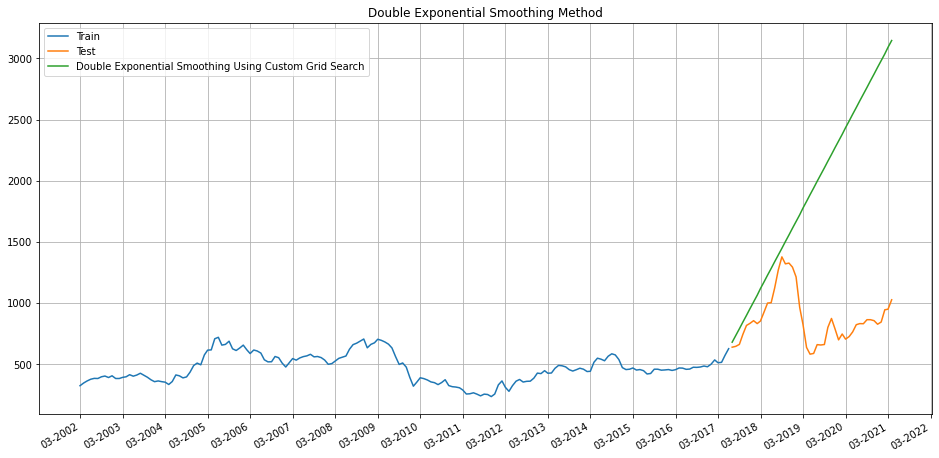

<Figure size 432x288 with 0 Axes>

In [39]:
plt.figure(figsize=(16,8))
plt.grid()
plt.plot(df_training.index, df_training.cpo_pri, label = 'Train')
plt.plot(df_test.index, df_test.cpo_pri,  label = 'Test')
plt.plot(df_test.index, DES_pred,label = 'Double Exponential Smoothing Using Custom Grid Search')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.legend(loc = 'best')
plt.title('Double Exponential Smoothing Method')
plt.show()
plt.savefig('/content/DES.png')

###DES Prediction Plot Zoomed-In

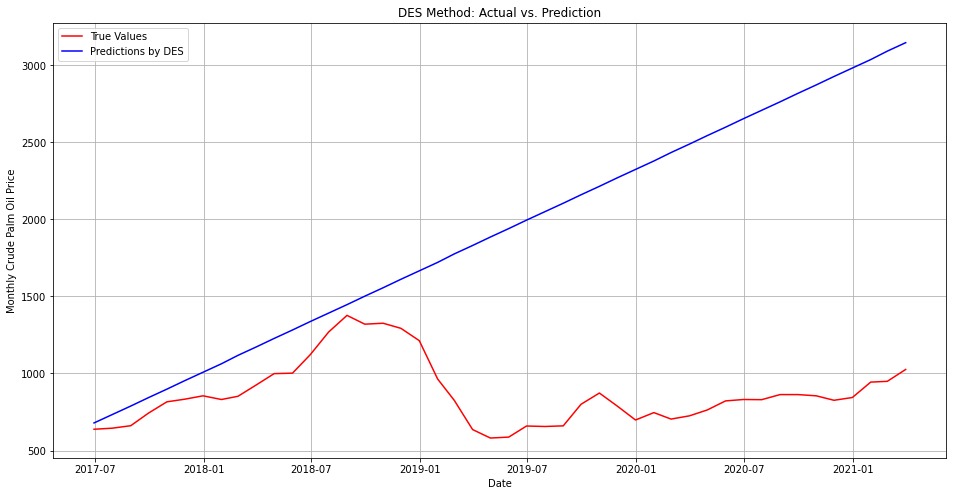

<Figure size 432x288 with 0 Axes>

In [40]:
plt.figure(figsize=(16,8))
plt.grid()
plt.plot(df_test.index, df_test.cpo_pri, color = 'red',  label = 'Test')
plt.plot(df_test.index,  DES_pred, color = 'blue',label = 'DES Prediction')
plt.legend(['True Values', 'Predictions by DES', 'DES Prediction'],loc='best')
plt.title('DES Method: Actual vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')
plt.show()
plt.savefig('/content/DES_ZI.png')

##Triple Exponential Smoothing (TES) or Holt-Winters Method



###Apply Grid Search to get Optimal Parameters of the Simple Exponential Smoothing Model

In [ ]:
from sklearn.model_selection import ParameterGrid
param_grid = {'trend': ['add', 'mul'],'seasonal' :['add', 'mul'],'seasonal_periods':[3,6,12], 'smoothing_level': [0.10, 0.20,.30,.40,.50,.60,.70,.80,.90], 'smoothing_slope':[0.10, 0.20,.30,.40,.50,.60,.70,.80,.90],
              'damping_slope': [0.10, 0.20,.30,.40,.50,.60,.70,.80,.90],'damped' : [True, False], 'use_boxcox':[True, False],
             'remove_bias':[True, False],'use_basinhopping':[True, False]}
pg = list(ParameterGrid(param_grid))

In [ ]:
df_results_moni = pd.DataFrame(columns=['trend','seasonal_periods','smoothing_level', 'smoothing_slope',
                                        'damping_slope','damped','use_boxcox','remove_bias','use_basinhopping','RMSE','r2'])
start = timer()
print('Starting Grid Search..')
for a,b in enumerate(pg):
    trend = b.get('trend')
    smoothing_level = b.get('smoothing_level')
    seasonal_periods = b.get('seasonal_periods')
    smoothing_level = b.get('smoothing_level')
    smoothing_slope = b.get('smoothing_slope')
    damping_slope = b.get('damping_slope')
    damped = b.get('damped')
    use_boxcox = b.get('use_boxcox')
    remove_bias = b.get('remove_bias')
    use_basinhopping = b.get('use_basinhopping')
    fit1 = ExponentialSmoothing(train,trend=trend, damped=damped,seasonal_periods=seasonal_periods ).fit(smoothing_level=smoothing_level, 
                                    smoothing_slope=smoothing_slope, damping_slope = damping_slope,use_boxcox=use_boxcox,optimized=False)
    #fit1.summary
    z = fit1.forecast(46)
    #print(z)
    df_pred = pd.DataFrame(z, columns=['Forecasted_result'])
    RMSE = np.sqrt(metrics.mean_squared_error(test, df_pred.Forecasted_result))
    r2 = metrics.r2_score(test, df_pred.Forecasted_result)
    df_results_moni = df_results_moni.append({'trend':trend,'seasonal_periods':seasonal_periods,'smoothing_level':smoothing_level, 'smoothing_slope':smoothing_slope,
                                        'damping_slope':damping_slope,'damped':damped,'use_boxcox':use_boxcox,'use_basinhopping':use_basinhopping,'RMSE':RMSE,'r2':r2}, ignore_index=True)
print('End of Grid Search')
end = timer()
print(f' Total time taken to complete grid search in seconds: {(end - start)}')

In [ ]:
print(f' Below mentioned parameter gives least RMSE and r2')
df_results_moni.sort_values(by=['RMSE','r2']).head(1)

In [41]:
fit1 = ExponentialSmoothing(train,trend='mul', damped=False,seasonal_periods=3 ).fit(smoothing_level=0.9,smoothing_slope=0.8, damping_slope = 0.8,use_boxcox=False,use_basinhopping = True,optimized=False)
Forecast_custom_pred = fit1.forecast(46)
fit1.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                       ExponentialSmoothing Model Results                       
================================================================================
Dep. Variable:                    endog   No. Observations:                  184
Model:             ExponentialSmoothing   SSE                         212390.849
Optimized:                        False   AIC                           1305.430
Trend:                   Multiplicative   BIC                           1318.289
Seasonal:                          None   AICC                          1305.904
Seasonal Periods:                  None   Date:                 Fri, 19 Nov 2021
Box-Cox:                          False   Time:                         00:36:01
Box-Cox Coeff.:                    None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9000000                alpha                False
smoothing_slope            0.8000000                 beta                False
initial_level              323.00000                  l.0                False
initial_slope              1.0681115                  b.0                False
------------------------------------------------------------------------------
"""

In [145]:
fitESAUTO = ExponentialSmoothing(train).fit(optimized= True, use_brute = True)
fitESAUTO.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                       ExponentialSmoothing Model Results                       
================================================================================
Dep. Variable:                    endog   No. Observations:                  184
Model:             ExponentialSmoothing   SSE                         151479.000
Optimized:                         True   AIC                           1239.241
Trend:                             None   BIC                           1245.671
Seasonal:                          None   AICC                          1239.465
Seasonal Periods:                  None   Date:                 Fri, 19 Nov 2021
Box-Cox:                          False   Time:                         02:30:19
Box-Cox Coeff.:                    None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                 True
initial_level              323.00000                  l.0                 True
------------------------------------------------------------------------------
"""

In [146]:
TES_pred = fitESAUTO.forecast(46)

###Compute TES Evaluation Metrics


In [147]:
MAE_tes = mean_absolute_error(test,  TES_pred)
print('MAE value of the TES Model is:', MAE_tes)

MDA_tes = mda(test,  TES_pred )
print("MDA value of the TES Model is:", *MDA_tes)

MAPE_tes = mean_absolute_percentage_error(test,  TES_pred )
print('MAPE value of the TES Model is:', MAPE_tes)

RMSE_tes = mean_squared_error(test,  TES_pred, squared=False)
print('RMSE value of the TES Model is:', RMSE_tes)

MSE_tes = mean_squared_error(test,  TES_pred )
print('MSE value of the TES Model is:', MSE_tes)

MAE value of the TES Model is: 248.1086956521739
MDA value of the TES Model is: 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
MAPE value of the TES Model is: 25.11552432741552
RMSE value of the TES Model is: 318.5536266368321
MSE value of the TES Model is: 101476.41304347826


###Plot train, test and forecast

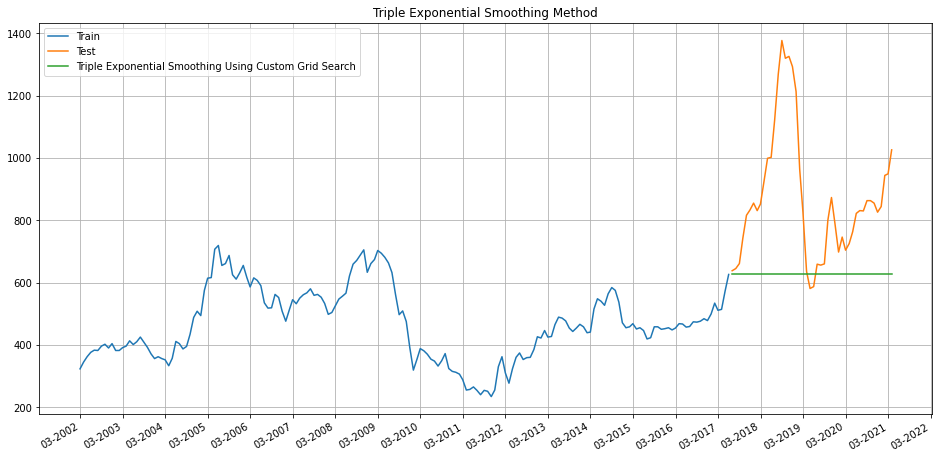

<Figure size 432x288 with 0 Axes>

In [46]:
plt.figure(figsize=(16,8))
plt.grid()
plt.plot(df_training.index, df_training.cpo_pri, label = 'Train')
plt.plot(df_test.index, df_test.cpo_pri,  label = 'Test')
plt.plot(df_test.index, TES_pred,label = 'Triple Exponential Smoothing Using Custom Grid Search')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.legend(loc = 'best')
plt.title('Triple Exponential Smoothing Method')
plt.show()
plt.savefig('/content/TES.png')

###TES Prediction Plot Zoomed-In

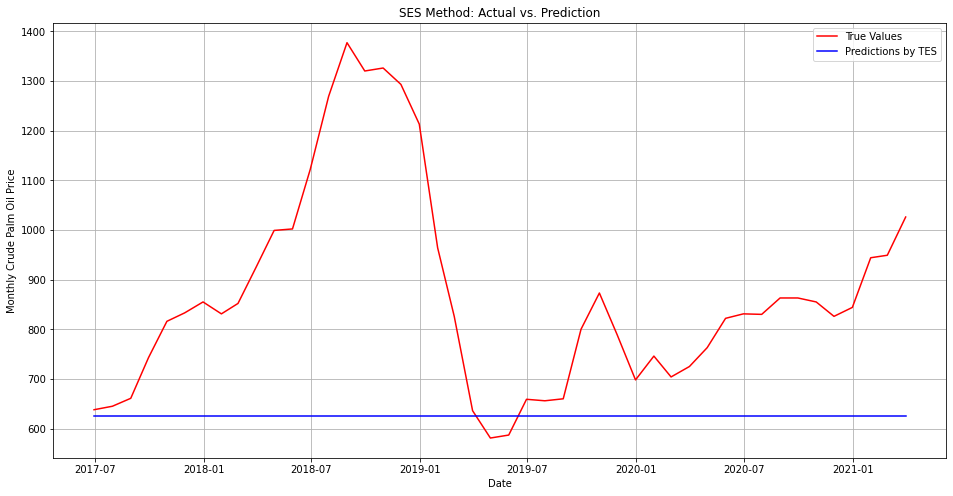

<Figure size 432x288 with 0 Axes>

In [47]:
plt.figure(figsize=(16,8))
plt.grid()
plt.plot(df_test.index, df_test.cpo_pri, color = 'red',  label = 'Test')
plt.plot(df_test.index,  TES_pred, color = 'blue',label = 'SES Prediction')
plt.legend(['True Values', 'Predictions by TES', 'TES Prediction'],loc='best')
plt.title('TES Method: Actual vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')
plt.show()
plt.savefig('/content/TES_ZI.png')

In [148]:
TES_pred  = pd.DataFrame(TES_pred, columns = ['Predictions'])

In [149]:
TES_pred.index = pd.RangeIndex(start=0, stop=46, step=1)

In [150]:
TES_pred 

Predictions
0         626.0
1         626.0
2         626.0
3         626.0
4         626.0
5         626.0
6         626.0
7         626.0
8         626.0
9         626.0
10        626.0
11        626.0
12        626.0
13        626.0
14        626.0
15        626.0
16        626.0
17        626.0
18        626.0
19        626.0
20        626.0
21        626.0
22        626.0
23        626.0
24        626.0
25        626.0
26        626.0
27        626.0
28        626.0
29        626.0
30        626.0
31        626.0
32        626.0
33        626.0
34        626.0
35        626.0
36        626.0
37        626.0
38        626.0
39        626.0
40        626.0
41        626.0
42        626.0
43        626.0
44        626.0
45        626.0

##Support Vector Regression Model



In [48]:
x = df_cl[['cno_pri', 'sbo_pri', 'pno_pri', 'sfo_pri', 'rps_pri', 'wti_spri']]
y = df_cl[['cpo_pri']]

In [49]:
x.reset_index(drop=True)

cno_pri  sbo_pri  pno_pri  sfo_pri  rps_pri  wti_spri
0        455   468.00   844.00   578.00   423.45     28.67
1        546   485.00   799.00   557.00   415.85     24.49
2        595   466.00   718.00   552.00   410.77     22.06
3        636   442.00   614.00   574.00   414.82     21.64
4        738   429.00   619.00   595.00   451.04     22.30
..       ...      ...      ...      ...      ...       ...
225      993   860.28  1366.87  1667.82  1047.78     34.03
226     1031   910.82  1366.87  1680.32  1097.63     35.50
227     1170   997.62  1383.90  1375.09  1138.24     35.81
228     1275  1035.26  1426.71  1359.46  1272.13     33.59
229     1412  1146.75  1471.32  1444.54  1321.88     33.57

[230 rows x 6 columns]

In [50]:
y.reset_index(drop=True)

cpo_pri
0        323
1        345
2        362
3        376
4        383
..       ...
225      826
226      844
227      944
228      949
229     1026

[230 rows x 1 columns]

###Apply MinMax Scaling Function

In [51]:
scaler_x = MinMaxScaler()   
scaler_y = MinMaxScaler()
print(scaler_x.fit(x))       
xscale = scaler_x.transform(x)
print(scaler_y.fit(y))               
yscale=scaler_y.transform(y)

MinMaxScaler()
MinMaxScaler()


###Split Data into Train, Test Sets:

In [52]:
X_train, X_test, y_train, y_test = train_test_split(xscale, yscale, test_size=0.2, random_state=0)

In [72]:
#svregressor=SVR()
#svregressor.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



SVR()

In [73]:
#Sy_pred=svregressor.predict(X_test)

###Apply Grid Search to find the Optimal Parameters 

In [56]:
param_grid = {'C': [0.1, 1, 10, 100],
             'gamma' :[1, 0.1, 0.01, 0.001,],
             'kernel' :['rbf', 'poly', 'linear'],
              'epsilon': [1e-4, 1e-3]}
model = SVR()
grid = GridSearchCV(SVR(),param_grid,cv = 10, refit = True, verbose =3)
grid.fit(X_train,np.ravel(y_train))
svr_gpred = grid.predict(X_test)

print()

print(grid.best_params_)

Fitting 10 folds for each of 96 candidates, totalling 960 fits
[CV 1/10] END C=0.1, epsilon=0.0001, gamma=1, kernel=rbf;, score=0.904 total time=   0.0s
[CV 2/10] END C=0.1, epsilon=0.0001, gamma=1, kernel=rbf;, score=0.856 total time=   0.0s
[CV 3/10] END C=0.1, epsilon=0.0001, gamma=1, kernel=rbf;, score=0.878 total time=   0.0s
[CV 4/10] END C=0.1, epsilon=0.0001, gamma=1, kernel=rbf;, score=0.931 total time=   0.0s
[CV 5/10] END C=0.1, epsilon=0.0001, gamma=1, kernel=rbf;, score=0.886 total time=   0.0s
[CV 6/10] END C=0.1, epsilon=0.0001, gamma=1, kernel=rbf;, score=0.936 total time=   0.0s
[CV 7/10] END C=0.1, epsilon=0.0001, gamma=1, kernel=rbf;, score=0.875 total time=   0.0s
[CV 8/10] END C=0.1, epsilon=0.0001, gamma=1, kernel=rbf;, score=0.931 total time=   0.0s
[CV 9/10] END C=0.1, epsilon=0.0001, gamma=1, kernel=rbf;, score=0.917 total time=   0.0s
[CV 10/10] END C=0.1, epsilon=0.0001, gamma=1, kernel=rbf;, score=0.939 total time=   0.0s
[CV 1/10] END C=0.1, epsilon=0.0001,

In [57]:
svr_gprediction = np.reshape(svr_gpred, (-1,1))

In [58]:
svr_gprediction = scaler_y.inverse_transform(svr_gprediction)

In [59]:
svr_prediction = pd.DataFrame(svr_gprediction, columns = ['Predictions'])

In [60]:
svr_prediction.head()

Predictions
0   456.138306
1  1414.139573
2   298.997599
3   686.888433
4   462.643643

In [61]:
testY = scaler_y.inverse_transform(y_test)

In [62]:
testY2 = pd.DataFrame(testY, columns = ['Predictions'])

In [63]:
testY2.head()

Predictions
0        443.0
1       1293.0
2        323.0
3        661.0
4        466.0

###Plot train, test and forecast

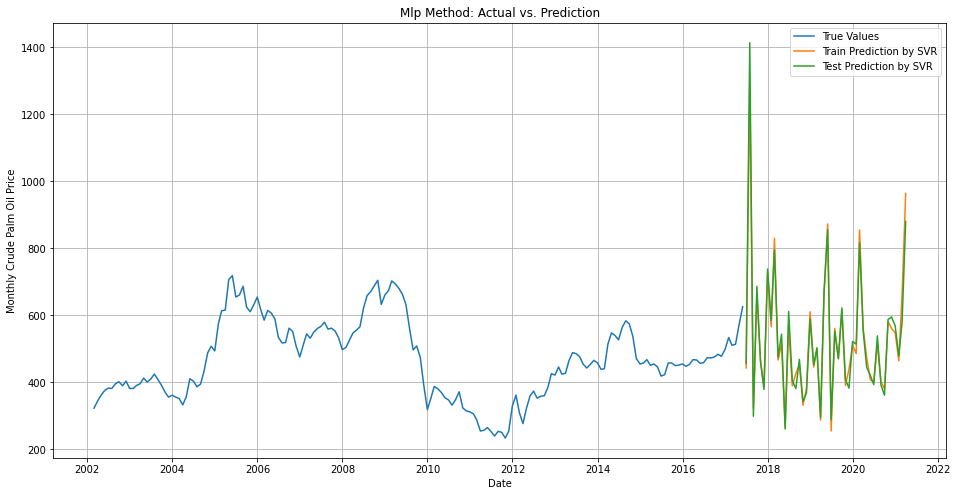

<Figure size 432x288 with 0 Axes>

In [64]:
plt.figure(figsize=(16,8))
plt.grid()
plt.plot(df_training.index, df_training.cpo_pri, label = 'Train')
plt.plot(df_test.index, testY2,  label = 'Test')
plt.plot(df_test.index, svr_prediction,label = 'SVR Prediction')
plt.legend(['True Values', 'Train Prediction by SVR', 'Test Prediction by SVR'],loc='best')
plt.title('Mlp Method: Actual vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')
plt.show()
plt.savefig('/content/SVR.png')

###SVR Prediction Plot Zoomed-In

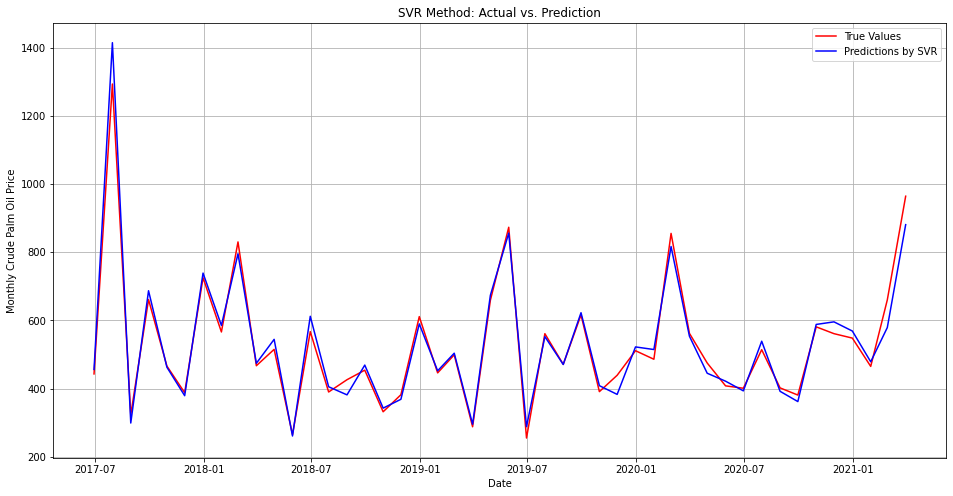

<Figure size 432x288 with 0 Axes>

In [65]:
plt.figure(figsize=(16,8))
plt.grid()
plt.plot(df_test.index, testY2, color = 'red',  label = 'Test')
plt.plot(df_test.index,  svr_prediction, color = 'blue',label = 'SVR Prediction')
plt.legend(['True Values', 'Predictions by SVR', 'SVR Prediction'],loc='best')
plt.title('SVR Method: Actual vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')
plt.show()
plt.savefig('/content/SVR_ZI.png')

###Compute DES Evaluation Metrics

In [66]:
MAE_svr = mean_absolute_error(testY2, svr_prediction)
print('MAE value of the SVR Model is:', MAE_svr)

MDA_svr = mda(testY2, svr_prediction)
print('MDA value of the SVR Model is:', *MDA_svr)

MAPE_svr = mean_absolute_percentage_error(testY2, svr_prediction)
print('MAPE value of the SVR Model is:', MAPE_svr)

RMSE_svr = mean_squared_error(testY2,svr_prediction, squared=False)
print('RMSE value of the SVR Model is:', RMSE_svr)

MSE_svr = mean_squared_error(testY2,svr_prediction)
print('MSE value of the SVR Model is:', MSE_svr)

MAE value of the SVR Model is: 23.347351303880448
MDA value of the SVR Model is: 0.9565217391304348
MAPE value of the SVR Model is: 4.25461054287112
RMSE value of the SVR Model is: 32.79707621249276
MSE value of the SVR Model is: 1075.6482080880587


##Multi-Layer Perceptron (MLP)

###Define Pipe Line MLPRegression

In [67]:
pipe_MLPRegressor = Pipeline([('scaler',  MinMaxScaler()),
            ('MLPRegressor', MLPRegressor(random_state = 42))])

In [78]:
grid_params_MLPRegressor = [{
    'MLPRegressor__solver': ['sgd', 'adam'],
    'MLPRegressor__alpha': [0.0001, 0.05],
    'MLPRegressor__max_iter': [100,200,300, 500, 1000],
    'MLPRegressor__activation' : ['relu','logistic','tanh'],
    'MLPRegressor__learning_rate' : ['constant', 'adaptive'],
    'MLPRegressor__hidden_layer_sizes':[(50,50,50), (50,100,50), (100,)],}]

CV_mlpregressor_grid = GridSearchCV (estimator = pipe_MLPRegressor,
                               param_grid = grid_params_MLPRegressor, n_jobs=-1,
                               cv = 10,return_train_score=True, verbose=0)

CV_mlpregressor_grid.fit(X_train, y_train)

ypred=CV_mlpregressor_grid.predict(X_test)

print (np.c_[y_test, ypred])
print('Best Parameters : ',CV_mlpregressor_grid.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[[0.18285214 0.16387807]
 [0.92650919 0.96845955]
 [0.07786527 0.09333714]
 [0.3735783  0.39561317]
 [0.20297463 0.16607601]
 [0.13473316 0.20428522]
 [0.4295713  0.46246014]
 [0.29046369 0.30664795]
 [0.52143482 0.49280632]
 [0.20384952 0.22030114]
 [0.24584427 0.19941426]
 [0.02712161 0.05230071]
 [0.29133858 0.28575526]
 [0.13648294 0.17503578]
 [0.167979   0.17891854]
 [0.19247594 0.16388329]
 [0.08573928 0.14567237]
 [0.12948381 0.17378645]
 [0.32983377 0.25867888]
 [0.18547682 0.22542092]
 [0.23184602 0.27839006]
 [0.04724409 0.04699084]
 [0.37182852 0.36675537]
 [0.55905512 0.49208842]
 [0.0183727  0.0529237 ]
 [0.28608924 0.2810714 ]
 [0.20734908 0.2467703 ]
 [0.33420822 0.28019246]
 [0.13735783 0.12438019]
 [0.17935258 0.12048713]
 [0.24234471 0.25892059]
 [0.22047244 0.21202685]
 [0.54330709 0.51931789]
 [0.28696413 0.32140204]
 [0.21084864 0.27611956]
 [0.15223097 0.10044392]
 [0.14610674 0.1133466 ]
 [0.24496938 0.2713307 ]
 [0.14698163 0.17109583]
 [0.12860892 0.18751008]


In [79]:
model = Sequential()
model.add(Dense(12, input_dim=6, kernel_initializer='normal', activation='tanh'))
model.add(Dense(8, activation='tanh'))
model.add(Dense(1, activation='tanh'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 12)                84        
                                                                 
 dense_4 (Dense)             (None, 8)                 104       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 197
Trainable params: 197
Non-trainable params: 0
_________________________________________________________________


In [80]:
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

In [81]:
history = model.fit(X_train, y_train, epochs=250, batch_size=50,  verbose=1, validation_split=0.2)

Epoch 1/250
3/3 [==============================] - 1s 82ms/step - loss: 0.0850 - mse: 0.0850 - mae: 0.2280 - val_loss: 0.0908 - val_mse: 0.0908 - val_mae: 0.2488
Epoch 2/250
3/3 [==============================] - 0s 16ms/step - loss: 0.0596 - mse: 0.0596 - mae: 0.1772 - val_loss: 0.0640 - val_mse: 0.0640 - val_mae: 0.1977
Epoch 3/250
3/3 [==============================] - 0s 13ms/step - loss: 0.0427 - mse: 0.0427 - mae: 0.1411 - val_loss: 0.0454 - val_mse: 0.0454 - val_mae: 0.1596
Epoch 4/250
3/3 [==============================] - 0s 14ms/step - loss: 0.0318 - mse: 0.0318 - mae: 0.1210 - val_loss: 0.0343 - val_mse: 0.0343 - val_mae: 0.1382
Epoch 5/250
3/3 [==============================] - 0s 13ms/step - loss: 0.0273 - mse: 0.0273 - mae: 0.1174 - val_loss: 0.0285 - val_mse: 0.0285 - val_mae: 0.1311
Epoch 6/250
3/3 [==============================] - 0s 15ms/step - loss: 0.0259 - mse: 0.0259 - mae: 0.1222 - val_loss: 0.0259 - val_mse: 0.0259 - val_mae: 0.1277
Epoch 7/250
3/3 [===========

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


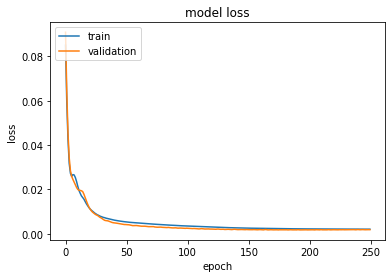

<Figure size 432x288 with 0 Axes>

In [82]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.savefig('/content/MLP_his.png')

In [83]:
ypred = model.predict(X_test)

In [84]:
mlp_pred = scaler_y.inverse_transform(ypred)

In [85]:
MLP_predictions = pd.DataFrame(mlp_pred, columns = ['Predictions'])

In [86]:
MLP_predictions.head()

Predictions
0   427.300903
1  1184.510376
2   325.788544
3   699.152527
4   414.261108

In [87]:
testY2 = pd.DataFrame(testY, columns = ['Predictions'])

In [88]:
testY2.head()

Predictions
0        443.0
1       1293.0
2        323.0
3        661.0
4        466.0

In [89]:
ActPred = pd.DataFrame(np.concatenate([testY, mlp_pred], axis=1), columns= ['Actual','MLP Predicted'])

In [90]:
ActPred.head()

Actual  MLP Predicted
0   443.0     427.300903
1  1293.0    1184.510376
2   323.0     325.788544
3   661.0     699.152527
4   466.0     414.261108

###Plot Train, Test and Forecast



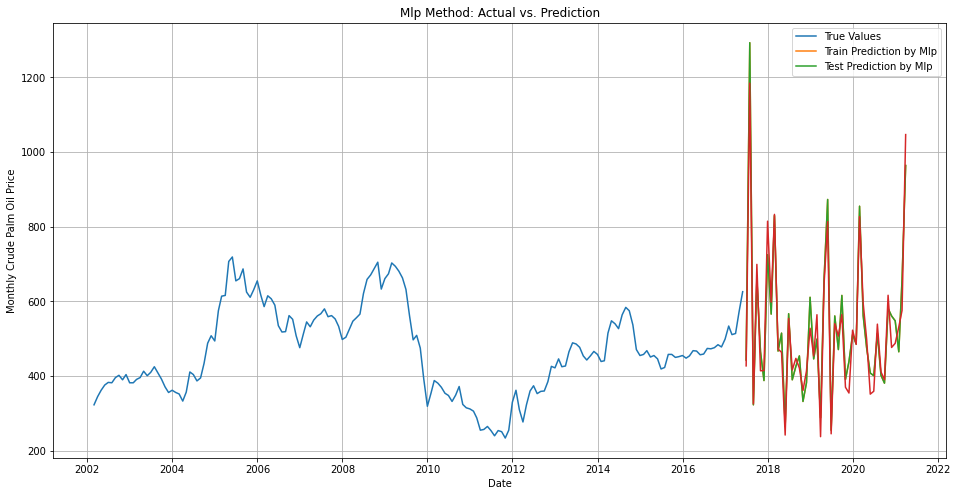

<Figure size 432x288 with 0 Axes>

In [91]:
plt.figure(figsize=(16,8))
plt.grid()
plt.plot(df_training.index, df_training.cpo_pri, label = 'Train')
plt.plot(df_test.index, testY2,  label = 'Test')
plt.plot(df_test.index, ActPred,label = 'MLP Prediction')
plt.legend(['True Values', 'Train Prediction by Mlp', 'Test Prediction by Mlp'],loc='best')
plt.title('Mlp Method: Actual vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')
plt.show()
plt.savefig('/content/MLP.png')

###MLP Prediction Plot Zoomed-In

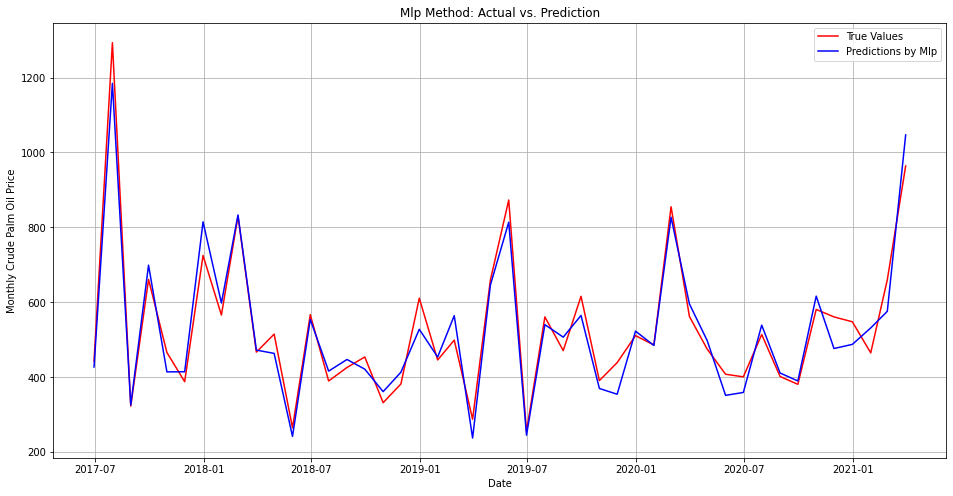

<Figure size 432x288 with 0 Axes>

In [92]:
plt.figure(figsize=(16,8))
plt.grid()
plt.plot(df_test.index, testY2, color = 'red',  label = 'Test')
plt.plot(df_test.index,  MLP_predictions, color = 'blue',label = 'MLP Prediction')
plt.legend(['True Values', 'Predictions by Mlp', 'MLP Prediction'],loc='best')
plt.title('Mlp Method: Actual vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')
plt.show()
plt.savefig('/content/MLP_ZI.png')

###Compute MLP Evaluation Metrics

In [93]:
MAE_mlp = mean_absolute_error(testY2, MLP_predictions)
print('MAE value of the MLP Model is:', MAE_mlp)

MDA_mlp = mda(testY2, MLP_predictions)
print("MDA value of the MLP Model is:", *MDA_mlp)

MAPE_mlp = mean_absolute_percentage_error(testY2, MLP_predictions)
print('MAPE value of the MLP Model is:', MAPE_mlp)

RMSE_mlp = mean_squared_error(testY2, MLP_predictions, squared=False)
print('RMSE value of the MLP Model is:', RMSE_mlp)

MSE_mlp = mean_squared_error(testY2, MLP_predictions)
print('MSE value of the MLP Model is:', MSE_mlp)

MAE value of the MLP Model is: 38.18264372452447
MDA value of the MLP Model is: 0.9565217391304348
MAPE value of the MLP Model is: 7.259733205833481
RMSE value of the MLP Model is: 46.96984792207049
MSE value of the MLP Model is: 2206.1666138224296


###Create  Dictionary to Save Metric Scores

In [94]:
Met_eval = pd.DataFrame({'MAE': [248, 23.34,38.18],
                    'MDA': [0.0, 0.95,0.95],
                    'MAPE': [25.11, 4.25,7.25],
                    'RMSE': [318.55, 32.79,46.05],
                    'MSE': [101476, 48.05,2206]},
                   index=['Holt-Winters', 'Support Vector Regression', 'Multi-Layer Perceptron'])

In [95]:
Met_eval

MAE   MDA   MAPE    RMSE        MSE
Holt-Winters               248.00  0.00  25.11  318.55  101476.00
Support Vector Regression   23.34  0.95   4.25   32.79      48.05
Multi-Layer Perceptron      38.18  0.95   7.25   46.05    2206.00

In [ ]:
test.head()

Predictions
0          638
1          645
2          661
3          743
4          816

In [112]:
svr_prediction
svr_prediction.head()
svr_prediction.columns = ['SVR_prediction']
svr_prediction

SVR_prediction
0       456.138306
1      1414.139573
2       298.997599
3       686.888433
4       462.643643
5       379.097751
6       738.608843
7       585.183222
8       795.351914
9       474.175463
10      544.295649
11      260.981426
12      611.945721
13      405.304881
14      381.583151
15      468.869434
16      342.653986
17      368.627392
18      589.629719
19      452.108285
20      503.769158
21      295.512158
22      673.456785
23      855.937476
24      288.347521
25      552.348558
26      470.658989
27      622.429078
28      408.526298
29      382.953071
30      522.120625
31      514.490502
32      816.499117
33      553.574635
34      444.957705
35      421.673274
36      393.312826
37      538.839416
38      391.970878
39      361.913059
40      588.059461
41      595.622496
42      568.731574
43      478.558366
44      578.838218
45      880.593217

In [111]:
MLP_predictions.head()
MLP_predictions.columns = ['MLP_prediction']
MLP_predictions

MLP_prediction
0       427.300903
1      1184.510376
2       325.788544
3       699.152527
4       414.261108
5       414.596466
6       814.834717
7       598.116272
8       833.100037
9       472.445740
10      463.566223
11      242.011185
12      554.192993
13      416.309509
14      447.360718
15      421.577179
16      361.513336
17      413.402527
18      527.983398
19      453.881287
20      564.305725
21      237.678131
22      645.843079
23      813.773254
24      245.311417
25      540.343811
26      506.967682
27      564.850098
28      370.005280
29      354.576965
30      522.958069
31      484.829193
32      827.020630
33      595.514343
34      497.756714
35      351.612030
36      359.346252
37      539.078247
38      411.256378
39      390.061401
40      616.434509
41      476.610565
42      487.682068
43      531.543762
44      575.927063
45     1046.836304

In [172]:
df_test.head()

index  cpo_pri  cno_pri  sbo_pri  pno_pri  sfo_pri  rps_pri  wti_spri
0 2017-06-30      638      731   697.33  1071.64   809.86   847.47     49.44
1 2017-07-31      645      763   715.04  1016.33   800.76   905.99     50.17
2 2017-08-31      661      769   719.03  1055.21   799.04   875.36     46.41
3 2017-09-30      743      828   753.70  1078.17   806.00   872.87     47.65
4 2017-10-31      816      894   788.70  1169.41   800.91   897.25     43.89

In [173]:
df_actual = df_test.drop(columns=['cno_pri', 'sbo_pri', 'pno_pri', 'sfo_pri', 'rps_pri', 'wti_spri'])

In [174]:
df_actual.head()

index  cpo_pri
0 2017-06-30      638
1 2017-07-31      645
2 2017-08-31      661
3 2017-09-30      743
4 2017-10-31      816

In [175]:
df_actual = df_actual.reset_index()

In [184]:
df_actual.head()

index  cpo_pri
0 2017-06-30      638
1 2017-07-31      645
2 2017-08-31      661
3 2017-09-30      743
4 2017-10-31      816

In [192]:
df_merge = pd.concat([df_actual,TES_pred, svr_prediction, MLP_predictions],axis=1,sort=False).reset_index()

In [193]:
df_merge.head()

level_0      index  cpo_pri  Predictions  SVR_prediction  MLP_prediction
0        0 2017-06-30      638        626.0      456.138306      427.300903
1        1 2017-07-31      645        626.0     1414.139573     1184.510376
2        2 2017-08-31      661        626.0      298.997599      325.788544
3        3 2017-09-30      743        626.0      686.888433      699.152527
4        4 2017-10-31      816        626.0      462.643643      414.261108

In [194]:
df_merge = df_merge.drop(columns=['level_0'])

In [195]:
df_merge.head()

index  cpo_pri  Predictions  SVR_prediction  MLP_prediction
0 2017-06-30      638        626.0      456.138306      427.300903
1 2017-07-31      645        626.0     1414.139573     1184.510376
2 2017-08-31      661        626.0      298.997599      325.788544
3 2017-09-30      743        626.0      686.888433      699.152527
4 2017-10-31      816        626.0      462.643643      414.261108

In [196]:
df_merge.rename(columns={'Predictions': 'TES_prediction'})

index  cpo_pri  TES_prediction  SVR_prediction  MLP_prediction
0  2017-06-30      638           626.0      456.138306      427.300903
1  2017-07-31      645           626.0     1414.139573     1184.510376
2  2017-08-31      661           626.0      298.997599      325.788544
3  2017-09-30      743           626.0      686.888433      699.152527
4  2017-10-31      816           626.0      462.643643      414.261108
5  2017-11-30      833           626.0      379.097751      414.596466
6  2017-12-31      855           626.0      738.608843      814.834717
7  2018-01-31      831           626.0      585.183222      598.116272
8  2018-02-28      852           626.0      795.351914      833.100037
9  2018-03-31      926           626.0      474.175463      472.445740
10 2018-04-30      999           626.0      544.295649      463.566223
11 2018-05-31     1002           626.0      260.981426      242.011185
12 2018-06-30     1122           626.0      611.945721      554.192993
13 2018-07-31     1269           626.0      405.304881      416.309509
14 2018-08-31     1377           626.0      381.583151      447.360718
15 2018-09-30     1320           626.0      468.869434      421.577179
16 2018-10-31     1326           626.0      342.653986      361.513336
17 2018-11-30     1293           626.0      368.627392      413.402527
18 2018-12-31     1213           626.0      589.629719      527.983398
19 2019-01-31      964           626.0      452.108285      453.881287
20 2019-02-28      826           626.0      503.769158      564.305725
21 2019-03-31      636           626.0      295.512158      237.678131
22 2019-04-30      581           626.0      673.456785      645.843079
23 2019-05-31      587           626.0      855.937476      813.773254
24 2019-06-30      659           626.0      288.347521      245.311417
25 2019-07-31      656           626.0      552.348558      540.343811
26 2019-08-31      660           626.0      470.658989      506.967682
27 2019-09-30      800           626.0      622.429078      564.850098
28 2019-10-31      873           626.0      408.526298      370.005280
29 2019-11-30      789           626.0      382.953071      354.576965
30 2019-12-31      698           626.0      522.120625      522.958069
31 2020-01-31      746           626.0      514.490502      484.829193
32 2020-02-29      704           626.0      816.499117      827.020630
33 2020-03-31      725           626.0      553.574635      595.514343
34 2020-04-30      763           626.0      444.957705      497.756714
35 2020-05-31      822           626.0      421.673274      351.612030
36 2020-06-30      831           626.0      393.312826      359.346252
37 2020-07-31      830           626.0      538.839416      539.078247
38 2020-08-31      863           626.0      391.970878      411.256378
39 2020-09-30      863           626.0      361.913059      390.061401
40 2020-10-31      855           626.0      588.059461      616.434509
41 2020-11-30      826           626.0      595.622496      476.610565
42 2020-12-31      844           626.0      568.731574      487.682068
43 2021-01-31      944           626.0      478.558366      531.543762
44 2021-02-28      949           626.0      578.838218      575.927063
45 2021-03-31     1026           626.0      880.593217     1046.836304

In [167]:
import pandas as pd
import pandas_bokeh
pandas_bokeh.output_notebook()
df_merge.plot_bokeh(kind='line')

Figure(id='1002', ...)

In [207]:
df_wide = df_merge
df_long = pd.melt(df_wide, id_vars=['index'], value_vars=['cpo_pri','Predictions', 'SVR_prediction', 'MLP_prediction'])

# plotly 
fig = px.line(df_long, x='index', y='value', color='variable')
fig.show()
fig.show(renderer="colab")

In [205]:
df_wide

index  cpo_pri  Predictions  SVR_prediction  MLP_prediction
0  2017-06-30      638        626.0      456.138306      427.300903
1  2017-07-31      645        626.0     1414.139573     1184.510376
2  2017-08-31      661        626.0      298.997599      325.788544
3  2017-09-30      743        626.0      686.888433      699.152527
4  2017-10-31      816        626.0      462.643643      414.261108
5  2017-11-30      833        626.0      379.097751      414.596466
6  2017-12-31      855        626.0      738.608843      814.834717
7  2018-01-31      831        626.0      585.183222      598.116272
8  2018-02-28      852        626.0      795.351914      833.100037
9  2018-03-31      926        626.0      474.175463      472.445740
10 2018-04-30      999        626.0      544.295649      463.566223
11 2018-05-31     1002        626.0      260.981426      242.011185
12 2018-06-30     1122        626.0      611.945721      554.192993
13 2018-07-31     1269        626.0      405.304881      416.309509
14 2018-08-31     1377        626.0      381.583151      447.360718
15 2018-09-30     1320        626.0      468.869434      421.577179
16 2018-10-31     1326        626.0      342.653986      361.513336
17 2018-11-30     1293        626.0      368.627392      413.402527
18 2018-12-31     1213        626.0      589.629719      527.983398
19 2019-01-31      964        626.0      452.108285      453.881287
20 2019-02-28      826        626.0      503.769158      564.305725
21 2019-03-31      636        626.0      295.512158      237.678131
22 2019-04-30      581        626.0      673.456785      645.843079
23 2019-05-31      587        626.0      855.937476      813.773254
24 2019-06-30      659        626.0      288.347521      245.311417
25 2019-07-31      656        626.0      552.348558      540.343811
26 2019-08-31      660        626.0      470.658989      506.967682
27 2019-09-30      800        626.0      622.429078      564.850098
28 2019-10-31      873        626.0      408.526298      370.005280
29 2019-11-30      789        626.0      382.953071      354.576965
30 2019-12-31      698        626.0      522.120625      522.958069
31 2020-01-31      746        626.0      514.490502      484.829193
32 2020-02-29      704        626.0      816.499117      827.020630
33 2020-03-31      725        626.0      553.574635      595.514343
34 2020-04-30      763        626.0      444.957705      497.756714
35 2020-05-31      822        626.0      421.673274      351.612030
36 2020-06-30      831        626.0      393.312826      359.346252
37 2020-07-31      830        626.0      538.839416      539.078247
38 2020-08-31      863        626.0      391.970878      411.256378
39 2020-09-30      863        626.0      361.913059      390.061401
40 2020-10-31      855        626.0      588.059461      616.434509
41 2020-11-30      826        626.0      595.622496      476.610565
42 2020-12-31      844        626.0      568.731574      487.682068
43 2021-01-31      944        626.0      478.558366      531.543762
44 2021-02-28      949        626.0      578.838218      575.927063
45 2021-03-31     1026        626.0      880.593217     1046.836304